# Installing Packages

In [10]:
!pip install astropy escnn
!pip install gdown --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.9/373.9 kB 9.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 55.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.1 MB/s eta 0:00:00
  Created wheel for py3nj: filename=py3nj-0.2.1-cp310-cp310-linux_x86_64.whl size=44801 sha256=0d67ffd67702b91fd871353d66bb8244f53786e0ace5b83e76f3fc66899bcca2
  Stored in directory: /root/.cache/pip/wheels/71/e9/70/30a34ed6dbc8b54ce93f25c091be4cf7a24319e27d953a882b
Successfully built py3nj


# Importing Packages

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt


from astropy.io import fits
from tqdm.auto import tqdm
import glob
import sys
import zipfile


from sklearn.cluster import KMeans, SpectralClustering
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.manifold import TSNE


from escnn import gspaces, nn as enn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

# Downloading Data and Models

In [2]:
file_id = "15tQuOqEWjS2GBQO5SOuGE7M6UHyGDg63"
!gdown --id $file_id

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=15tQuOqEWjS2GBQO5SOuGE7M6UHyGDg63
From (redirected): https://drive.google.com/uc?id=15tQuOqEWjS2GBQO5SOuGE7M6UHyGDg63&confirm=t&uuid=79d3fed3-f0d4-4e4a-8c0c-6e4e13375f33
To: /kaggle/working/EXXA-models&data-20250401T060641Z-001.zip
100%|█████████████████████████████████████████| 658M/658M [00:02<00:00, 234MB/s]


In [6]:
# EXTRACTING DOWNLOADED FILE
base_path = '/kaggle/working'
extract_dir = base_path


zip_filepath = base_path+'/EXXA-models&data-20250401T060641Z-001.zip'
with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


zip_filepath = base_path+'/EXXA-models&data/continuum_data_subset-20250303T002205Z-001.zip'
with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
    zip_ref.extractall(base_path)


# Preparing Dataloader

In [9]:
# DEFINING PATHS OF IMAGES FOR TRAINING

image_dir_path = base_path+"/continuum_data_subset"
paths = sorted(glob.glob(image_dir_path+"/*.fits"))

len(paths)

150

In [7]:
# INSTEAD OF USING MIN-MAX/Z-SCORE I CALCUALTED MEAN/VAR OF WHOLE IMAGES 
# WHICH LED TO A FASTER CONVERGING & UNBIASED MODEL

mean = 0.0
var = 0.0
for path in paths:
    with fits.open(path) as hdul:
            image = hdul[0].data[0][0][0]
    mean += np.mean(image)
    var += (np.std(image))**2

mean /= len(paths)
var /= len(paths)
std = np.sqrt(var)
print(mean,std)

1.586220816712411e-22 4.667396082087401e-22


In [8]:
# DATASET CLASS 

def normalise(image):
    if std == 0:
        return image - mean
    normalized_img = (image - mean) / (std)
    return normalized_img

class MeraDataset(Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        with fits.open(self.paths[idx]) as hdul:
            image = hdul[0].data[0][0][0]
        image = normalise(image)
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32)
        return image

In [9]:
# AUGMENTATIONS

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.GaussianBlur(kernel_size=3, sigma=(2, 3)),  # FOR GRAINY IMAGES
    transforms.Pad(padding=414, padding_mode="edge"),      # TO GET UNIFORM IMAGE AFTER ROTATING
    transforms.RandomChoice([
        transforms.RandomAffine(degrees=180,shear=(20, 50)),
        transforms.RandomAffine(degrees=180,shear=(-50, -20)),
        transforms.RandomAffine(degrees=180,scale=(0.6,1))
    ]),
    # transforms.RandomRotation(degrees=90), 
    transforms.CenterCrop((600, 600)),  
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.ColorJitter(brightness=0.4, contrast=0.8)  # DIDN'T HELPED MUCH
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

In [10]:
full_train_dataset = MeraDataset(paths, transform=train_transforms)
full_train_dataloader = DataLoader(full_train_dataset, batch_size=16, shuffle=True)

# Model Architecture

In [11]:
class EquivariantAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=16, num_rotations=8, dropout_prob=0.0):
        super(EquivariantAE, self).__init__()

        self.gspace = gspaces.flipRot2dOnR2(N=num_rotations) 
        
        self.input_type = enn.FieldType(self.gspace, in_channels * [self.gspace.trivial_repr])
        self.conv1 = enn.R2Conv(self.input_type,
                                enn.FieldType(self.gspace, 4 * [self.gspace.regular_repr]),
                                kernel_size=3, stride=2, padding=1)
        self.elu1 = enn.ELU(self.conv1.out_type, inplace=True)

        self.conv2 = enn.R2Conv(self.conv1.out_type,
                                enn.FieldType(self.gspace, 8 * [self.gspace.regular_repr]),
                                kernel_size=3, stride=2, padding=1)
        self.elu2 = enn.ELU(self.conv2.out_type, inplace=True)

        self.conv3 = enn.R2Conv(self.conv2.out_type,
                                enn.FieldType(self.gspace, latent_dim * [self.gspace.regular_repr]),
                                kernel_size=3, stride=2, padding=1)
        self.elu3 = enn.ELU(self.conv3.out_type, inplace=True)
        self.group_pool = enn.GroupPooling(self.conv3.out_type)

        self.deconv1 = enn.R2ConvTransposed(self.conv3.out_type,
                                            self.conv2.out_type,
                                            kernel_size=3, stride=2, padding=1, output_padding=1)
        self.drop1 = enn.FieldDropout(self.deconv1.out_type, p=dropout_prob)
        self.elu4 = enn.ELU(self.deconv1.out_type, inplace=True)

        self.deconv2 = enn.R2ConvTransposed(self.deconv1.out_type,
                                            self.conv1.out_type,
                                            kernel_size=3, stride=2, padding=1, output_padding=1)
        self.drop2 = enn.FieldDropout(self.deconv2.out_type, p=dropout_prob)
        self.elu5 = enn.ELU(self.deconv2.out_type, inplace=True)

        self.deconv3 = enn.R2ConvTransposed(self.deconv2.out_type,
                                            enn.FieldType(self.gspace, in_channels * [self.gspace.trivial_repr]),
                                            kernel_size=3, stride=2, padding=1, output_padding=1)

    def encode(self, x):
        x = enn.GeometricTensor(x, self.input_type)
        x = self.elu1(self.conv1(x))
        x = self.elu2(self.conv2(x))
        x = self.elu3(self.conv3(x))
        return x

    def project(self, z):
        z = self.group_pool(z)
        z = z.tensor.mean(dim=[2, 3], keepdim=True)
        z = F.normalize(z, dim=1)
        return z.squeeze()

    def decode(self, x):
        x = self.elu4(self.drop1(self.deconv1(x)))
        x = self.elu5(self.drop2(self.deconv2(x)))
        x = self.deconv3(x)
        return x.tensor

    def forward(self, x):
        encoded = self.encode(x)
        projected = self.project(encoded)
        decoded = self.decode(encoded)
        return decoded, projected

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Training

In [12]:
# GETTING PRETRAINED RESNET-18 for Perceptual Loss (making similar looking images to human eye)

def resnet18_feature_extractor():
    model = models.resnet18(pretrained=True)
    model = nn.Sequential(*list(model.children())[:-2])
    for param in model.parameters():
        param.requires_grad = False
    return model

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.feature_extractor = resnet18_feature_extractor()
        self.criterion = nn.L1Loss()

    def forward(self, x, y):
        x = x.repeat(1, 3, 1, 1)
        features_x = self.feature_extractor(x)
        y = y.repeat(1, 3, 1, 1)
        features_y = self.feature_extractor(y)
        loss = self.criterion(features_x, features_y)
        return loss

# ENFORCING ORTHOGONALITY IN LATENT DIMENSIONS TO MAKE FULL USE OF LATENT SPACE TO CAPTURE INDIVIDUAL INFORMATIONS
# INSPIRED FROM VICReg PAPER (a SSL technique)

def orthogonality_loss(z):
    batch_size, dim = z.shape
    z = z - z.mean(dim=0, keepdim=True)
    cov_matrix = (z.T @ z) / (batch_size - 1)
    identity = torch.eye(dim, device=z.device)
    loss = torch.norm(cov_matrix * (1 - identity), p="fro")
    return loss

perceptual_loss = PerceptualLoss().to(device)

# DUE TO IMBALANCED NUMBER OF DIFFERENT VARIETY OF DISKS USED FOCAL LOSSES TO FOCUS MORE ON MORE BADLY CONSTRCUTED IMAGES

def focal_loss(preds, targets, alpha=1e-7, gamma=2.0):
    mse=perceptual_loss(preds, targets)
    focal_loss = (alpha+mse)**(gamma)
    return focal_loss.mean()

def focal_mse_loss(x_recon, x, gamma=2.0):
    mse = (x_recon - x) ** 2
    weights = torch.exp(-gamma * x.abs())
    return (weights * mse).mean()

# DROPPED SIMCLR DIDN'T HELPED ME MUCH (Probably small dataset or wrong choice of hyperparas or I dont know!! )
# I will definitely try some SSL TECHNIQUES (Barlow_twins, MoCo, VICReg, OBoW) LATER IN THE FUTURE WHEN I LL GET TO WORK ON THE PROBLEM



# def simclr_loss(z1, z2, temperature=0.5):

#     z1 = F.normalize(z1, p=2, dim=1)
#     z2 = F.normalize(z2, p=2, dim=1)
#     z = torch.cat([z1, z2], dim=0)
#     sim_matrix = torch.mm(z, z.T)
#     batch_size = z1.shape[0]
#     mask = torch.eye(2 * batch_size, device=z.device).bool()
#     sim_matrix = sim_matrix.masked_fill(mask, float('-inf'))
#     positives = torch.cat([torch.diag(sim_matrix, batch_size), torch.diag(sim_matrix, -batch_size)], dim=0)
#     loss = -torch.log(torch.exp(positives / temperature) / torch.sum(torch.exp(sim_matrix / temperature), dim=1))
#     return loss.mean()

# simclr_aug = transforms.Compose([
#     transforms.Pad(padding=414, padding_mode="edge"),
#     transforms.RandomChoice([
#         transforms.RandomAffine(degrees=180,scale=(0.6,1),shear=(20, 50)),
#         transforms.RandomAffine(degrees=180,scale=(0.6,1),shear=(-50, -20))
#     ]),
#     transforms.CenterCrop((256, 256)),
# ])

loss_history = []

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.6MB/s]


In [13]:
#INITIALISING MODEL, OPTIMISER AND LR SCHDEULERS

# eae = EquivariantAE().to(device)
# optimizer = torch.optim.Adam(eae.parameters(), lr=1e-2)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.66, patience=2, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
#TRAINING LOOP WITH 10 FOLDS

# kf = KFold(n_splits=10, shuffle=True, random_state=42)
# fold_loss_history = {}
# best_models = {}

# for fold, (train_idx, test_idx) in enumerate(kf.split(paths)):
#     print(f"\n========== Fold {fold + 1} / {kf.get_n_splits()} ==========\n")

#     eae = EquivariantAE().to(device)
#     optimizer = torch.optim.Adam(eae.parameters(), lr=1e-2)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.66, patience=2, verbose=True)

#     train_paths = [paths[i] for i in train_idx]
#     test_paths = [paths[i] for i in test_idx]

    # train_dataset = MeraDataset(train_paths, transform=train_transforms)
    # train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    # test_dataset = MeraDataset(test_paths, transform=test_transforms)
    # test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # num_epochs = 100
    # loss_history = {"train": [], "val": []}
    # best_train_loss = 1e7
    # best_model = None
    # eae.train()
    
    # for epoch in range(num_epochs):
    #     epoch_loss = 0.0
    #     perceptual = 0.0
        # reconstruct = 0.0
        # ortho = 0.0

        # train_loader_tqdm = tqdm(train_dataloader, desc=f"Fold {fold + 1} | Training", leave=False)
        # for x in train_loader_tqdm:
        #     x = x.to(device)
        #     x_recon, z1 = eae(x)

        #     recon_loss = focal_mse_loss(x_recon, x)
        #     perceptional = focal_loss(x_recon, x)
        #     loss = orthogonality_loss(z1) + recon_loss + 2 * perceptional

        #     optimizer.zero_grad()
        #     loss.backward()
        #     optimizer.step()

        #     perceptual += perceptional.item()
        #     ortho += orthogonality_loss(z1).item()
        #     reconstruct += recon_loss.item()
        #     epoch_loss += loss.item()

        # scheduler.step(epoch_loss)
        # avg_train_loss = epoch_loss / len(train_dataloader)
        # loss_history["train"].append(avg_train_loss)

        # if avg_train_loss < best_train_loss:
        #     best_train_loss = avg_train_loss
        #     eae.eval()
        #     best_model = {
        #         'model_state_dict': eae.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'scheduler_state_dict': scheduler.state_dict(),
        #         'loss_history': loss_history
        #     }

        # eae.eval()
        # val_loss = 0.0
        # val_perceptual_total = 0.0
        # val_recon_total = 0.0

        # val_loader_tqdm = tqdm(test_dataloader, desc=f"Fold {fold + 1} | Validation", leave=False)
        # with torch.no_grad():
        #     for x_val in val_loader_tqdm:
        #         x_val = x_val.to(device)
        #         x_val_recon, z1 = eae(x_val)

        #         val_recon_loss = focal_mse_loss(x_val_recon, x_val)
        #         val_perceptual_loss = focal_loss(x_val_recon, x_val)
        #         val_total_loss = val_recon_loss + 2 * val_perceptual_loss

        #         val_loss += val_total_loss.item()
        #         val_recon_total += val_recon_loss.item()
        #         val_perceptual_total += val_perceptual_loss.item()

        # avg_val_loss = val_loss / len(test_dataloader)
        # avg_val_recon = val_recon_total / len(test_dataloader)
        # avg_val_perceptual = val_perceptual_total / len(test_dataloader)

        # loss_history["val"].append(avg_val_loss)

#         tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.3f}, "
#                    f"Ortho: {ortho/len(train_dataloader):.3f}, "
#                    f"Per: {perceptual/len(train_dataloader):.3f}, "
#                    f"MSE: {reconstruct/len(train_dataloader):.3f} | "
#                    f"Val Loss: {avg_val_loss:.3f}, "
#                    f"Val MSE: {avg_val_recon:.3f}, Val Per: {avg_val_perceptual:.3f}")
        
#         eae.train()

#     fold_loss_history[f"fold_{fold + 1}"] = loss_history
#     print()
#     model_path = f"eae_fold_{fold+1}.pth"
#     eae.eval()
#     torch.save(best_model, model_path)                                 #SAVING BEST MODELS
#     print(f"Saved best model for Fold {fold+1} at {model_path}")

#     del eae, optimizer, scheduler, train_dataloader, test_dataloader
#     torch.cuda.empty_cache()                                               #CLEANING UP GPU

# print("\n========== K-Fold Training Completed ==========\n")



========== Fold 1 / 10 ==========



Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/escnn/nn/modules/dropout/field.py:30: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  mask = torch.cuda.FloatTensor(*shape, device=device)


Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 2.270, Ortho: 0.099, Per: 1.063, MSE: 0.046 | Val Loss: 2.003, Val MSE: 0.046, Val Per: 0.979


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 1.705, Ortho: 0.016, Per: 0.823, MSE: 0.043 | Val Loss: 1.710, Val MSE: 0.046, Val Per: 0.832


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 1.345, Ortho: 0.028, Per: 0.634, MSE: 0.048 | Val Loss: 1.650, Val MSE: 0.045, Val Per: 0.802


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 1.460, Ortho: 0.017, Per: 0.695, MSE: 0.055 | Val Loss: 1.660, Val MSE: 0.041, Val Per: 0.809


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 1.265, Ortho: 0.020, Per: 0.600, MSE: 0.045 | Val Loss: 1.597, Val MSE: 0.036, Val Per: 0.780


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 1.319, Ortho: 0.014, Per: 0.632, MSE: 0.040 | Val Loss: 1.542, Val MSE: 0.033, Val Per: 0.755


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 1.254, Ortho: 0.016, Per: 0.603, MSE: 0.032 | Val Loss: 1.631, Val MSE: 0.028, Val Per: 0.801


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 1.357, Ortho: 0.020, Per: 0.646, MSE: 0.045 | Val Loss: 1.533, Val MSE: 0.034, Val Per: 0.749


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 1.137, Ortho: 0.013, Per: 0.544, MSE: 0.037 | Val Loss: 1.441, Val MSE: 0.026, Val Per: 0.708


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 1.052, Ortho: 0.016, Per: 0.502, MSE: 0.032 | Val Loss: 1.306, Val MSE: 0.024, Val Per: 0.641


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 1.159, Ortho: 0.022, Per: 0.556, MSE: 0.025 | Val Loss: 1.392, Val MSE: 0.024, Val Per: 0.684


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 1.051, Ortho: 0.010, Per: 0.500, MSE: 0.041 | Val Loss: 1.354, Val MSE: 0.022, Val Per: 0.666


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 1.116, Ortho: 0.008, Per: 0.539, MSE: 0.029 | Val Loss: 1.334, Val MSE: 0.021, Val Per: 0.656


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.924, Ortho: 0.019, Per: 0.439, MSE: 0.027 | Val Loss: 1.091, Val MSE: 0.014, Val Per: 0.539


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.987, Ortho: 0.011, Per: 0.477, MSE: 0.022 | Val Loss: 1.108, Val MSE: 0.014, Val Per: 0.547


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.957, Ortho: 0.014, Per: 0.460, MSE: 0.024 | Val Loss: 1.134, Val MSE: 0.019, Val Per: 0.557


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 0.861, Ortho: 0.008, Per: 0.413, MSE: 0.027 | Val Loss: 0.967, Val MSE: 0.007, Val Per: 0.480


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 0.874, Ortho: 0.015, Per: 0.423, MSE: 0.014 | Val Loss: 1.010, Val MSE: 0.010, Val Per: 0.500


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 0.955, Ortho: 0.008, Per: 0.459, MSE: 0.027 | Val Loss: 1.147, Val MSE: 0.013, Val Per: 0.567


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 0.883, Ortho: 0.012, Per: 0.427, MSE: 0.017 | Val Loss: 1.040, Val MSE: 0.014, Val Per: 0.513


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.957, Ortho: 0.010, Per: 0.462, MSE: 0.022 | Val Loss: 1.055, Val MSE: 0.006, Val Per: 0.524


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.866, Ortho: 0.013, Per: 0.416, MSE: 0.022 | Val Loss: 0.986, Val MSE: 0.008, Val Per: 0.489


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 0.846, Ortho: 0.011, Per: 0.407, MSE: 0.021 | Val Loss: 0.993, Val MSE: 0.006, Val Per: 0.494


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 0.918, Ortho: 0.008, Per: 0.447, MSE: 0.016 | Val Loss: 0.904, Val MSE: 0.006, Val Per: 0.449


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.888, Ortho: 0.009, Per: 0.431, MSE: 0.018 | Val Loss: 0.918, Val MSE: 0.003, Val Per: 0.458


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.934, Ortho: 0.014, Per: 0.453, MSE: 0.014 | Val Loss: 0.967, Val MSE: 0.003, Val Per: 0.482


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.800, Ortho: 0.009, Per: 0.383, MSE: 0.026 | Val Loss: 0.825, Val MSE: 0.006, Val Per: 0.409


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.695, Ortho: 0.008, Per: 0.335, MSE: 0.017 | Val Loss: 0.753, Val MSE: 0.006, Val Per: 0.373


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.715, Ortho: 0.009, Per: 0.344, MSE: 0.018 | Val Loss: 0.835, Val MSE: 0.003, Val Per: 0.416


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.803, Ortho: 0.009, Per: 0.391, MSE: 0.013 | Val Loss: 0.722, Val MSE: 0.006, Val Per: 0.358


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [31/100], Train Loss: 0.719, Ortho: 0.006, Per: 0.349, MSE: 0.014 | Val Loss: 0.848, Val MSE: 0.004, Val Per: 0.422


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [32/100], Train Loss: 0.726, Ortho: 0.007, Per: 0.353, MSE: 0.014 | Val Loss: 0.836, Val MSE: 0.004, Val Per: 0.416


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [33/100], Train Loss: 0.724, Ortho: 0.007, Per: 0.352, MSE: 0.012 | Val Loss: 0.762, Val MSE: 0.004, Val Per: 0.379


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [34/100], Train Loss: 0.677, Ortho: 0.009, Per: 0.329, MSE: 0.010 | Val Loss: 0.770, Val MSE: 0.002, Val Per: 0.384


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [35/100], Train Loss: 0.748, Ortho: 0.007, Per: 0.365, MSE: 0.011 | Val Loss: 0.740, Val MSE: 0.007, Val Per: 0.367


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [36/100], Train Loss: 0.735, Ortho: 0.006, Per: 0.358, MSE: 0.014 | Val Loss: 0.781, Val MSE: 0.004, Val Per: 0.388


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [37/100], Train Loss: 0.683, Ortho: 0.007, Per: 0.332, MSE: 0.013 | Val Loss: 0.745, Val MSE: 0.006, Val Per: 0.370


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [38/100], Train Loss: 0.711, Ortho: 0.006, Per: 0.346, MSE: 0.013 | Val Loss: 0.716, Val MSE: 0.004, Val Per: 0.356


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [39/100], Train Loss: 0.603, Ortho: 0.008, Per: 0.292, MSE: 0.011 | Val Loss: 0.755, Val MSE: 0.002, Val Per: 0.376


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [40/100], Train Loss: 0.689, Ortho: 0.009, Per: 0.336, MSE: 0.008 | Val Loss: 0.726, Val MSE: 0.003, Val Per: 0.361


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [41/100], Train Loss: 0.712, Ortho: 0.006, Per: 0.347, MSE: 0.011 | Val Loss: 0.671, Val MSE: 0.005, Val Per: 0.333


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [42/100], Train Loss: 0.630, Ortho: 0.008, Per: 0.305, MSE: 0.011 | Val Loss: 0.679, Val MSE: 0.003, Val Per: 0.338


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [43/100], Train Loss: 0.682, Ortho: 0.009, Per: 0.331, MSE: 0.010 | Val Loss: 0.686, Val MSE: 0.003, Val Per: 0.342


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [44/100], Train Loss: 0.577, Ortho: 0.007, Per: 0.280, MSE: 0.010 | Val Loss: 0.656, Val MSE: 0.004, Val Per: 0.326


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [45/100], Train Loss: 0.650, Ortho: 0.006, Per: 0.318, MSE: 0.009 | Val Loss: 0.650, Val MSE: 0.003, Val Per: 0.323


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [46/100], Train Loss: 0.644, Ortho: 0.006, Per: 0.314, MSE: 0.009 | Val Loss: 0.688, Val MSE: 0.003, Val Per: 0.342


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [47/100], Train Loss: 0.653, Ortho: 0.007, Per: 0.318, MSE: 0.010 | Val Loss: 0.627, Val MSE: 0.003, Val Per: 0.312


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [48/100], Train Loss: 0.668, Ortho: 0.007, Per: 0.325, MSE: 0.010 | Val Loss: 0.623, Val MSE: 0.004, Val Per: 0.310


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [49/100], Train Loss: 0.626, Ortho: 0.007, Per: 0.305, MSE: 0.009 | Val Loss: 0.637, Val MSE: 0.003, Val Per: 0.317


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [50/100], Train Loss: 0.621, Ortho: 0.008, Per: 0.303, MSE: 0.008 | Val Loss: 0.662, Val MSE: 0.002, Val Per: 0.330


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [51/100], Train Loss: 0.543, Ortho: 0.008, Per: 0.264, MSE: 0.007 | Val Loss: 0.651, Val MSE: 0.002, Val Per: 0.324


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [52/100], Train Loss: 0.666, Ortho: 0.008, Per: 0.325, MSE: 0.007 | Val Loss: 0.628, Val MSE: 0.002, Val Per: 0.313


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [53/100], Train Loss: 0.603, Ortho: 0.008, Per: 0.294, MSE: 0.008 | Val Loss: 0.633, Val MSE: 0.003, Val Per: 0.315


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [54/100], Train Loss: 0.630, Ortho: 0.007, Per: 0.304, MSE: 0.015 | Val Loss: 0.611, Val MSE: 0.004, Val Per: 0.304


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [55/100], Train Loss: 0.670, Ortho: 0.007, Per: 0.326, MSE: 0.012 | Val Loss: 0.621, Val MSE: 0.004, Val Per: 0.308


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [56/100], Train Loss: 0.574, Ortho: 0.006, Per: 0.279, MSE: 0.010 | Val Loss: 0.619, Val MSE: 0.004, Val Per: 0.307


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [57/100], Train Loss: 0.604, Ortho: 0.006, Per: 0.294, MSE: 0.009 | Val Loss: 0.612, Val MSE: 0.004, Val Per: 0.304


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [58/100], Train Loss: 0.592, Ortho: 0.006, Per: 0.288, MSE: 0.010 | Val Loss: 0.609, Val MSE: 0.004, Val Per: 0.303


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [59/100], Train Loss: 0.581, Ortho: 0.006, Per: 0.282, MSE: 0.011 | Val Loss: 0.608, Val MSE: 0.004, Val Per: 0.302


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [60/100], Train Loss: 0.621, Ortho: 0.006, Per: 0.303, MSE: 0.009 | Val Loss: 0.606, Val MSE: 0.004, Val Per: 0.301


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [61/100], Train Loss: 0.592, Ortho: 0.006, Per: 0.288, MSE: 0.009 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [62/100], Train Loss: 0.610, Ortho: 0.006, Per: 0.297, MSE: 0.011 | Val Loss: 0.604, Val MSE: 0.003, Val Per: 0.300


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [63/100], Train Loss: 0.613, Ortho: 0.006, Per: 0.299, MSE: 0.008 | Val Loss: 0.605, Val MSE: 0.003, Val Per: 0.301


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [64/100], Train Loss: 0.564, Ortho: 0.007, Per: 0.274, MSE: 0.009 | Val Loss: 0.603, Val MSE: 0.003, Val Per: 0.300


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [65/100], Train Loss: 0.629, Ortho: 0.006, Per: 0.308, MSE: 0.008 | Val Loss: 0.603, Val MSE: 0.003, Val Per: 0.300


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [66/100], Train Loss: 0.572, Ortho: 0.007, Per: 0.278, MSE: 0.009 | Val Loss: 0.603, Val MSE: 0.003, Val Per: 0.300


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [67/100], Train Loss: 0.624, Ortho: 0.006, Per: 0.304, MSE: 0.010 | Val Loss: 0.603, Val MSE: 0.003, Val Per: 0.300


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [68/100], Train Loss: 0.499, Ortho: 0.006, Per: 0.242, MSE: 0.009 | Val Loss: 0.603, Val MSE: 0.003, Val Per: 0.300


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [69/100], Train Loss: 0.634, Ortho: 0.007, Per: 0.309, MSE: 0.010 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [70/100], Train Loss: 0.642, Ortho: 0.007, Per: 0.313, MSE: 0.009 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.300


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [71/100], Train Loss: 0.590, Ortho: 0.006, Per: 0.288, MSE: 0.008 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [72/100], Train Loss: 0.630, Ortho: 0.006, Per: 0.307, MSE: 0.010 | Val Loss: 0.603, Val MSE: 0.003, Val Per: 0.300


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [73/100], Train Loss: 0.638, Ortho: 0.007, Per: 0.312, MSE: 0.008 | Val Loss: 0.605, Val MSE: 0.003, Val Per: 0.301


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [74/100], Train Loss: 0.578, Ortho: 0.006, Per: 0.280, MSE: 0.011 | Val Loss: 0.608, Val MSE: 0.003, Val Per: 0.303


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [75/100], Train Loss: 0.590, Ortho: 0.006, Per: 0.288, MSE: 0.008 | Val Loss: 0.609, Val MSE: 0.003, Val Per: 0.303


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [76/100], Train Loss: 0.645, Ortho: 0.007, Per: 0.315, MSE: 0.009 | Val Loss: 0.608, Val MSE: 0.003, Val Per: 0.303


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [77/100], Train Loss: 0.645, Ortho: 0.007, Per: 0.315, MSE: 0.008 | Val Loss: 0.606, Val MSE: 0.003, Val Per: 0.302


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [78/100], Train Loss: 0.643, Ortho: 0.006, Per: 0.314, MSE: 0.009 | Val Loss: 0.605, Val MSE: 0.003, Val Per: 0.301


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [79/100], Train Loss: 0.578, Ortho: 0.006, Per: 0.282, MSE: 0.008 | Val Loss: 0.605, Val MSE: 0.003, Val Per: 0.301


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [80/100], Train Loss: 0.623, Ortho: 0.007, Per: 0.303, MSE: 0.010 | Val Loss: 0.604, Val MSE: 0.003, Val Per: 0.300


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [81/100], Train Loss: 0.623, Ortho: 0.007, Per: 0.304, MSE: 0.009 | Val Loss: 0.603, Val MSE: 0.003, Val Per: 0.300


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [82/100], Train Loss: 0.595, Ortho: 0.006, Per: 0.288, MSE: 0.012 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.300


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [83/100], Train Loss: 0.591, Ortho: 0.007, Per: 0.287, MSE: 0.010 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [84/100], Train Loss: 0.611, Ortho: 0.006, Per: 0.298, MSE: 0.008 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [85/100], Train Loss: 0.598, Ortho: 0.006, Per: 0.290, MSE: 0.011 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [86/100], Train Loss: 0.550, Ortho: 0.006, Per: 0.267, MSE: 0.010 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [87/100], Train Loss: 0.599, Ortho: 0.006, Per: 0.292, MSE: 0.009 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [88/100], Train Loss: 0.553, Ortho: 0.006, Per: 0.269, MSE: 0.009 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [89/100], Train Loss: 0.606, Ortho: 0.006, Per: 0.296, MSE: 0.009 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [90/100], Train Loss: 0.589, Ortho: 0.007, Per: 0.287, MSE: 0.008 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [91/100], Train Loss: 0.540, Ortho: 0.007, Per: 0.262, MSE: 0.009 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [92/100], Train Loss: 0.579, Ortho: 0.006, Per: 0.282, MSE: 0.008 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [93/100], Train Loss: 0.659, Ortho: 0.007, Per: 0.323, MSE: 0.007 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [94/100], Train Loss: 0.648, Ortho: 0.006, Per: 0.317, MSE: 0.008 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [95/100], Train Loss: 0.533, Ortho: 0.006, Per: 0.259, MSE: 0.008 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [96/100], Train Loss: 0.618, Ortho: 0.007, Per: 0.301, MSE: 0.009 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [97/100], Train Loss: 0.564, Ortho: 0.007, Per: 0.275, MSE: 0.007 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [98/100], Train Loss: 0.583, Ortho: 0.006, Per: 0.284, MSE: 0.009 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [99/100], Train Loss: 0.607, Ortho: 0.006, Per: 0.295, MSE: 0.010 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299


Fold 1 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 1 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [100/100], Train Loss: 0.528, Ortho: 0.006, Per: 0.257, MSE: 0.008 | Val Loss: 0.602, Val MSE: 0.003, Val Per: 0.299

Saved best model for Fold 1 at eae_fold_1.pth

========== Fold 2 / 10 ==========



Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 2.219, Ortho: 0.053, Per: 1.055, MSE: 0.056 | Val Loss: 2.053, Val MSE: 0.064, Val Per: 0.994


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 2.005, Ortho: 0.009, Per: 0.965, MSE: 0.065 | Val Loss: 1.928, Val MSE: 0.071, Val Per: 0.929


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 1.841, Ortho: 0.014, Per: 0.888, MSE: 0.052 | Val Loss: 1.835, Val MSE: 0.054, Val Per: 0.891


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 1.617, Ortho: 0.026, Per: 0.776, MSE: 0.039 | Val Loss: 1.296, Val MSE: 0.177, Val Per: 0.559


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 1.656, Ortho: 0.044, Per: 0.769, MSE: 0.075 | Val Loss: 1.299, Val MSE: 0.258, Val Per: 0.521


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 1.438, Ortho: 0.020, Per: 0.681, MSE: 0.055 | Val Loss: 1.081, Val MSE: 0.148, Val Per: 0.467


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 1.415, Ortho: 0.022, Per: 0.676, MSE: 0.041 | Val Loss: 1.102, Val MSE: 0.121, Val Per: 0.491


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 1.258, Ortho: 0.016, Per: 0.603, MSE: 0.037 | Val Loss: 1.059, Val MSE: 0.084, Val Per: 0.487


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 1.203, Ortho: 0.014, Per: 0.583, MSE: 0.023 | Val Loss: 0.827, Val MSE: 0.081, Val Per: 0.373


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 1.150, Ortho: 0.010, Per: 0.550, MSE: 0.039 | Val Loss: 1.033, Val MSE: 0.223, Val Per: 0.405


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 1.196, Ortho: 0.017, Per: 0.568, MSE: 0.043 | Val Loss: 1.113, Val MSE: 0.165, Val Per: 0.474


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 1.127, Ortho: 0.012, Per: 0.538, MSE: 0.038 | Val Loss: 0.986, Val MSE: 0.129, Val Per: 0.429


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 1.148, Ortho: 0.014, Per: 0.554, MSE: 0.027 | Val Loss: 1.061, Val MSE: 0.107, Val Per: 0.477


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 1.079, Ortho: 0.011, Per: 0.522, MSE: 0.023 | Val Loss: 0.844, Val MSE: 0.085, Val Per: 0.380


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 1.136, Ortho: 0.013, Per: 0.548, MSE: 0.028 | Val Loss: 0.804, Val MSE: 0.160, Val Per: 0.322


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 1.006, Ortho: 0.012, Per: 0.482, MSE: 0.029 | Val Loss: 0.702, Val MSE: 0.114, Val Per: 0.294


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 1.037, Ortho: 0.013, Per: 0.496, MSE: 0.031 | Val Loss: 1.225, Val MSE: 0.152, Val Per: 0.537


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 1.017, Ortho: 0.010, Per: 0.485, MSE: 0.036 | Val Loss: 0.819, Val MSE: 0.110, Val Per: 0.354


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 1.147, Ortho: 0.021, Per: 0.551, MSE: 0.025 | Val Loss: 0.932, Val MSE: 0.067, Val Per: 0.433


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 0.912, Ortho: 0.008, Per: 0.441, MSE: 0.021 | Val Loss: 0.862, Val MSE: 0.088, Val Per: 0.387


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.847, Ortho: 0.009, Per: 0.412, MSE: 0.013 | Val Loss: 0.737, Val MSE: 0.082, Val Per: 0.327


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.832, Ortho: 0.007, Per: 0.403, MSE: 0.019 | Val Loss: 0.774, Val MSE: 0.093, Val Per: 0.341


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 0.792, Ortho: 0.009, Per: 0.383, MSE: 0.016 | Val Loss: 0.704, Val MSE: 0.065, Val Per: 0.319


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 0.844, Ortho: 0.007, Per: 0.411, MSE: 0.015 | Val Loss: 0.734, Val MSE: 0.082, Val Per: 0.326


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.767, Ortho: 0.008, Per: 0.370, MSE: 0.019 | Val Loss: 0.721, Val MSE: 0.092, Val Per: 0.314


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.794, Ortho: 0.008, Per: 0.386, MSE: 0.014 | Val Loss: 0.681, Val MSE: 0.077, Val Per: 0.302


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.752, Ortho: 0.008, Per: 0.366, MSE: 0.013 | Val Loss: 0.901, Val MSE: 0.056, Val Per: 0.423


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.819, Ortho: 0.008, Per: 0.398, MSE: 0.015 | Val Loss: 0.687, Val MSE: 0.064, Val Per: 0.311


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.839, Ortho: 0.009, Per: 0.409, MSE: 0.013 | Val Loss: 0.618, Val MSE: 0.064, Val Per: 0.277


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.773, Ortho: 0.007, Per: 0.375, MSE: 0.015 | Val Loss: 0.959, Val MSE: 0.069, Val Per: 0.445


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [31/100], Train Loss: 0.793, Ortho: 0.009, Per: 0.384, MSE: 0.016 | Val Loss: 0.674, Val MSE: 0.073, Val Per: 0.301


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [32/100], Train Loss: 0.786, Ortho: 0.006, Per: 0.382, MSE: 0.016 | Val Loss: 0.688, Val MSE: 0.064, Val Per: 0.312


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [33/100], Train Loss: 0.776, Ortho: 0.007, Per: 0.378, MSE: 0.013 | Val Loss: 0.753, Val MSE: 0.051, Val Per: 0.351


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [34/100], Train Loss: 0.807, Ortho: 0.006, Per: 0.395, MSE: 0.011 | Val Loss: 0.737, Val MSE: 0.053, Val Per: 0.342


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [35/100], Train Loss: 0.707, Ortho: 0.006, Per: 0.344, MSE: 0.012 | Val Loss: 0.713, Val MSE: 0.046, Val Per: 0.334


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [36/100], Train Loss: 0.783, Ortho: 0.006, Per: 0.382, MSE: 0.014 | Val Loss: 0.722, Val MSE: 0.057, Val Per: 0.332


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [37/100], Train Loss: 0.719, Ortho: 0.006, Per: 0.351, MSE: 0.010 | Val Loss: 0.770, Val MSE: 0.049, Val Per: 0.361


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [38/100], Train Loss: 0.714, Ortho: 0.006, Per: 0.349, MSE: 0.010 | Val Loss: 0.619, Val MSE: 0.047, Val Per: 0.286


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [39/100], Train Loss: 0.719, Ortho: 0.005, Per: 0.352, MSE: 0.010 | Val Loss: 0.625, Val MSE: 0.041, Val Per: 0.292


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [40/100], Train Loss: 0.697, Ortho: 0.006, Per: 0.342, MSE: 0.008 | Val Loss: 0.697, Val MSE: 0.038, Val Per: 0.329


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [41/100], Train Loss: 0.659, Ortho: 0.006, Per: 0.322, MSE: 0.008 | Val Loss: 0.704, Val MSE: 0.041, Val Per: 0.331


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [42/100], Train Loss: 0.660, Ortho: 0.005, Per: 0.322, MSE: 0.010 | Val Loss: 0.721, Val MSE: 0.040, Val Per: 0.341


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [43/100], Train Loss: 0.661, Ortho: 0.005, Per: 0.325, MSE: 0.007 | Val Loss: 0.694, Val MSE: 0.043, Val Per: 0.326


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [44/100], Train Loss: 0.641, Ortho: 0.006, Per: 0.312, MSE: 0.011 | Val Loss: 0.752, Val MSE: 0.040, Val Per: 0.356


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [45/100], Train Loss: 0.707, Ortho: 0.005, Per: 0.347, MSE: 0.008 | Val Loss: 0.661, Val MSE: 0.034, Val Per: 0.313


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [46/100], Train Loss: 0.626, Ortho: 0.004, Per: 0.307, MSE: 0.008 | Val Loss: 0.675, Val MSE: 0.037, Val Per: 0.319


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [47/100], Train Loss: 0.640, Ortho: 0.005, Per: 0.314, MSE: 0.008 | Val Loss: 0.735, Val MSE: 0.034, Val Per: 0.351


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [48/100], Train Loss: 0.607, Ortho: 0.005, Per: 0.297, MSE: 0.007 | Val Loss: 0.751, Val MSE: 0.028, Val Per: 0.361


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [49/100], Train Loss: 0.582, Ortho: 0.004, Per: 0.286, MSE: 0.006 | Val Loss: 0.715, Val MSE: 0.031, Val Per: 0.342


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [50/100], Train Loss: 0.595, Ortho: 0.004, Per: 0.292, MSE: 0.006 | Val Loss: 0.729, Val MSE: 0.031, Val Per: 0.349


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [51/100], Train Loss: 0.629, Ortho: 0.004, Per: 0.309, MSE: 0.006 | Val Loss: 0.680, Val MSE: 0.029, Val Per: 0.326


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [52/100], Train Loss: 0.604, Ortho: 0.004, Per: 0.298, MSE: 0.005 | Val Loss: 0.679, Val MSE: 0.030, Val Per: 0.325


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [53/100], Train Loss: 0.658, Ortho: 0.003, Per: 0.325, MSE: 0.006 | Val Loss: 0.693, Val MSE: 0.030, Val Per: 0.331


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [54/100], Train Loss: 0.594, Ortho: 0.003, Per: 0.292, MSE: 0.007 | Val Loss: 0.682, Val MSE: 0.029, Val Per: 0.327


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [55/100], Train Loss: 0.590, Ortho: 0.004, Per: 0.290, MSE: 0.006 | Val Loss: 0.723, Val MSE: 0.032, Val Per: 0.345


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [56/100], Train Loss: 0.536, Ortho: 0.004, Per: 0.262, MSE: 0.007 | Val Loss: 0.678, Val MSE: 0.033, Val Per: 0.323


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [57/100], Train Loss: 0.563, Ortho: 0.003, Per: 0.276, MSE: 0.007 | Val Loss: 0.661, Val MSE: 0.031, Val Per: 0.315


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [58/100], Train Loss: 0.565, Ortho: 0.003, Per: 0.278, MSE: 0.006 | Val Loss: 0.628, Val MSE: 0.031, Val Per: 0.298


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [59/100], Train Loss: 0.606, Ortho: 0.003, Per: 0.298, MSE: 0.006 | Val Loss: 0.643, Val MSE: 0.029, Val Per: 0.307


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [60/100], Train Loss: 0.600, Ortho: 0.003, Per: 0.295, MSE: 0.006 | Val Loss: 0.655, Val MSE: 0.028, Val Per: 0.313


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [61/100], Train Loss: 0.578, Ortho: 0.004, Per: 0.285, MSE: 0.006 | Val Loss: 0.699, Val MSE: 0.027, Val Per: 0.336


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [62/100], Train Loss: 0.588, Ortho: 0.003, Per: 0.289, MSE: 0.007 | Val Loss: 0.728, Val MSE: 0.026, Val Per: 0.351


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [63/100], Train Loss: 0.591, Ortho: 0.003, Per: 0.291, MSE: 0.005 | Val Loss: 0.742, Val MSE: 0.026, Val Per: 0.358


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [64/100], Train Loss: 0.541, Ortho: 0.003, Per: 0.266, MSE: 0.006 | Val Loss: 0.744, Val MSE: 0.026, Val Per: 0.359


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [65/100], Train Loss: 0.565, Ortho: 0.003, Per: 0.279, MSE: 0.005 | Val Loss: 0.708, Val MSE: 0.028, Val Per: 0.340


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [66/100], Train Loss: 0.609, Ortho: 0.003, Per: 0.300, MSE: 0.007 | Val Loss: 0.689, Val MSE: 0.028, Val Per: 0.330


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [67/100], Train Loss: 0.552, Ortho: 0.003, Per: 0.271, MSE: 0.006 | Val Loss: 0.689, Val MSE: 0.029, Val Per: 0.330


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [68/100], Train Loss: 0.565, Ortho: 0.003, Per: 0.278, MSE: 0.006 | Val Loss: 0.698, Val MSE: 0.029, Val Per: 0.335


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [69/100], Train Loss: 0.568, Ortho: 0.003, Per: 0.279, MSE: 0.006 | Val Loss: 0.692, Val MSE: 0.028, Val Per: 0.332


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [70/100], Train Loss: 0.598, Ortho: 0.003, Per: 0.295, MSE: 0.005 | Val Loss: 0.691, Val MSE: 0.028, Val Per: 0.331


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [71/100], Train Loss: 0.591, Ortho: 0.003, Per: 0.291, MSE: 0.006 | Val Loss: 0.695, Val MSE: 0.027, Val Per: 0.334


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [72/100], Train Loss: 0.583, Ortho: 0.003, Per: 0.288, MSE: 0.005 | Val Loss: 0.696, Val MSE: 0.027, Val Per: 0.335


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [73/100], Train Loss: 0.566, Ortho: 0.003, Per: 0.279, MSE: 0.005 | Val Loss: 0.697, Val MSE: 0.027, Val Per: 0.335


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [74/100], Train Loss: 0.574, Ortho: 0.003, Per: 0.282, MSE: 0.006 | Val Loss: 0.692, Val MSE: 0.027, Val Per: 0.332


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [75/100], Train Loss: 0.524, Ortho: 0.003, Per: 0.257, MSE: 0.007 | Val Loss: 0.686, Val MSE: 0.027, Val Per: 0.329


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [76/100], Train Loss: 0.615, Ortho: 0.003, Per: 0.302, MSE: 0.007 | Val Loss: 0.686, Val MSE: 0.027, Val Per: 0.329


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [77/100], Train Loss: 0.552, Ortho: 0.003, Per: 0.271, MSE: 0.006 | Val Loss: 0.687, Val MSE: 0.027, Val Per: 0.330


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [78/100], Train Loss: 0.527, Ortho: 0.003, Per: 0.260, MSE: 0.005 | Val Loss: 0.687, Val MSE: 0.027, Val Per: 0.330


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [79/100], Train Loss: 0.595, Ortho: 0.003, Per: 0.293, MSE: 0.006 | Val Loss: 0.683, Val MSE: 0.027, Val Per: 0.328


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [80/100], Train Loss: 0.584, Ortho: 0.003, Per: 0.287, MSE: 0.006 | Val Loss: 0.680, Val MSE: 0.027, Val Per: 0.327


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [81/100], Train Loss: 0.530, Ortho: 0.003, Per: 0.262, MSE: 0.004 | Val Loss: 0.679, Val MSE: 0.027, Val Per: 0.326


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [82/100], Train Loss: 0.547, Ortho: 0.003, Per: 0.270, MSE: 0.004 | Val Loss: 0.679, Val MSE: 0.027, Val Per: 0.326


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [83/100], Train Loss: 0.583, Ortho: 0.003, Per: 0.288, MSE: 0.005 | Val Loss: 0.679, Val MSE: 0.027, Val Per: 0.326


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [84/100], Train Loss: 0.568, Ortho: 0.003, Per: 0.279, MSE: 0.007 | Val Loss: 0.678, Val MSE: 0.027, Val Per: 0.325


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [85/100], Train Loss: 0.574, Ortho: 0.003, Per: 0.284, MSE: 0.004 | Val Loss: 0.678, Val MSE: 0.027, Val Per: 0.325


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [86/100], Train Loss: 0.564, Ortho: 0.003, Per: 0.278, MSE: 0.005 | Val Loss: 0.678, Val MSE: 0.027, Val Per: 0.325


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [87/100], Train Loss: 0.530, Ortho: 0.003, Per: 0.260, MSE: 0.007 | Val Loss: 0.678, Val MSE: 0.027, Val Per: 0.325


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [88/100], Train Loss: 0.547, Ortho: 0.003, Per: 0.268, MSE: 0.007 | Val Loss: 0.678, Val MSE: 0.027, Val Per: 0.325


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [89/100], Train Loss: 0.569, Ortho: 0.003, Per: 0.280, MSE: 0.006 | Val Loss: 0.677, Val MSE: 0.027, Val Per: 0.325


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [90/100], Train Loss: 0.549, Ortho: 0.003, Per: 0.271, MSE: 0.005 | Val Loss: 0.678, Val MSE: 0.027, Val Per: 0.325


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [91/100], Train Loss: 0.517, Ortho: 0.003, Per: 0.255, MSE: 0.005 | Val Loss: 0.678, Val MSE: 0.027, Val Per: 0.325


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [92/100], Train Loss: 0.533, Ortho: 0.003, Per: 0.263, MSE: 0.005 | Val Loss: 0.678, Val MSE: 0.027, Val Per: 0.326


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [93/100], Train Loss: 0.558, Ortho: 0.003, Per: 0.275, MSE: 0.005 | Val Loss: 0.678, Val MSE: 0.027, Val Per: 0.326


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [94/100], Train Loss: 0.610, Ortho: 0.003, Per: 0.301, MSE: 0.006 | Val Loss: 0.678, Val MSE: 0.027, Val Per: 0.326


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [95/100], Train Loss: 0.599, Ortho: 0.003, Per: 0.295, MSE: 0.005 | Val Loss: 0.678, Val MSE: 0.027, Val Per: 0.326


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [96/100], Train Loss: 0.547, Ortho: 0.003, Per: 0.269, MSE: 0.006 | Val Loss: 0.678, Val MSE: 0.027, Val Per: 0.325


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [97/100], Train Loss: 0.532, Ortho: 0.003, Per: 0.262, MSE: 0.006 | Val Loss: 0.678, Val MSE: 0.027, Val Per: 0.325


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [98/100], Train Loss: 0.613, Ortho: 0.003, Per: 0.302, MSE: 0.007 | Val Loss: 0.678, Val MSE: 0.027, Val Per: 0.325


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [99/100], Train Loss: 0.573, Ortho: 0.003, Per: 0.282, MSE: 0.006 | Val Loss: 0.678, Val MSE: 0.027, Val Per: 0.325


Fold 2 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 2 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [100/100], Train Loss: 0.569, Ortho: 0.003, Per: 0.280, MSE: 0.006 | Val Loss: 0.677, Val MSE: 0.027, Val Per: 0.325

Saved best model for Fold 2 at eae_fold_2.pth

========== Fold 3 / 10 ==========



Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 2.295, Ortho: 0.072, Per: 1.093, MSE: 0.038 | Val Loss: 1.991, Val MSE: 0.047, Val Per: 0.972


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 2.040, Ortho: 0.013, Per: 0.995, MSE: 0.037 | Val Loss: 1.803, Val MSE: 0.029, Val Per: 0.887


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 1.764, Ortho: 0.022, Per: 0.854, MSE: 0.035 | Val Loss: 1.544, Val MSE: 0.028, Val Per: 0.758


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 1.555, Ortho: 0.022, Per: 0.745, MSE: 0.042 | Val Loss: 0.684, Val MSE: 0.096, Val Per: 0.294


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 1.418, Ortho: 0.038, Per: 0.654, MSE: 0.073 | Val Loss: 1.065, Val MSE: 0.106, Val Per: 0.479


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 1.459, Ortho: 0.012, Per: 0.676, MSE: 0.096 | Val Loss: 0.940, Val MSE: 0.067, Val Per: 0.436


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 1.150, Ortho: 0.014, Per: 0.551, MSE: 0.034 | Val Loss: 0.842, Val MSE: 0.027, Val Per: 0.407


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 1.134, Ortho: 0.010, Per: 0.552, MSE: 0.020 | Val Loss: 0.884, Val MSE: 0.024, Val Per: 0.430


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 1.129, Ortho: 0.012, Per: 0.546, MSE: 0.024 | Val Loss: 0.590, Val MSE: 0.024, Val Per: 0.283


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 1.089, Ortho: 0.007, Per: 0.528, MSE: 0.026 | Val Loss: 0.850, Val MSE: 0.023, Val Per: 0.413


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 1.036, Ortho: 0.007, Per: 0.500, MSE: 0.028 | Val Loss: 0.791, Val MSE: 0.020, Val Per: 0.386


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.931, Ortho: 0.013, Per: 0.446, MSE: 0.025 | Val Loss: 0.963, Val MSE: 0.032, Val Per: 0.465


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 1.009, Ortho: 0.005, Per: 0.492, MSE: 0.021 | Val Loss: 0.524, Val MSE: 0.040, Val Per: 0.242


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.902, Ortho: 0.009, Per: 0.430, MSE: 0.034 | Val Loss: 0.687, Val MSE: 0.042, Val Per: 0.323


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.964, Ortho: 0.004, Per: 0.469, MSE: 0.023 | Val Loss: 0.456, Val MSE: 0.037, Val Per: 0.210


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.790, Ortho: 0.007, Per: 0.382, MSE: 0.019 | Val Loss: 0.515, Val MSE: 0.052, Val Per: 0.232


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 0.926, Ortho: 0.007, Per: 0.448, MSE: 0.022 | Val Loss: 0.558, Val MSE: 0.039, Val Per: 0.260


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 0.905, Ortho: 0.005, Per: 0.441, MSE: 0.018 | Val Loss: 0.522, Val MSE: 0.037, Val Per: 0.242


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 0.836, Ortho: 0.007, Per: 0.406, MSE: 0.017 | Val Loss: 0.475, Val MSE: 0.033, Val Per: 0.221


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 0.843, Ortho: 0.007, Per: 0.407, MSE: 0.021 | Val Loss: 0.609, Val MSE: 0.029, Val Per: 0.290


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.755, Ortho: 0.008, Per: 0.366, MSE: 0.014 | Val Loss: 0.558, Val MSE: 0.027, Val Per: 0.266


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.756, Ortho: 0.006, Per: 0.370, MSE: 0.010 | Val Loss: 0.541, Val MSE: 0.017, Val Per: 0.262


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 0.648, Ortho: 0.005, Per: 0.316, MSE: 0.012 | Val Loss: 0.708, Val MSE: 0.024, Val Per: 0.342


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 0.697, Ortho: 0.004, Per: 0.342, MSE: 0.008 | Val Loss: 0.458, Val MSE: 0.022, Val Per: 0.218


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.795, Ortho: 0.006, Per: 0.387, MSE: 0.014 | Val Loss: 0.479, Val MSE: 0.017, Val Per: 0.231


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.737, Ortho: 0.003, Per: 0.362, MSE: 0.009 | Val Loss: 0.361, Val MSE: 0.014, Val Per: 0.173


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.731, Ortho: 0.005, Per: 0.358, MSE: 0.009 | Val Loss: 0.381, Val MSE: 0.013, Val Per: 0.184


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.738, Ortho: 0.004, Per: 0.362, MSE: 0.010 | Val Loss: 0.457, Val MSE: 0.013, Val Per: 0.222


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.685, Ortho: 0.004, Per: 0.336, MSE: 0.008 | Val Loss: 0.421, Val MSE: 0.011, Val Per: 0.205


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.628, Ortho: 0.004, Per: 0.308, MSE: 0.009 | Val Loss: 0.502, Val MSE: 0.016, Val Per: 0.243


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [31/100], Train Loss: 0.592, Ortho: 0.005, Per: 0.288, MSE: 0.011 | Val Loss: 0.608, Val MSE: 0.012, Val Per: 0.298


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [32/100], Train Loss: 0.600, Ortho: 0.004, Per: 0.295, MSE: 0.007 | Val Loss: 0.650, Val MSE: 0.009, Val Per: 0.320


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [33/100], Train Loss: 0.566, Ortho: 0.003, Per: 0.279, MSE: 0.004 | Val Loss: 0.530, Val MSE: 0.009, Val Per: 0.260


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [34/100], Train Loss: 0.592, Ortho: 0.003, Per: 0.292, MSE: 0.005 | Val Loss: 0.436, Val MSE: 0.009, Val Per: 0.214


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [35/100], Train Loss: 0.607, Ortho: 0.003, Per: 0.300, MSE: 0.004 | Val Loss: 0.471, Val MSE: 0.008, Val Per: 0.232


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [36/100], Train Loss: 0.609, Ortho: 0.004, Per: 0.299, MSE: 0.007 | Val Loss: 0.422, Val MSE: 0.010, Val Per: 0.206


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [37/100], Train Loss: 0.602, Ortho: 0.003, Per: 0.298, MSE: 0.004 | Val Loss: 0.447, Val MSE: 0.013, Val Per: 0.217


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [38/100], Train Loss: 0.558, Ortho: 0.005, Per: 0.273, MSE: 0.007 | Val Loss: 0.481, Val MSE: 0.010, Val Per: 0.236


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [39/100], Train Loss: 0.609, Ortho: 0.003, Per: 0.301, MSE: 0.005 | Val Loss: 0.363, Val MSE: 0.011, Val Per: 0.176


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [40/100], Train Loss: 0.554, Ortho: 0.003, Per: 0.273, MSE: 0.005 | Val Loss: 0.344, Val MSE: 0.010, Val Per: 0.167


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [41/100], Train Loss: 0.563, Ortho: 0.003, Per: 0.278, MSE: 0.004 | Val Loss: 0.408, Val MSE: 0.010, Val Per: 0.199


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [42/100], Train Loss: 0.565, Ortho: 0.004, Per: 0.278, MSE: 0.006 | Val Loss: 0.393, Val MSE: 0.011, Val Per: 0.191


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [43/100], Train Loss: 0.559, Ortho: 0.003, Per: 0.275, MSE: 0.005 | Val Loss: 0.379, Val MSE: 0.010, Val Per: 0.184


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [44/100], Train Loss: 0.596, Ortho: 0.003, Per: 0.294, MSE: 0.004 | Val Loss: 0.410, Val MSE: 0.009, Val Per: 0.200


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [45/100], Train Loss: 0.594, Ortho: 0.003, Per: 0.293, MSE: 0.004 | Val Loss: 0.412, Val MSE: 0.008, Val Per: 0.202


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [46/100], Train Loss: 0.578, Ortho: 0.003, Per: 0.286, MSE: 0.004 | Val Loss: 0.413, Val MSE: 0.007, Val Per: 0.203


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [47/100], Train Loss: 0.502, Ortho: 0.003, Per: 0.248, MSE: 0.003 | Val Loss: 0.389, Val MSE: 0.007, Val Per: 0.191


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [48/100], Train Loss: 0.519, Ortho: 0.003, Per: 0.256, MSE: 0.003 | Val Loss: 0.359, Val MSE: 0.008, Val Per: 0.176


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [49/100], Train Loss: 0.534, Ortho: 0.003, Per: 0.263, MSE: 0.004 | Val Loss: 0.374, Val MSE: 0.008, Val Per: 0.183


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [50/100], Train Loss: 0.528, Ortho: 0.003, Per: 0.261, MSE: 0.004 | Val Loss: 0.364, Val MSE: 0.007, Val Per: 0.179


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [51/100], Train Loss: 0.483, Ortho: 0.003, Per: 0.238, MSE: 0.004 | Val Loss: 0.374, Val MSE: 0.007, Val Per: 0.183


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [52/100], Train Loss: 0.501, Ortho: 0.003, Per: 0.247, MSE: 0.004 | Val Loss: 0.390, Val MSE: 0.008, Val Per: 0.191


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [53/100], Train Loss: 0.511, Ortho: 0.003, Per: 0.252, MSE: 0.004 | Val Loss: 0.377, Val MSE: 0.007, Val Per: 0.185


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [54/100], Train Loss: 0.534, Ortho: 0.003, Per: 0.264, MSE: 0.003 | Val Loss: 0.338, Val MSE: 0.007, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [55/100], Train Loss: 0.490, Ortho: 0.002, Per: 0.242, MSE: 0.003 | Val Loss: 0.331, Val MSE: 0.007, Val Per: 0.162


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [56/100], Train Loss: 0.543, Ortho: 0.003, Per: 0.268, MSE: 0.003 | Val Loss: 0.335, Val MSE: 0.008, Val Per: 0.164


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [57/100], Train Loss: 0.514, Ortho: 0.003, Per: 0.254, MSE: 0.003 | Val Loss: 0.338, Val MSE: 0.007, Val Per: 0.165


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [58/100], Train Loss: 0.470, Ortho: 0.002, Per: 0.233, MSE: 0.003 | Val Loss: 0.333, Val MSE: 0.007, Val Per: 0.163


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [59/100], Train Loss: 0.474, Ortho: 0.003, Per: 0.234, MSE: 0.003 | Val Loss: 0.341, Val MSE: 0.007, Val Per: 0.167


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [60/100], Train Loss: 0.566, Ortho: 0.003, Per: 0.280, MSE: 0.003 | Val Loss: 0.349, Val MSE: 0.007, Val Per: 0.171


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [61/100], Train Loss: 0.503, Ortho: 0.003, Per: 0.249, MSE: 0.003 | Val Loss: 0.346, Val MSE: 0.007, Val Per: 0.170


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [62/100], Train Loss: 0.537, Ortho: 0.003, Per: 0.266, MSE: 0.003 | Val Loss: 0.347, Val MSE: 0.007, Val Per: 0.170


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [63/100], Train Loss: 0.502, Ortho: 0.003, Per: 0.248, MSE: 0.003 | Val Loss: 0.348, Val MSE: 0.007, Val Per: 0.171


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [64/100], Train Loss: 0.470, Ortho: 0.003, Per: 0.232, MSE: 0.002 | Val Loss: 0.343, Val MSE: 0.007, Val Per: 0.168


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [65/100], Train Loss: 0.546, Ortho: 0.003, Per: 0.271, MSE: 0.003 | Val Loss: 0.336, Val MSE: 0.007, Val Per: 0.165


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [66/100], Train Loss: 0.477, Ortho: 0.002, Per: 0.236, MSE: 0.003 | Val Loss: 0.330, Val MSE: 0.007, Val Per: 0.162


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [67/100], Train Loss: 0.524, Ortho: 0.003, Per: 0.259, MSE: 0.003 | Val Loss: 0.329, Val MSE: 0.007, Val Per: 0.161


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [68/100], Train Loss: 0.478, Ortho: 0.003, Per: 0.236, MSE: 0.003 | Val Loss: 0.327, Val MSE: 0.007, Val Per: 0.160


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [69/100], Train Loss: 0.488, Ortho: 0.002, Per: 0.242, MSE: 0.003 | Val Loss: 0.325, Val MSE: 0.007, Val Per: 0.159


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [70/100], Train Loss: 0.547, Ortho: 0.002, Per: 0.271, MSE: 0.003 | Val Loss: 0.326, Val MSE: 0.006, Val Per: 0.160


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [71/100], Train Loss: 0.515, Ortho: 0.003, Per: 0.255, MSE: 0.003 | Val Loss: 0.328, Val MSE: 0.006, Val Per: 0.161


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [72/100], Train Loss: 0.466, Ortho: 0.003, Per: 0.230, MSE: 0.003 | Val Loss: 0.329, Val MSE: 0.006, Val Per: 0.161


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [73/100], Train Loss: 0.466, Ortho: 0.003, Per: 0.230, MSE: 0.003 | Val Loss: 0.330, Val MSE: 0.006, Val Per: 0.162


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [74/100], Train Loss: 0.497, Ortho: 0.003, Per: 0.246, MSE: 0.003 | Val Loss: 0.332, Val MSE: 0.006, Val Per: 0.163


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [75/100], Train Loss: 0.503, Ortho: 0.003, Per: 0.249, MSE: 0.003 | Val Loss: 0.333, Val MSE: 0.006, Val Per: 0.163


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [76/100], Train Loss: 0.484, Ortho: 0.003, Per: 0.239, MSE: 0.003 | Val Loss: 0.333, Val MSE: 0.006, Val Per: 0.163


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [77/100], Train Loss: 0.441, Ortho: 0.003, Per: 0.218, MSE: 0.003 | Val Loss: 0.333, Val MSE: 0.006, Val Per: 0.163


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [78/100], Train Loss: 0.490, Ortho: 0.003, Per: 0.243, MSE: 0.002 | Val Loss: 0.333, Val MSE: 0.006, Val Per: 0.163


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [79/100], Train Loss: 0.506, Ortho: 0.003, Per: 0.250, MSE: 0.003 | Val Loss: 0.335, Val MSE: 0.006, Val Per: 0.164


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [80/100], Train Loss: 0.444, Ortho: 0.003, Per: 0.220, MSE: 0.002 | Val Loss: 0.337, Val MSE: 0.006, Val Per: 0.165


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [81/100], Train Loss: 0.526, Ortho: 0.003, Per: 0.260, MSE: 0.003 | Val Loss: 0.338, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [82/100], Train Loss: 0.493, Ortho: 0.003, Per: 0.243, MSE: 0.003 | Val Loss: 0.338, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [83/100], Train Loss: 0.489, Ortho: 0.003, Per: 0.242, MSE: 0.003 | Val Loss: 0.338, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [84/100], Train Loss: 0.479, Ortho: 0.002, Per: 0.237, MSE: 0.002 | Val Loss: 0.338, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [85/100], Train Loss: 0.519, Ortho: 0.003, Per: 0.257, MSE: 0.003 | Val Loss: 0.339, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [86/100], Train Loss: 0.521, Ortho: 0.003, Per: 0.258, MSE: 0.003 | Val Loss: 0.339, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [87/100], Train Loss: 0.505, Ortho: 0.003, Per: 0.249, MSE: 0.003 | Val Loss: 0.338, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [88/100], Train Loss: 0.469, Ortho: 0.003, Per: 0.232, MSE: 0.003 | Val Loss: 0.338, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [89/100], Train Loss: 0.527, Ortho: 0.003, Per: 0.261, MSE: 0.003 | Val Loss: 0.338, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [90/100], Train Loss: 0.495, Ortho: 0.003, Per: 0.245, MSE: 0.003 | Val Loss: 0.338, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [91/100], Train Loss: 0.525, Ortho: 0.003, Per: 0.260, MSE: 0.003 | Val Loss: 0.338, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [92/100], Train Loss: 0.471, Ortho: 0.003, Per: 0.233, MSE: 0.003 | Val Loss: 0.338, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [93/100], Train Loss: 0.507, Ortho: 0.003, Per: 0.251, MSE: 0.003 | Val Loss: 0.339, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [94/100], Train Loss: 0.519, Ortho: 0.003, Per: 0.257, MSE: 0.003 | Val Loss: 0.339, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [95/100], Train Loss: 0.497, Ortho: 0.003, Per: 0.245, MSE: 0.003 | Val Loss: 0.339, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [96/100], Train Loss: 0.509, Ortho: 0.003, Per: 0.252, MSE: 0.002 | Val Loss: 0.339, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [97/100], Train Loss: 0.521, Ortho: 0.003, Per: 0.258, MSE: 0.002 | Val Loss: 0.339, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [98/100], Train Loss: 0.504, Ortho: 0.003, Per: 0.249, MSE: 0.002 | Val Loss: 0.339, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [99/100], Train Loss: 0.478, Ortho: 0.003, Per: 0.236, MSE: 0.002 | Val Loss: 0.339, Val MSE: 0.006, Val Per: 0.166


Fold 3 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 3 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [100/100], Train Loss: 0.489, Ortho: 0.003, Per: 0.241, MSE: 0.003 | Val Loss: 0.339, Val MSE: 0.006, Val Per: 0.166

Saved best model for Fold 3 at eae_fold_3.pth

========== Fold 4 / 10 ==========



Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 2.261, Ortho: 0.132, Per: 1.044, MSE: 0.041 | Val Loss: 1.961, Val MSE: 0.044, Val Per: 0.959


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 1.893, Ortho: 0.025, Per: 0.915, MSE: 0.039 | Val Loss: 1.813, Val MSE: 0.102, Val Per: 0.856


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 1.725, Ortho: 0.021, Per: 0.816, MSE: 0.072 | Val Loss: 1.718, Val MSE: 0.228, Val Per: 0.745


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 1.568, Ortho: 0.030, Per: 0.735, MSE: 0.068 | Val Loss: 1.585, Val MSE: 0.191, Val Per: 0.697


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 1.368, Ortho: 0.033, Per: 0.636, MSE: 0.064 | Val Loss: 1.676, Val MSE: 0.185, Val Per: 0.745


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 1.270, Ortho: 0.018, Per: 0.607, MSE: 0.039 | Val Loss: 1.404, Val MSE: 0.114, Val Per: 0.645


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 1.174, Ortho: 0.015, Per: 0.556, MSE: 0.048 | Val Loss: 1.545, Val MSE: 0.150, Val Per: 0.697


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 1.238, Ortho: 0.014, Per: 0.591, MSE: 0.042 | Val Loss: 1.430, Val MSE: 0.122, Val Per: 0.654


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 1.209, Ortho: 0.010, Per: 0.577, MSE: 0.044 | Val Loss: 1.381, Val MSE: 0.094, Val Per: 0.643


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 1.162, Ortho: 0.018, Per: 0.557, MSE: 0.030 | Val Loss: 1.159, Val MSE: 0.068, Val Per: 0.546


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 1.085, Ortho: 0.011, Per: 0.521, MSE: 0.032 | Val Loss: 1.259, Val MSE: 0.141, Val Per: 0.559


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 1.036, Ortho: 0.012, Per: 0.492, MSE: 0.039 | Val Loss: 1.005, Val MSE: 0.090, Val Per: 0.457


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 1.047, Ortho: 0.013, Per: 0.503, MSE: 0.029 | Val Loss: 0.941, Val MSE: 0.081, Val Per: 0.430


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.994, Ortho: 0.010, Per: 0.477, MSE: 0.030 | Val Loss: 1.006, Val MSE: 0.070, Val Per: 0.468


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.934, Ortho: 0.012, Per: 0.447, MSE: 0.029 | Val Loss: 1.071, Val MSE: 0.080, Val Per: 0.495


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.965, Ortho: 0.009, Per: 0.456, MSE: 0.045 | Val Loss: 0.877, Val MSE: 0.086, Val Per: 0.395


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 0.952, Ortho: 0.012, Per: 0.458, MSE: 0.023 | Val Loss: 1.024, Val MSE: 0.073, Val Per: 0.475


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 0.908, Ortho: 0.011, Per: 0.435, MSE: 0.028 | Val Loss: 0.929, Val MSE: 0.064, Val Per: 0.433


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 0.853, Ortho: 0.009, Per: 0.406, MSE: 0.032 | Val Loss: 0.908, Val MSE: 0.091, Val Per: 0.408


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 0.851, Ortho: 0.013, Per: 0.408, MSE: 0.022 | Val Loss: 0.833, Val MSE: 0.050, Val Per: 0.392


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.824, Ortho: 0.008, Per: 0.397, MSE: 0.022 | Val Loss: 0.787, Val MSE: 0.044, Val Per: 0.371


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.782, Ortho: 0.010, Per: 0.375, MSE: 0.021 | Val Loss: 0.944, Val MSE: 0.079, Val Per: 0.432


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 0.904, Ortho: 0.009, Per: 0.436, MSE: 0.023 | Val Loss: 0.778, Val MSE: 0.044, Val Per: 0.367


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 0.830, Ortho: 0.011, Per: 0.400, MSE: 0.019 | Val Loss: 0.873, Val MSE: 0.048, Val Per: 0.413


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.852, Ortho: 0.007, Per: 0.412, MSE: 0.019 | Val Loss: 0.960, Val MSE: 0.073, Val Per: 0.443


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.753, Ortho: 0.009, Per: 0.358, MSE: 0.029 | Val Loss: 0.872, Val MSE: 0.056, Val Per: 0.408


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.792, Ortho: 0.009, Per: 0.377, MSE: 0.029 | Val Loss: 0.821, Val MSE: 0.036, Val Per: 0.393


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.808, Ortho: 0.009, Per: 0.391, MSE: 0.018 | Val Loss: 0.878, Val MSE: 0.044, Val Per: 0.417


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.863, Ortho: 0.010, Per: 0.413, MSE: 0.027 | Val Loss: 1.006, Val MSE: 0.067, Val Per: 0.469


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.837, Ortho: 0.007, Per: 0.403, MSE: 0.024 | Val Loss: 0.787, Val MSE: 0.037, Val Per: 0.375


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [31/100], Train Loss: 0.836, Ortho: 0.010, Per: 0.406, MSE: 0.014 | Val Loss: 0.870, Val MSE: 0.035, Val Per: 0.418


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [32/100], Train Loss: 0.731, Ortho: 0.009, Per: 0.353, MSE: 0.016 | Val Loss: 0.770, Val MSE: 0.032, Val Per: 0.369


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [33/100], Train Loss: 0.689, Ortho: 0.007, Per: 0.334, MSE: 0.015 | Val Loss: 0.768, Val MSE: 0.033, Val Per: 0.367


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [34/100], Train Loss: 0.729, Ortho: 0.007, Per: 0.353, MSE: 0.016 | Val Loss: 0.763, Val MSE: 0.037, Val Per: 0.363


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [35/100], Train Loss: 0.676, Ortho: 0.007, Per: 0.328, MSE: 0.013 | Val Loss: 0.755, Val MSE: 0.032, Val Per: 0.362


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [36/100], Train Loss: 0.694, Ortho: 0.007, Per: 0.337, MSE: 0.012 | Val Loss: 0.739, Val MSE: 0.030, Val Per: 0.354


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [37/100], Train Loss: 0.738, Ortho: 0.004, Per: 0.359, MSE: 0.016 | Val Loss: 0.751, Val MSE: 0.032, Val Per: 0.360


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [38/100], Train Loss: 0.645, Ortho: 0.006, Per: 0.312, MSE: 0.014 | Val Loss: 0.676, Val MSE: 0.027, Val Per: 0.324


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [39/100], Train Loss: 0.676, Ortho: 0.005, Per: 0.329, MSE: 0.013 | Val Loss: 0.707, Val MSE: 0.034, Val Per: 0.337


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [40/100], Train Loss: 0.690, Ortho: 0.006, Per: 0.336, MSE: 0.012 | Val Loss: 0.743, Val MSE: 0.033, Val Per: 0.355


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [41/100], Train Loss: 0.700, Ortho: 0.004, Per: 0.340, MSE: 0.015 | Val Loss: 0.733, Val MSE: 0.036, Val Per: 0.349


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [42/100], Train Loss: 0.710, Ortho: 0.005, Per: 0.346, MSE: 0.011 | Val Loss: 0.735, Val MSE: 0.041, Val Per: 0.347


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [43/100], Train Loss: 0.665, Ortho: 0.006, Per: 0.323, MSE: 0.013 | Val Loss: 0.778, Val MSE: 0.047, Val Per: 0.365


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [44/100], Train Loss: 0.687, Ortho: 0.004, Per: 0.333, MSE: 0.017 | Val Loss: 0.735, Val MSE: 0.039, Val Per: 0.348


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [45/100], Train Loss: 0.637, Ortho: 0.005, Per: 0.307, MSE: 0.019 | Val Loss: 0.680, Val MSE: 0.031, Val Per: 0.325


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [46/100], Train Loss: 0.657, Ortho: 0.005, Per: 0.321, MSE: 0.010 | Val Loss: 0.658, Val MSE: 0.027, Val Per: 0.315


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [47/100], Train Loss: 0.642, Ortho: 0.006, Per: 0.312, MSE: 0.012 | Val Loss: 0.734, Val MSE: 0.031, Val Per: 0.351


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [48/100], Train Loss: 0.628, Ortho: 0.005, Per: 0.306, MSE: 0.011 | Val Loss: 0.739, Val MSE: 0.030, Val Per: 0.355


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [49/100], Train Loss: 0.696, Ortho: 0.005, Per: 0.340, MSE: 0.011 | Val Loss: 0.697, Val MSE: 0.028, Val Per: 0.334


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [50/100], Train Loss: 0.673, Ortho: 0.005, Per: 0.328, MSE: 0.011 | Val Loss: 0.669, Val MSE: 0.033, Val Per: 0.318


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [51/100], Train Loss: 0.645, Ortho: 0.006, Per: 0.313, MSE: 0.014 | Val Loss: 0.732, Val MSE: 0.034, Val Per: 0.349


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [52/100], Train Loss: 0.603, Ortho: 0.006, Per: 0.291, MSE: 0.014 | Val Loss: 0.700, Val MSE: 0.031, Val Per: 0.334


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [53/100], Train Loss: 0.609, Ortho: 0.005, Per: 0.296, MSE: 0.011 | Val Loss: 0.680, Val MSE: 0.030, Val Per: 0.325


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [54/100], Train Loss: 0.641, Ortho: 0.005, Per: 0.311, MSE: 0.014 | Val Loss: 0.683, Val MSE: 0.029, Val Per: 0.327


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [55/100], Train Loss: 0.609, Ortho: 0.005, Per: 0.296, MSE: 0.011 | Val Loss: 0.662, Val MSE: 0.026, Val Per: 0.318


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [56/100], Train Loss: 0.626, Ortho: 0.005, Per: 0.306, MSE: 0.010 | Val Loss: 0.673, Val MSE: 0.027, Val Per: 0.323


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [57/100], Train Loss: 0.628, Ortho: 0.004, Per: 0.307, MSE: 0.010 | Val Loss: 0.690, Val MSE: 0.028, Val Per: 0.331


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [58/100], Train Loss: 0.621, Ortho: 0.004, Per: 0.303, MSE: 0.011 | Val Loss: 0.677, Val MSE: 0.028, Val Per: 0.325


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [59/100], Train Loss: 0.603, Ortho: 0.004, Per: 0.293, MSE: 0.013 | Val Loss: 0.685, Val MSE: 0.029, Val Per: 0.328


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [60/100], Train Loss: 0.597, Ortho: 0.004, Per: 0.292, MSE: 0.008 | Val Loss: 0.678, Val MSE: 0.028, Val Per: 0.325


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [61/100], Train Loss: 0.591, Ortho: 0.004, Per: 0.288, MSE: 0.011 | Val Loss: 0.682, Val MSE: 0.028, Val Per: 0.327


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [62/100], Train Loss: 0.629, Ortho: 0.005, Per: 0.308, MSE: 0.010 | Val Loss: 0.690, Val MSE: 0.027, Val Per: 0.332


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [63/100], Train Loss: 0.612, Ortho: 0.005, Per: 0.299, MSE: 0.009 | Val Loss: 0.691, Val MSE: 0.026, Val Per: 0.333


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [64/100], Train Loss: 0.570, Ortho: 0.005, Per: 0.278, MSE: 0.009 | Val Loss: 0.655, Val MSE: 0.025, Val Per: 0.315


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [65/100], Train Loss: 0.569, Ortho: 0.006, Per: 0.276, MSE: 0.011 | Val Loss: 0.638, Val MSE: 0.025, Val Per: 0.306


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [66/100], Train Loss: 0.616, Ortho: 0.005, Per: 0.302, MSE: 0.008 | Val Loss: 0.644, Val MSE: 0.026, Val Per: 0.309


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [67/100], Train Loss: 0.604, Ortho: 0.005, Per: 0.295, MSE: 0.009 | Val Loss: 0.649, Val MSE: 0.025, Val Per: 0.312


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [68/100], Train Loss: 0.591, Ortho: 0.004, Per: 0.289, MSE: 0.009 | Val Loss: 0.642, Val MSE: 0.026, Val Per: 0.308


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [69/100], Train Loss: 0.594, Ortho: 0.004, Per: 0.291, MSE: 0.008 | Val Loss: 0.643, Val MSE: 0.026, Val Per: 0.308


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [70/100], Train Loss: 0.623, Ortho: 0.004, Per: 0.304, MSE: 0.010 | Val Loss: 0.647, Val MSE: 0.026, Val Per: 0.311


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [71/100], Train Loss: 0.572, Ortho: 0.004, Per: 0.280, MSE: 0.008 | Val Loss: 0.650, Val MSE: 0.025, Val Per: 0.312


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [72/100], Train Loss: 0.537, Ortho: 0.004, Per: 0.263, MSE: 0.008 | Val Loss: 0.647, Val MSE: 0.025, Val Per: 0.311


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [73/100], Train Loss: 0.649, Ortho: 0.004, Per: 0.318, MSE: 0.008 | Val Loss: 0.639, Val MSE: 0.024, Val Per: 0.307


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [74/100], Train Loss: 0.621, Ortho: 0.004, Per: 0.304, MSE: 0.008 | Val Loss: 0.641, Val MSE: 0.025, Val Per: 0.308


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [75/100], Train Loss: 0.560, Ortho: 0.004, Per: 0.273, MSE: 0.010 | Val Loss: 0.647, Val MSE: 0.024, Val Per: 0.311


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [76/100], Train Loss: 0.549, Ortho: 0.004, Per: 0.266, MSE: 0.012 | Val Loss: 0.654, Val MSE: 0.024, Val Per: 0.315


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [77/100], Train Loss: 0.595, Ortho: 0.004, Per: 0.292, MSE: 0.007 | Val Loss: 0.651, Val MSE: 0.024, Val Per: 0.314


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [78/100], Train Loss: 0.554, Ortho: 0.004, Per: 0.270, MSE: 0.010 | Val Loss: 0.646, Val MSE: 0.024, Val Per: 0.311


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [79/100], Train Loss: 0.613, Ortho: 0.004, Per: 0.300, MSE: 0.009 | Val Loss: 0.641, Val MSE: 0.024, Val Per: 0.308


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [80/100], Train Loss: 0.558, Ortho: 0.004, Per: 0.272, MSE: 0.009 | Val Loss: 0.640, Val MSE: 0.024, Val Per: 0.308


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [81/100], Train Loss: 0.636, Ortho: 0.004, Per: 0.312, MSE: 0.007 | Val Loss: 0.639, Val MSE: 0.024, Val Per: 0.307


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [82/100], Train Loss: 0.561, Ortho: 0.004, Per: 0.274, MSE: 0.008 | Val Loss: 0.638, Val MSE: 0.024, Val Per: 0.307


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [83/100], Train Loss: 0.577, Ortho: 0.004, Per: 0.282, MSE: 0.009 | Val Loss: 0.638, Val MSE: 0.024, Val Per: 0.307


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [84/100], Train Loss: 0.579, Ortho: 0.004, Per: 0.284, MSE: 0.007 | Val Loss: 0.638, Val MSE: 0.024, Val Per: 0.307


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [85/100], Train Loss: 0.584, Ortho: 0.004, Per: 0.283, MSE: 0.015 | Val Loss: 0.639, Val MSE: 0.024, Val Per: 0.308


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [86/100], Train Loss: 0.598, Ortho: 0.004, Per: 0.292, MSE: 0.010 | Val Loss: 0.641, Val MSE: 0.024, Val Per: 0.308


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [87/100], Train Loss: 0.532, Ortho: 0.004, Per: 0.261, MSE: 0.007 | Val Loss: 0.641, Val MSE: 0.024, Val Per: 0.309


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [88/100], Train Loss: 0.581, Ortho: 0.004, Per: 0.284, MSE: 0.010 | Val Loss: 0.642, Val MSE: 0.024, Val Per: 0.309


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [89/100], Train Loss: 0.594, Ortho: 0.004, Per: 0.290, MSE: 0.010 | Val Loss: 0.643, Val MSE: 0.024, Val Per: 0.310


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [90/100], Train Loss: 0.561, Ortho: 0.004, Per: 0.271, MSE: 0.015 | Val Loss: 0.643, Val MSE: 0.024, Val Per: 0.310


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [91/100], Train Loss: 0.591, Ortho: 0.004, Per: 0.289, MSE: 0.009 | Val Loss: 0.642, Val MSE: 0.024, Val Per: 0.309


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [92/100], Train Loss: 0.584, Ortho: 0.004, Per: 0.280, MSE: 0.020 | Val Loss: 0.640, Val MSE: 0.024, Val Per: 0.308


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [93/100], Train Loss: 0.578, Ortho: 0.004, Per: 0.282, MSE: 0.009 | Val Loss: 0.639, Val MSE: 0.024, Val Per: 0.308


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [94/100], Train Loss: 0.561, Ortho: 0.004, Per: 0.273, MSE: 0.012 | Val Loss: 0.639, Val MSE: 0.024, Val Per: 0.308


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [95/100], Train Loss: 0.543, Ortho: 0.004, Per: 0.265, MSE: 0.009 | Val Loss: 0.639, Val MSE: 0.024, Val Per: 0.308


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [96/100], Train Loss: 0.578, Ortho: 0.004, Per: 0.283, MSE: 0.008 | Val Loss: 0.638, Val MSE: 0.024, Val Per: 0.307


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [97/100], Train Loss: 0.627, Ortho: 0.004, Per: 0.307, MSE: 0.008 | Val Loss: 0.638, Val MSE: 0.024, Val Per: 0.307


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [98/100], Train Loss: 0.604, Ortho: 0.004, Per: 0.295, MSE: 0.011 | Val Loss: 0.639, Val MSE: 0.024, Val Per: 0.308


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [99/100], Train Loss: 0.599, Ortho: 0.004, Per: 0.293, MSE: 0.008 | Val Loss: 0.639, Val MSE: 0.024, Val Per: 0.308


Fold 4 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 4 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [100/100], Train Loss: 0.591, Ortho: 0.004, Per: 0.288, MSE: 0.012 | Val Loss: 0.639, Val MSE: 0.024, Val Per: 0.308

Saved best model for Fold 4 at eae_fold_4.pth

========== Fold 5 / 10 ==========



Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 2.350, Ortho: 0.114, Per: 1.098, MSE: 0.040 | Val Loss: 2.133, Val MSE: 0.032, Val Per: 1.051


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 1.969, Ortho: 0.022, Per: 0.955, MSE: 0.036 | Val Loss: 2.064, Val MSE: 0.052, Val Per: 1.006


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 1.890, Ortho: 0.014, Per: 0.909, MSE: 0.057 | Val Loss: 2.013, Val MSE: 0.041, Val Per: 0.986


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 1.865, Ortho: 0.008, Per: 0.910, MSE: 0.036 | Val Loss: 1.933, Val MSE: 0.046, Val Per: 0.944


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 1.806, Ortho: 0.009, Per: 0.881, MSE: 0.034 | Val Loss: 1.867, Val MSE: 0.028, Val Per: 0.919


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 1.783, Ortho: 0.010, Per: 0.874, MSE: 0.025 | Val Loss: 1.952, Val MSE: 0.020, Val Per: 0.966


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 1.751, Ortho: 0.008, Per: 0.859, MSE: 0.025 | Val Loss: 1.819, Val MSE: 0.033, Val Per: 0.893


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 1.693, Ortho: 0.009, Per: 0.831, MSE: 0.022 | Val Loss: 1.842, Val MSE: 0.025, Val Per: 0.909


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 1.692, Ortho: 0.010, Per: 0.829, MSE: 0.024 | Val Loss: 1.778, Val MSE: 0.025, Val Per: 0.876


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 1.612, Ortho: 0.016, Per: 0.787, MSE: 0.021 | Val Loss: 1.560, Val MSE: 0.030, Val Per: 0.765


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 1.552, Ortho: 0.015, Per: 0.757, MSE: 0.023 | Val Loss: 1.546, Val MSE: 0.045, Val Per: 0.751


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 1.477, Ortho: 0.019, Per: 0.714, MSE: 0.029 | Val Loss: 1.318, Val MSE: 0.045, Val Per: 0.637


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 1.286, Ortho: 0.032, Per: 0.613, MSE: 0.028 | Val Loss: 1.086, Val MSE: 0.049, Val Per: 0.519


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 1.286, Ortho: 0.019, Per: 0.613, MSE: 0.042 | Val Loss: 1.129, Val MSE: 0.077, Val Per: 0.526


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 1.210, Ortho: 0.032, Per: 0.566, MSE: 0.046 | Val Loss: 1.024, Val MSE: 0.072, Val Per: 0.476


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 1.096, Ortho: 0.024, Per: 0.514, MSE: 0.045 | Val Loss: 0.908, Val MSE: 0.048, Val Per: 0.430


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 1.245, Ortho: 0.021, Per: 0.597, MSE: 0.030 | Val Loss: 0.895, Val MSE: 0.061, Val Per: 0.417


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 1.233, Ortho: 0.021, Per: 0.587, MSE: 0.038 | Val Loss: 0.859, Val MSE: 0.074, Val Per: 0.393


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 1.112, Ortho: 0.030, Per: 0.517, MSE: 0.048 | Val Loss: 0.763, Val MSE: 0.049, Val Per: 0.357


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 1.066, Ortho: 0.016, Per: 0.510, MSE: 0.031 | Val Loss: 0.912, Val MSE: 0.036, Val Per: 0.438


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.913, Ortho: 0.014, Per: 0.438, MSE: 0.024 | Val Loss: 1.000, Val MSE: 0.024, Val Per: 0.488


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.909, Ortho: 0.013, Per: 0.439, MSE: 0.017 | Val Loss: 0.980, Val MSE: 0.026, Val Per: 0.477


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 0.841, Ortho: 0.015, Per: 0.406, MSE: 0.014 | Val Loss: 0.968, Val MSE: 0.021, Val Per: 0.473


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 0.868, Ortho: 0.012, Per: 0.422, MSE: 0.012 | Val Loss: 0.810, Val MSE: 0.018, Val Per: 0.396


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.808, Ortho: 0.013, Per: 0.392, MSE: 0.011 | Val Loss: 0.703, Val MSE: 0.024, Val Per: 0.339


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.823, Ortho: 0.019, Per: 0.391, MSE: 0.022 | Val Loss: 0.719, Val MSE: 0.025, Val Per: 0.347


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.853, Ortho: 0.013, Per: 0.409, MSE: 0.022 | Val Loss: 0.852, Val MSE: 0.026, Val Per: 0.413


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.832, Ortho: 0.009, Per: 0.404, MSE: 0.015 | Val Loss: 0.777, Val MSE: 0.020, Val Per: 0.379


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.767, Ortho: 0.008, Per: 0.374, MSE: 0.011 | Val Loss: 0.752, Val MSE: 0.015, Val Per: 0.369


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.754, Ortho: 0.009, Per: 0.367, MSE: 0.011 | Val Loss: 0.722, Val MSE: 0.014, Val Per: 0.354


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [31/100], Train Loss: 0.745, Ortho: 0.007, Per: 0.365, MSE: 0.008 | Val Loss: 0.690, Val MSE: 0.013, Val Per: 0.338


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [32/100], Train Loss: 0.748, Ortho: 0.006, Per: 0.367, MSE: 0.009 | Val Loss: 0.725, Val MSE: 0.023, Val Per: 0.351


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [33/100], Train Loss: 0.825, Ortho: 0.008, Per: 0.404, MSE: 0.010 | Val Loss: 0.618, Val MSE: 0.015, Val Per: 0.301


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [34/100], Train Loss: 0.714, Ortho: 0.009, Per: 0.347, MSE: 0.010 | Val Loss: 0.601, Val MSE: 0.016, Val Per: 0.293


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [35/100], Train Loss: 0.708, Ortho: 0.006, Per: 0.347, MSE: 0.008 | Val Loss: 0.659, Val MSE: 0.016, Val Per: 0.322


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [36/100], Train Loss: 0.738, Ortho: 0.006, Per: 0.361, MSE: 0.010 | Val Loss: 0.597, Val MSE: 0.015, Val Per: 0.291


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [37/100], Train Loss: 0.677, Ortho: 0.006, Per: 0.332, MSE: 0.008 | Val Loss: 0.633, Val MSE: 0.012, Val Per: 0.310


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [38/100], Train Loss: 0.662, Ortho: 0.008, Per: 0.323, MSE: 0.007 | Val Loss: 0.703, Val MSE: 0.014, Val Per: 0.345


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [39/100], Train Loss: 0.664, Ortho: 0.006, Per: 0.325, MSE: 0.008 | Val Loss: 0.623, Val MSE: 0.019, Val Per: 0.302


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [40/100], Train Loss: 0.670, Ortho: 0.005, Per: 0.329, MSE: 0.008 | Val Loss: 0.589, Val MSE: 0.011, Val Per: 0.289


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [41/100], Train Loss: 0.684, Ortho: 0.007, Per: 0.335, MSE: 0.006 | Val Loss: 0.554, Val MSE: 0.013, Val Per: 0.270


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [42/100], Train Loss: 0.670, Ortho: 0.006, Per: 0.328, MSE: 0.006 | Val Loss: 0.777, Val MSE: 0.011, Val Per: 0.383


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [43/100], Train Loss: 0.693, Ortho: 0.005, Per: 0.341, MSE: 0.006 | Val Loss: 0.764, Val MSE: 0.009, Val Per: 0.377


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [44/100], Train Loss: 0.607, Ortho: 0.007, Per: 0.297, MSE: 0.006 | Val Loss: 0.590, Val MSE: 0.015, Val Per: 0.288


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [45/100], Train Loss: 0.677, Ortho: 0.006, Per: 0.332, MSE: 0.007 | Val Loss: 0.709, Val MSE: 0.012, Val Per: 0.348


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [46/100], Train Loss: 0.621, Ortho: 0.005, Per: 0.305, MSE: 0.007 | Val Loss: 0.666, Val MSE: 0.010, Val Per: 0.328


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [47/100], Train Loss: 0.638, Ortho: 0.005, Per: 0.314, MSE: 0.005 | Val Loss: 0.666, Val MSE: 0.009, Val Per: 0.328


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [48/100], Train Loss: 0.615, Ortho: 0.005, Per: 0.303, MSE: 0.004 | Val Loss: 0.626, Val MSE: 0.012, Val Per: 0.307


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [49/100], Train Loss: 0.597, Ortho: 0.006, Per: 0.293, MSE: 0.005 | Val Loss: 0.621, Val MSE: 0.010, Val Per: 0.305


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [50/100], Train Loss: 0.605, Ortho: 0.004, Per: 0.298, MSE: 0.004 | Val Loss: 0.642, Val MSE: 0.008, Val Per: 0.317


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [51/100], Train Loss: 0.548, Ortho: 0.004, Per: 0.270, MSE: 0.004 | Val Loss: 0.659, Val MSE: 0.008, Val Per: 0.325


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [52/100], Train Loss: 0.571, Ortho: 0.004, Per: 0.282, MSE: 0.004 | Val Loss: 0.643, Val MSE: 0.007, Val Per: 0.318


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [53/100], Train Loss: 0.581, Ortho: 0.004, Per: 0.287, MSE: 0.004 | Val Loss: 0.678, Val MSE: 0.006, Val Per: 0.336


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [54/100], Train Loss: 0.551, Ortho: 0.004, Per: 0.272, MSE: 0.003 | Val Loss: 0.696, Val MSE: 0.007, Val Per: 0.345


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [55/100], Train Loss: 0.542, Ortho: 0.004, Per: 0.267, MSE: 0.004 | Val Loss: 0.623, Val MSE: 0.007, Val Per: 0.308


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [56/100], Train Loss: 0.534, Ortho: 0.004, Per: 0.263, MSE: 0.003 | Val Loss: 0.656, Val MSE: 0.007, Val Per: 0.325


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [57/100], Train Loss: 0.537, Ortho: 0.004, Per: 0.265, MSE: 0.003 | Val Loss: 0.568, Val MSE: 0.006, Val Per: 0.281


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [58/100], Train Loss: 0.607, Ortho: 0.004, Per: 0.300, MSE: 0.004 | Val Loss: 0.555, Val MSE: 0.006, Val Per: 0.274


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [59/100], Train Loss: 0.616, Ortho: 0.004, Per: 0.304, MSE: 0.004 | Val Loss: 0.554, Val MSE: 0.006, Val Per: 0.274


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [60/100], Train Loss: 0.569, Ortho: 0.004, Per: 0.281, MSE: 0.003 | Val Loss: 0.580, Val MSE: 0.006, Val Per: 0.287


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [61/100], Train Loss: 0.572, Ortho: 0.004, Per: 0.283, MSE: 0.003 | Val Loss: 0.571, Val MSE: 0.006, Val Per: 0.283


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [62/100], Train Loss: 0.493, Ortho: 0.004, Per: 0.243, MSE: 0.003 | Val Loss: 0.549, Val MSE: 0.007, Val Per: 0.271


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [63/100], Train Loss: 0.534, Ortho: 0.004, Per: 0.263, MSE: 0.003 | Val Loss: 0.560, Val MSE: 0.007, Val Per: 0.277


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [64/100], Train Loss: 0.551, Ortho: 0.003, Per: 0.272, MSE: 0.003 | Val Loss: 0.555, Val MSE: 0.006, Val Per: 0.275


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [65/100], Train Loss: 0.550, Ortho: 0.003, Per: 0.271, MSE: 0.004 | Val Loss: 0.579, Val MSE: 0.005, Val Per: 0.287


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [66/100], Train Loss: 0.535, Ortho: 0.003, Per: 0.265, MSE: 0.002 | Val Loss: 0.588, Val MSE: 0.005, Val Per: 0.291


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [67/100], Train Loss: 0.569, Ortho: 0.004, Per: 0.282, MSE: 0.002 | Val Loss: 0.559, Val MSE: 0.006, Val Per: 0.277


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [68/100], Train Loss: 0.515, Ortho: 0.003, Per: 0.254, MSE: 0.003 | Val Loss: 0.560, Val MSE: 0.006, Val Per: 0.277


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [69/100], Train Loss: 0.542, Ortho: 0.003, Per: 0.268, MSE: 0.004 | Val Loss: 0.543, Val MSE: 0.006, Val Per: 0.268


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [70/100], Train Loss: 0.553, Ortho: 0.003, Per: 0.273, MSE: 0.003 | Val Loss: 0.544, Val MSE: 0.006, Val Per: 0.269


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [71/100], Train Loss: 0.499, Ortho: 0.004, Per: 0.246, MSE: 0.003 | Val Loss: 0.559, Val MSE: 0.006, Val Per: 0.277


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [72/100], Train Loss: 0.503, Ortho: 0.003, Per: 0.248, MSE: 0.003 | Val Loss: 0.560, Val MSE: 0.006, Val Per: 0.277


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [73/100], Train Loss: 0.595, Ortho: 0.003, Per: 0.294, MSE: 0.003 | Val Loss: 0.558, Val MSE: 0.006, Val Per: 0.276


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [74/100], Train Loss: 0.525, Ortho: 0.004, Per: 0.259, MSE: 0.003 | Val Loss: 0.550, Val MSE: 0.006, Val Per: 0.272


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [75/100], Train Loss: 0.503, Ortho: 0.003, Per: 0.249, MSE: 0.002 | Val Loss: 0.560, Val MSE: 0.006, Val Per: 0.277


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [76/100], Train Loss: 0.563, Ortho: 0.004, Per: 0.278, MSE: 0.003 | Val Loss: 0.570, Val MSE: 0.006, Val Per: 0.282


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [77/100], Train Loss: 0.519, Ortho: 0.003, Per: 0.257, MSE: 0.002 | Val Loss: 0.559, Val MSE: 0.006, Val Per: 0.277


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [78/100], Train Loss: 0.483, Ortho: 0.003, Per: 0.238, MSE: 0.004 | Val Loss: 0.555, Val MSE: 0.006, Val Per: 0.275


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [79/100], Train Loss: 0.506, Ortho: 0.004, Per: 0.249, MSE: 0.004 | Val Loss: 0.554, Val MSE: 0.006, Val Per: 0.274


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [80/100], Train Loss: 0.556, Ortho: 0.004, Per: 0.275, MSE: 0.003 | Val Loss: 0.556, Val MSE: 0.006, Val Per: 0.275


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [81/100], Train Loss: 0.493, Ortho: 0.003, Per: 0.244, MSE: 0.003 | Val Loss: 0.561, Val MSE: 0.006, Val Per: 0.278


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [82/100], Train Loss: 0.514, Ortho: 0.003, Per: 0.254, MSE: 0.003 | Val Loss: 0.564, Val MSE: 0.006, Val Per: 0.279


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [83/100], Train Loss: 0.546, Ortho: 0.004, Per: 0.270, MSE: 0.003 | Val Loss: 0.566, Val MSE: 0.006, Val Per: 0.280


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [84/100], Train Loss: 0.529, Ortho: 0.003, Per: 0.261, MSE: 0.003 | Val Loss: 0.560, Val MSE: 0.006, Val Per: 0.277


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [85/100], Train Loss: 0.491, Ortho: 0.003, Per: 0.242, MSE: 0.003 | Val Loss: 0.557, Val MSE: 0.006, Val Per: 0.276


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [86/100], Train Loss: 0.543, Ortho: 0.003, Per: 0.269, MSE: 0.003 | Val Loss: 0.557, Val MSE: 0.006, Val Per: 0.276


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [87/100], Train Loss: 0.521, Ortho: 0.003, Per: 0.258, MSE: 0.003 | Val Loss: 0.556, Val MSE: 0.006, Val Per: 0.275


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [88/100], Train Loss: 0.527, Ortho: 0.003, Per: 0.260, MSE: 0.003 | Val Loss: 0.556, Val MSE: 0.006, Val Per: 0.275


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [89/100], Train Loss: 0.499, Ortho: 0.003, Per: 0.246, MSE: 0.003 | Val Loss: 0.557, Val MSE: 0.006, Val Per: 0.275


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [90/100], Train Loss: 0.528, Ortho: 0.003, Per: 0.261, MSE: 0.003 | Val Loss: 0.559, Val MSE: 0.006, Val Per: 0.277


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [91/100], Train Loss: 0.528, Ortho: 0.004, Per: 0.261, MSE: 0.003 | Val Loss: 0.560, Val MSE: 0.006, Val Per: 0.277


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [92/100], Train Loss: 0.521, Ortho: 0.003, Per: 0.258, MSE: 0.002 | Val Loss: 0.560, Val MSE: 0.006, Val Per: 0.277


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [93/100], Train Loss: 0.520, Ortho: 0.003, Per: 0.257, MSE: 0.003 | Val Loss: 0.560, Val MSE: 0.006, Val Per: 0.277


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [94/100], Train Loss: 0.500, Ortho: 0.003, Per: 0.247, MSE: 0.002 | Val Loss: 0.561, Val MSE: 0.006, Val Per: 0.278


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [95/100], Train Loss: 0.514, Ortho: 0.003, Per: 0.254, MSE: 0.003 | Val Loss: 0.562, Val MSE: 0.006, Val Per: 0.278


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [96/100], Train Loss: 0.570, Ortho: 0.003, Per: 0.282, MSE: 0.003 | Val Loss: 0.562, Val MSE: 0.006, Val Per: 0.278


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [97/100], Train Loss: 0.505, Ortho: 0.003, Per: 0.249, MSE: 0.003 | Val Loss: 0.562, Val MSE: 0.006, Val Per: 0.278


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [98/100], Train Loss: 0.459, Ortho: 0.003, Per: 0.226, MSE: 0.003 | Val Loss: 0.562, Val MSE: 0.006, Val Per: 0.278


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [99/100], Train Loss: 0.572, Ortho: 0.003, Per: 0.283, MSE: 0.003 | Val Loss: 0.562, Val MSE: 0.006, Val Per: 0.278


Fold 5 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 5 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [100/100], Train Loss: 0.509, Ortho: 0.004, Per: 0.251, MSE: 0.003 | Val Loss: 0.561, Val MSE: 0.006, Val Per: 0.278

Saved best model for Fold 5 at eae_fold_5.pth

========== Fold 6 / 10 ==========



Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 2.114, Ortho: 0.102, Per: 0.981, MSE: 0.048 | Val Loss: 2.001, Val MSE: 0.042, Val Per: 0.980


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 1.623, Ortho: 0.018, Per: 0.781, MSE: 0.043 | Val Loss: 1.734, Val MSE: 0.038, Val Per: 0.848


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 1.474, Ortho: 0.017, Per: 0.701, MSE: 0.055 | Val Loss: 1.634, Val MSE: 0.034, Val Per: 0.800


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 1.455, Ortho: 0.017, Per: 0.689, MSE: 0.059 | Val Loss: 1.663, Val MSE: 0.033, Val Per: 0.815


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 1.331, Ortho: 0.013, Per: 0.635, MSE: 0.049 | Val Loss: 1.633, Val MSE: 0.029, Val Per: 0.802


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 1.297, Ortho: 0.017, Per: 0.621, MSE: 0.037 | Val Loss: 1.463, Val MSE: 0.024, Val Per: 0.720


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 1.259, Ortho: 0.021, Per: 0.603, MSE: 0.032 | Val Loss: 1.374, Val MSE: 0.024, Val Per: 0.675


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 1.170, Ortho: 0.008, Per: 0.561, MSE: 0.039 | Val Loss: 1.441, Val MSE: 0.023, Val Per: 0.709


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 1.085, Ortho: 0.010, Per: 0.522, MSE: 0.031 | Val Loss: 1.296, Val MSE: 0.017, Val Per: 0.640


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 1.069, Ortho: 0.008, Per: 0.517, MSE: 0.028 | Val Loss: 1.335, Val MSE: 0.019, Val Per: 0.658


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 1.058, Ortho: 0.008, Per: 0.507, MSE: 0.037 | Val Loss: 1.324, Val MSE: 0.022, Val Per: 0.651


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 1.093, Ortho: 0.014, Per: 0.518, MSE: 0.042 | Val Loss: 1.203, Val MSE: 0.013, Val Per: 0.595


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 1.004, Ortho: 0.011, Per: 0.481, MSE: 0.031 | Val Loss: 1.147, Val MSE: 0.008, Val Per: 0.569


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 1.054, Ortho: 0.009, Per: 0.510, MSE: 0.026 | Val Loss: 1.118, Val MSE: 0.010, Val Per: 0.554


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.993, Ortho: 0.010, Per: 0.476, MSE: 0.032 | Val Loss: 1.114, Val MSE: 0.012, Val Per: 0.551


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.973, Ortho: 0.010, Per: 0.470, MSE: 0.023 | Val Loss: 1.123, Val MSE: 0.019, Val Per: 0.552


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 0.943, Ortho: 0.009, Per: 0.452, MSE: 0.030 | Val Loss: 1.122, Val MSE: 0.013, Val Per: 0.554


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 0.898, Ortho: 0.010, Per: 0.426, MSE: 0.036 | Val Loss: 1.072, Val MSE: 0.010, Val Per: 0.531


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 0.896, Ortho: 0.014, Per: 0.423, MSE: 0.037 | Val Loss: 1.139, Val MSE: 0.012, Val Per: 0.564


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 1.011, Ortho: 0.007, Per: 0.490, MSE: 0.023 | Val Loss: 1.145, Val MSE: 0.010, Val Per: 0.568


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.909, Ortho: 0.010, Per: 0.440, MSE: 0.020 | Val Loss: 1.103, Val MSE: 0.017, Val Per: 0.543


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.914, Ortho: 0.011, Per: 0.438, MSE: 0.028 | Val Loss: 1.056, Val MSE: 0.017, Val Per: 0.520


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 0.981, Ortho: 0.006, Per: 0.469, MSE: 0.036 | Val Loss: 0.957, Val MSE: 0.009, Val Per: 0.474


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 0.870, Ortho: 0.008, Per: 0.417, MSE: 0.027 | Val Loss: 1.001, Val MSE: 0.008, Val Per: 0.497


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.849, Ortho: 0.007, Per: 0.410, MSE: 0.022 | Val Loss: 0.979, Val MSE: 0.008, Val Per: 0.485


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.827, Ortho: 0.007, Per: 0.395, MSE: 0.030 | Val Loss: 0.977, Val MSE: 0.013, Val Per: 0.482


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.799, Ortho: 0.008, Per: 0.386, MSE: 0.020 | Val Loss: 0.986, Val MSE: 0.006, Val Per: 0.490


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.859, Ortho: 0.011, Per: 0.413, MSE: 0.022 | Val Loss: 0.936, Val MSE: 0.009, Val Per: 0.463


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.771, Ortho: 0.007, Per: 0.372, MSE: 0.020 | Val Loss: 0.911, Val MSE: 0.008, Val Per: 0.451


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.764, Ortho: 0.009, Per: 0.369, MSE: 0.017 | Val Loss: 0.946, Val MSE: 0.007, Val Per: 0.470


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [31/100], Train Loss: 0.787, Ortho: 0.006, Per: 0.380, MSE: 0.021 | Val Loss: 0.836, Val MSE: 0.008, Val Per: 0.414


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [32/100], Train Loss: 0.754, Ortho: 0.008, Per: 0.364, MSE: 0.017 | Val Loss: 0.867, Val MSE: 0.010, Val Per: 0.429


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [33/100], Train Loss: 0.810, Ortho: 0.005, Per: 0.390, MSE: 0.025 | Val Loss: 1.028, Val MSE: 0.015, Val Per: 0.507


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [34/100], Train Loss: 0.800, Ortho: 0.005, Per: 0.387, MSE: 0.021 | Val Loss: 0.955, Val MSE: 0.010, Val Per: 0.472


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [35/100], Train Loss: 0.880, Ortho: 0.010, Per: 0.423, MSE: 0.023 | Val Loss: 0.926, Val MSE: 0.011, Val Per: 0.457


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [36/100], Train Loss: 0.750, Ortho: 0.006, Per: 0.359, MSE: 0.026 | Val Loss: 0.842, Val MSE: 0.007, Val Per: 0.418


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [37/100], Train Loss: 0.745, Ortho: 0.007, Per: 0.361, MSE: 0.017 | Val Loss: 0.846, Val MSE: 0.006, Val Per: 0.420


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [38/100], Train Loss: 0.740, Ortho: 0.006, Per: 0.359, MSE: 0.016 | Val Loss: 0.827, Val MSE: 0.006, Val Per: 0.411


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [39/100], Train Loss: 0.756, Ortho: 0.005, Per: 0.368, MSE: 0.016 | Val Loss: 0.899, Val MSE: 0.006, Val Per: 0.447


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [40/100], Train Loss: 0.698, Ortho: 0.006, Per: 0.338, MSE: 0.016 | Val Loss: 0.824, Val MSE: 0.005, Val Per: 0.409


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [41/100], Train Loss: 0.798, Ortho: 0.007, Per: 0.388, MSE: 0.014 | Val Loss: 0.888, Val MSE: 0.004, Val Per: 0.442


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [42/100], Train Loss: 0.737, Ortho: 0.004, Per: 0.357, MSE: 0.019 | Val Loss: 0.851, Val MSE: 0.006, Val Per: 0.422


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [43/100], Train Loss: 0.712, Ortho: 0.003, Per: 0.345, MSE: 0.019 | Val Loss: 0.870, Val MSE: 0.005, Val Per: 0.432


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [44/100], Train Loss: 0.675, Ortho: 0.006, Per: 0.328, MSE: 0.012 | Val Loss: 0.837, Val MSE: 0.004, Val Per: 0.417


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [45/100], Train Loss: 0.768, Ortho: 0.004, Per: 0.375, MSE: 0.014 | Val Loss: 0.869, Val MSE: 0.006, Val Per: 0.432


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [46/100], Train Loss: 0.660, Ortho: 0.004, Per: 0.320, MSE: 0.015 | Val Loss: 0.885, Val MSE: 0.006, Val Per: 0.439


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [47/100], Train Loss: 0.677, Ortho: 0.005, Per: 0.330, MSE: 0.013 | Val Loss: 0.848, Val MSE: 0.006, Val Per: 0.421


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [48/100], Train Loss: 0.614, Ortho: 0.005, Per: 0.296, MSE: 0.017 | Val Loss: 0.832, Val MSE: 0.006, Val Per: 0.413


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [49/100], Train Loss: 0.674, Ortho: 0.004, Per: 0.326, MSE: 0.018 | Val Loss: 0.819, Val MSE: 0.006, Val Per: 0.407


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [50/100], Train Loss: 0.711, Ortho: 0.005, Per: 0.348, MSE: 0.011 | Val Loss: 0.797, Val MSE: 0.007, Val Per: 0.395


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [51/100], Train Loss: 0.698, Ortho: 0.004, Per: 0.340, MSE: 0.014 | Val Loss: 0.844, Val MSE: 0.006, Val Per: 0.419


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [52/100], Train Loss: 0.666, Ortho: 0.008, Per: 0.322, MSE: 0.014 | Val Loss: 0.801, Val MSE: 0.004, Val Per: 0.398


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [53/100], Train Loss: 0.676, Ortho: 0.007, Per: 0.327, MSE: 0.015 | Val Loss: 0.801, Val MSE: 0.007, Val Per: 0.397


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [54/100], Train Loss: 0.653, Ortho: 0.005, Per: 0.316, MSE: 0.017 | Val Loss: 0.784, Val MSE: 0.006, Val Per: 0.389


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [55/100], Train Loss: 0.633, Ortho: 0.005, Per: 0.308, MSE: 0.013 | Val Loss: 0.782, Val MSE: 0.004, Val Per: 0.389


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [56/100], Train Loss: 0.636, Ortho: 0.006, Per: 0.309, MSE: 0.012 | Val Loss: 0.779, Val MSE: 0.004, Val Per: 0.387


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [57/100], Train Loss: 0.725, Ortho: 0.006, Per: 0.352, MSE: 0.015 | Val Loss: 0.758, Val MSE: 0.005, Val Per: 0.377


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [58/100], Train Loss: 0.707, Ortho: 0.005, Per: 0.344, MSE: 0.015 | Val Loss: 0.754, Val MSE: 0.006, Val Per: 0.374


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [59/100], Train Loss: 0.621, Ortho: 0.005, Per: 0.302, MSE: 0.013 | Val Loss: 0.746, Val MSE: 0.006, Val Per: 0.370


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [60/100], Train Loss: 0.638, Ortho: 0.004, Per: 0.310, MSE: 0.015 | Val Loss: 0.768, Val MSE: 0.005, Val Per: 0.381


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [61/100], Train Loss: 0.678, Ortho: 0.005, Per: 0.331, MSE: 0.011 | Val Loss: 0.768, Val MSE: 0.004, Val Per: 0.382


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [62/100], Train Loss: 0.637, Ortho: 0.005, Per: 0.310, MSE: 0.012 | Val Loss: 0.769, Val MSE: 0.005, Val Per: 0.382


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [63/100], Train Loss: 0.593, Ortho: 0.004, Per: 0.288, MSE: 0.013 | Val Loss: 0.765, Val MSE: 0.006, Val Per: 0.380


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [64/100], Train Loss: 0.622, Ortho: 0.004, Per: 0.303, MSE: 0.013 | Val Loss: 0.769, Val MSE: 0.006, Val Per: 0.382


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [65/100], Train Loss: 0.567, Ortho: 0.004, Per: 0.275, MSE: 0.013 | Val Loss: 0.764, Val MSE: 0.006, Val Per: 0.379


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [66/100], Train Loss: 0.661, Ortho: 0.005, Per: 0.322, MSE: 0.012 | Val Loss: 0.777, Val MSE: 0.005, Val Per: 0.386


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [67/100], Train Loss: 0.667, Ortho: 0.005, Per: 0.326, MSE: 0.009 | Val Loss: 0.780, Val MSE: 0.005, Val Per: 0.387


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [68/100], Train Loss: 0.618, Ortho: 0.004, Per: 0.301, MSE: 0.012 | Val Loss: 0.767, Val MSE: 0.005, Val Per: 0.381


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [69/100], Train Loss: 0.637, Ortho: 0.004, Per: 0.310, MSE: 0.012 | Val Loss: 0.754, Val MSE: 0.006, Val Per: 0.374


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [70/100], Train Loss: 0.597, Ortho: 0.005, Per: 0.289, MSE: 0.015 | Val Loss: 0.755, Val MSE: 0.005, Val Per: 0.375


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [71/100], Train Loss: 0.632, Ortho: 0.005, Per: 0.308, MSE: 0.011 | Val Loss: 0.754, Val MSE: 0.005, Val Per: 0.374


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [72/100], Train Loss: 0.617, Ortho: 0.004, Per: 0.297, MSE: 0.018 | Val Loss: 0.749, Val MSE: 0.005, Val Per: 0.372


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [73/100], Train Loss: 0.608, Ortho: 0.004, Per: 0.297, MSE: 0.010 | Val Loss: 0.751, Val MSE: 0.005, Val Per: 0.373


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [74/100], Train Loss: 0.595, Ortho: 0.004, Per: 0.290, MSE: 0.012 | Val Loss: 0.751, Val MSE: 0.005, Val Per: 0.373


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [75/100], Train Loss: 0.606, Ortho: 0.004, Per: 0.294, MSE: 0.013 | Val Loss: 0.752, Val MSE: 0.005, Val Per: 0.373


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [76/100], Train Loss: 0.617, Ortho: 0.005, Per: 0.300, MSE: 0.011 | Val Loss: 0.754, Val MSE: 0.005, Val Per: 0.375


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [77/100], Train Loss: 0.614, Ortho: 0.005, Per: 0.296, MSE: 0.018 | Val Loss: 0.753, Val MSE: 0.005, Val Per: 0.374


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [78/100], Train Loss: 0.601, Ortho: 0.004, Per: 0.294, MSE: 0.009 | Val Loss: 0.751, Val MSE: 0.005, Val Per: 0.373


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [79/100], Train Loss: 0.641, Ortho: 0.004, Per: 0.313, MSE: 0.010 | Val Loss: 0.747, Val MSE: 0.005, Val Per: 0.371


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [80/100], Train Loss: 0.595, Ortho: 0.005, Per: 0.290, MSE: 0.011 | Val Loss: 0.740, Val MSE: 0.005, Val Per: 0.368


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [81/100], Train Loss: 0.648, Ortho: 0.005, Per: 0.316, MSE: 0.012 | Val Loss: 0.740, Val MSE: 0.005, Val Per: 0.367


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [82/100], Train Loss: 0.574, Ortho: 0.005, Per: 0.279, MSE: 0.012 | Val Loss: 0.741, Val MSE: 0.005, Val Per: 0.368


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [83/100], Train Loss: 0.625, Ortho: 0.004, Per: 0.304, MSE: 0.013 | Val Loss: 0.745, Val MSE: 0.005, Val Per: 0.370


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [84/100], Train Loss: 0.631, Ortho: 0.005, Per: 0.308, MSE: 0.010 | Val Loss: 0.744, Val MSE: 0.005, Val Per: 0.369


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [85/100], Train Loss: 0.590, Ortho: 0.004, Per: 0.287, MSE: 0.012 | Val Loss: 0.742, Val MSE: 0.005, Val Per: 0.368


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [86/100], Train Loss: 0.660, Ortho: 0.005, Per: 0.323, MSE: 0.010 | Val Loss: 0.740, Val MSE: 0.006, Val Per: 0.367


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [87/100], Train Loss: 0.638, Ortho: 0.004, Per: 0.310, MSE: 0.013 | Val Loss: 0.739, Val MSE: 0.006, Val Per: 0.367


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [88/100], Train Loss: 0.600, Ortho: 0.004, Per: 0.291, MSE: 0.014 | Val Loss: 0.739, Val MSE: 0.005, Val Per: 0.367


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [89/100], Train Loss: 0.562, Ortho: 0.005, Per: 0.274, MSE: 0.010 | Val Loss: 0.739, Val MSE: 0.005, Val Per: 0.367


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [90/100], Train Loss: 0.613, Ortho: 0.004, Per: 0.298, MSE: 0.013 | Val Loss: 0.737, Val MSE: 0.005, Val Per: 0.366


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [91/100], Train Loss: 0.544, Ortho: 0.004, Per: 0.264, MSE: 0.011 | Val Loss: 0.737, Val MSE: 0.005, Val Per: 0.366


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [92/100], Train Loss: 0.577, Ortho: 0.004, Per: 0.279, MSE: 0.013 | Val Loss: 0.737, Val MSE: 0.005, Val Per: 0.366


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [93/100], Train Loss: 0.637, Ortho: 0.004, Per: 0.310, MSE: 0.012 | Val Loss: 0.738, Val MSE: 0.005, Val Per: 0.366


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [94/100], Train Loss: 0.677, Ortho: 0.005, Per: 0.329, MSE: 0.014 | Val Loss: 0.739, Val MSE: 0.005, Val Per: 0.367


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [95/100], Train Loss: 0.589, Ortho: 0.004, Per: 0.286, MSE: 0.012 | Val Loss: 0.739, Val MSE: 0.005, Val Per: 0.367


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [96/100], Train Loss: 0.610, Ortho: 0.005, Per: 0.296, MSE: 0.013 | Val Loss: 0.740, Val MSE: 0.005, Val Per: 0.367


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [97/100], Train Loss: 0.614, Ortho: 0.004, Per: 0.301, MSE: 0.009 | Val Loss: 0.740, Val MSE: 0.005, Val Per: 0.367


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [98/100], Train Loss: 0.630, Ortho: 0.004, Per: 0.306, MSE: 0.013 | Val Loss: 0.740, Val MSE: 0.005, Val Per: 0.368


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [99/100], Train Loss: 0.594, Ortho: 0.004, Per: 0.289, MSE: 0.012 | Val Loss: 0.741, Val MSE: 0.005, Val Per: 0.368


Fold 6 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 6 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [100/100], Train Loss: 0.622, Ortho: 0.005, Per: 0.303, MSE: 0.011 | Val Loss: 0.741, Val MSE: 0.005, Val Per: 0.368

Saved best model for Fold 6 at eae_fold_6.pth

========== Fold 7 / 10 ==========



Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 2.350, Ortho: 0.070, Per: 1.111, MSE: 0.059 | Val Loss: 2.198, Val MSE: 0.048, Val Per: 1.075


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 1.990, Ortho: 0.018, Per: 0.959, MSE: 0.055 | Val Loss: 2.059, Val MSE: 0.051, Val Per: 1.004


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 1.809, Ortho: 0.009, Per: 0.872, MSE: 0.056 | Val Loss: 1.961, Val MSE: 0.033, Val Per: 0.964


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 1.594, Ortho: 0.010, Per: 0.773, MSE: 0.039 | Val Loss: 1.915, Val MSE: 0.035, Val Per: 0.940


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 1.362, Ortho: 0.018, Per: 0.650, MSE: 0.043 | Val Loss: 1.890, Val MSE: 0.025, Val Per: 0.933


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 1.330, Ortho: 0.011, Per: 0.602, MSE: 0.115 | Val Loss: 1.898, Val MSE: 0.017, Val Per: 0.941


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 1.215, Ortho: 0.013, Per: 0.581, MSE: 0.040 | Val Loss: 1.739, Val MSE: 0.020, Val Per: 0.859


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 1.067, Ortho: 0.015, Per: 0.505, MSE: 0.042 | Val Loss: 1.754, Val MSE: 0.007, Val Per: 0.874


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 0.992, Ortho: 0.016, Per: 0.476, MSE: 0.025 | Val Loss: 1.617, Val MSE: 0.013, Val Per: 0.802


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 1.080, Ortho: 0.014, Per: 0.517, MSE: 0.031 | Val Loss: 1.634, Val MSE: 0.005, Val Per: 0.814


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 0.971, Ortho: 0.013, Per: 0.456, MSE: 0.046 | Val Loss: 1.664, Val MSE: 0.004, Val Per: 0.830


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 1.038, Ortho: 0.020, Per: 0.493, MSE: 0.031 | Val Loss: 1.566, Val MSE: 0.004, Val Per: 0.781


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 0.972, Ortho: 0.013, Per: 0.470, MSE: 0.019 | Val Loss: 1.516, Val MSE: 0.004, Val Per: 0.756


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.852, Ortho: 0.011, Per: 0.410, MSE: 0.022 | Val Loss: 1.455, Val MSE: 0.003, Val Per: 0.726


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.858, Ortho: 0.013, Per: 0.414, MSE: 0.018 | Val Loss: 1.397, Val MSE: 0.005, Val Per: 0.696


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.928, Ortho: 0.010, Per: 0.452, MSE: 0.014 | Val Loss: 1.379, Val MSE: 0.003, Val Per: 0.688


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 0.835, Ortho: 0.010, Per: 0.398, MSE: 0.029 | Val Loss: 1.542, Val MSE: 0.005, Val Per: 0.768


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 0.872, Ortho: 0.011, Per: 0.421, MSE: 0.019 | Val Loss: 1.506, Val MSE: 0.007, Val Per: 0.750


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 0.848, Ortho: 0.014, Per: 0.406, MSE: 0.023 | Val Loss: 1.369, Val MSE: 0.023, Val Per: 0.673


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 0.875, Ortho: 0.018, Per: 0.417, MSE: 0.024 | Val Loss: 1.367, Val MSE: 0.004, Val Per: 0.681


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.823, Ortho: 0.013, Per: 0.396, MSE: 0.019 | Val Loss: 1.325, Val MSE: 0.004, Val Per: 0.660


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.710, Ortho: 0.012, Per: 0.340, MSE: 0.017 | Val Loss: 1.298, Val MSE: 0.003, Val Per: 0.647


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 0.686, Ortho: 0.010, Per: 0.332, MSE: 0.011 | Val Loss: 1.113, Val MSE: 0.003, Val Per: 0.555


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 0.716, Ortho: 0.008, Per: 0.348, MSE: 0.012 | Val Loss: 1.090, Val MSE: 0.002, Val Per: 0.544


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.736, Ortho: 0.008, Per: 0.356, MSE: 0.015 | Val Loss: 1.283, Val MSE: 0.006, Val Per: 0.638


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.676, Ortho: 0.010, Per: 0.325, MSE: 0.016 | Val Loss: 1.106, Val MSE: 0.003, Val Per: 0.551


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.679, Ortho: 0.010, Per: 0.329, MSE: 0.012 | Val Loss: 1.105, Val MSE: 0.002, Val Per: 0.551


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.629, Ortho: 0.010, Per: 0.303, MSE: 0.014 | Val Loss: 1.212, Val MSE: 0.003, Val Per: 0.605


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.630, Ortho: 0.011, Per: 0.303, MSE: 0.012 | Val Loss: 1.053, Val MSE: 0.004, Val Per: 0.524


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.681, Ortho: 0.010, Per: 0.330, MSE: 0.011 | Val Loss: 1.059, Val MSE: 0.001, Val Per: 0.529


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [31/100], Train Loss: 0.630, Ortho: 0.009, Per: 0.305, MSE: 0.011 | Val Loss: 0.959, Val MSE: 0.001, Val Per: 0.479


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [32/100], Train Loss: 0.606, Ortho: 0.009, Per: 0.295, MSE: 0.007 | Val Loss: 1.017, Val MSE: 0.002, Val Per: 0.507


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [33/100], Train Loss: 0.572, Ortho: 0.008, Per: 0.278, MSE: 0.009 | Val Loss: 0.975, Val MSE: 0.002, Val Per: 0.486


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [34/100], Train Loss: 0.578, Ortho: 0.007, Per: 0.281, MSE: 0.008 | Val Loss: 1.030, Val MSE: 0.001, Val Per: 0.514


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [35/100], Train Loss: 0.569, Ortho: 0.007, Per: 0.278, MSE: 0.006 | Val Loss: 1.109, Val MSE: 0.001, Val Per: 0.554


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [36/100], Train Loss: 0.627, Ortho: 0.007, Per: 0.307, MSE: 0.006 | Val Loss: 0.978, Val MSE: 0.001, Val Per: 0.488


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [37/100], Train Loss: 0.596, Ortho: 0.006, Per: 0.291, MSE: 0.007 | Val Loss: 0.972, Val MSE: 0.001, Val Per: 0.485


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [38/100], Train Loss: 0.694, Ortho: 0.005, Per: 0.342, MSE: 0.006 | Val Loss: 0.932, Val MSE: 0.001, Val Per: 0.466


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [39/100], Train Loss: 0.584, Ortho: 0.006, Per: 0.286, MSE: 0.007 | Val Loss: 0.927, Val MSE: 0.001, Val Per: 0.463


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [40/100], Train Loss: 0.517, Ortho: 0.005, Per: 0.253, MSE: 0.005 | Val Loss: 0.909, Val MSE: 0.001, Val Per: 0.454


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [41/100], Train Loss: 0.558, Ortho: 0.006, Per: 0.272, MSE: 0.007 | Val Loss: 0.948, Val MSE: 0.001, Val Per: 0.474


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [42/100], Train Loss: 0.556, Ortho: 0.006, Per: 0.273, MSE: 0.004 | Val Loss: 0.908, Val MSE: 0.001, Val Per: 0.454


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [43/100], Train Loss: 0.544, Ortho: 0.006, Per: 0.266, MSE: 0.005 | Val Loss: 0.914, Val MSE: 0.001, Val Per: 0.457


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [44/100], Train Loss: 0.500, Ortho: 0.006, Per: 0.245, MSE: 0.005 | Val Loss: 0.922, Val MSE: 0.001, Val Per: 0.461


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [45/100], Train Loss: 0.490, Ortho: 0.006, Per: 0.240, MSE: 0.005 | Val Loss: 0.905, Val MSE: 0.001, Val Per: 0.452


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [46/100], Train Loss: 0.497, Ortho: 0.006, Per: 0.242, MSE: 0.006 | Val Loss: 0.853, Val MSE: 0.001, Val Per: 0.426


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [47/100], Train Loss: 0.494, Ortho: 0.006, Per: 0.242, MSE: 0.005 | Val Loss: 0.847, Val MSE: 0.001, Val Per: 0.423


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [48/100], Train Loss: 0.519, Ortho: 0.007, Per: 0.254, MSE: 0.005 | Val Loss: 0.880, Val MSE: 0.001, Val Per: 0.440


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [49/100], Train Loss: 0.501, Ortho: 0.006, Per: 0.245, MSE: 0.005 | Val Loss: 0.871, Val MSE: 0.001, Val Per: 0.435


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [50/100], Train Loss: 0.494, Ortho: 0.006, Per: 0.242, MSE: 0.005 | Val Loss: 0.903, Val MSE: 0.001, Val Per: 0.451


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [51/100], Train Loss: 0.455, Ortho: 0.005, Per: 0.223, MSE: 0.004 | Val Loss: 0.890, Val MSE: 0.001, Val Per: 0.445


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [52/100], Train Loss: 0.493, Ortho: 0.004, Per: 0.243, MSE: 0.004 | Val Loss: 0.880, Val MSE: 0.001, Val Per: 0.440


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [53/100], Train Loss: 0.597, Ortho: 0.005, Per: 0.294, MSE: 0.004 | Val Loss: 0.909, Val MSE: 0.001, Val Per: 0.454


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [54/100], Train Loss: 0.528, Ortho: 0.005, Per: 0.259, MSE: 0.005 | Val Loss: 0.901, Val MSE: 0.001, Val Per: 0.450


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [55/100], Train Loss: 0.433, Ortho: 0.004, Per: 0.212, MSE: 0.004 | Val Loss: 0.876, Val MSE: 0.001, Val Per: 0.438


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [56/100], Train Loss: 0.471, Ortho: 0.004, Per: 0.231, MSE: 0.004 | Val Loss: 0.884, Val MSE: 0.001, Val Per: 0.442


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [57/100], Train Loss: 0.527, Ortho: 0.005, Per: 0.259, MSE: 0.004 | Val Loss: 0.815, Val MSE: 0.001, Val Per: 0.407


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [58/100], Train Loss: 0.468, Ortho: 0.005, Per: 0.230, MSE: 0.004 | Val Loss: 0.788, Val MSE: 0.001, Val Per: 0.394


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [59/100], Train Loss: 0.446, Ortho: 0.005, Per: 0.219, MSE: 0.003 | Val Loss: 0.810, Val MSE: 0.001, Val Per: 0.405


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [60/100], Train Loss: 0.421, Ortho: 0.006, Per: 0.206, MSE: 0.003 | Val Loss: 0.780, Val MSE: 0.001, Val Per: 0.390


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [61/100], Train Loss: 0.498, Ortho: 0.005, Per: 0.245, MSE: 0.004 | Val Loss: 0.781, Val MSE: 0.001, Val Per: 0.390


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [62/100], Train Loss: 0.441, Ortho: 0.005, Per: 0.217, MSE: 0.003 | Val Loss: 0.812, Val MSE: 0.001, Val Per: 0.406


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [63/100], Train Loss: 0.459, Ortho: 0.004, Per: 0.226, MSE: 0.003 | Val Loss: 0.791, Val MSE: 0.000, Val Per: 0.395


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [64/100], Train Loss: 0.447, Ortho: 0.004, Per: 0.220, MSE: 0.003 | Val Loss: 0.779, Val MSE: 0.001, Val Per: 0.389


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [65/100], Train Loss: 0.399, Ortho: 0.004, Per: 0.196, MSE: 0.004 | Val Loss: 0.782, Val MSE: 0.001, Val Per: 0.391


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [66/100], Train Loss: 0.489, Ortho: 0.005, Per: 0.241, MSE: 0.003 | Val Loss: 0.802, Val MSE: 0.001, Val Per: 0.401


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [67/100], Train Loss: 0.404, Ortho: 0.004, Per: 0.198, MSE: 0.003 | Val Loss: 0.802, Val MSE: 0.000, Val Per: 0.401


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [68/100], Train Loss: 0.405, Ortho: 0.005, Per: 0.199, MSE: 0.003 | Val Loss: 0.794, Val MSE: 0.000, Val Per: 0.397


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [69/100], Train Loss: 0.416, Ortho: 0.005, Per: 0.204, MSE: 0.003 | Val Loss: 0.783, Val MSE: 0.000, Val Per: 0.391


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [70/100], Train Loss: 0.457, Ortho: 0.005, Per: 0.224, MSE: 0.003 | Val Loss: 0.792, Val MSE: 0.000, Val Per: 0.396


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [71/100], Train Loss: 0.411, Ortho: 0.005, Per: 0.202, MSE: 0.003 | Val Loss: 0.792, Val MSE: 0.000, Val Per: 0.396


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [72/100], Train Loss: 0.375, Ortho: 0.005, Per: 0.184, MSE: 0.003 | Val Loss: 0.770, Val MSE: 0.000, Val Per: 0.385


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [73/100], Train Loss: 0.420, Ortho: 0.005, Per: 0.206, MSE: 0.003 | Val Loss: 0.765, Val MSE: 0.000, Val Per: 0.382


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [74/100], Train Loss: 0.415, Ortho: 0.005, Per: 0.204, MSE: 0.003 | Val Loss: 0.774, Val MSE: 0.000, Val Per: 0.387


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [75/100], Train Loss: 0.399, Ortho: 0.004, Per: 0.196, MSE: 0.003 | Val Loss: 0.781, Val MSE: 0.000, Val Per: 0.390


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [76/100], Train Loss: 0.461, Ortho: 0.004, Per: 0.227, MSE: 0.004 | Val Loss: 0.779, Val MSE: 0.000, Val Per: 0.389


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [77/100], Train Loss: 0.428, Ortho: 0.004, Per: 0.210, MSE: 0.003 | Val Loss: 0.780, Val MSE: 0.000, Val Per: 0.390


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [78/100], Train Loss: 0.503, Ortho: 0.004, Per: 0.248, MSE: 0.003 | Val Loss: 0.780, Val MSE: 0.000, Val Per: 0.390


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [79/100], Train Loss: 0.470, Ortho: 0.004, Per: 0.231, MSE: 0.004 | Val Loss: 0.781, Val MSE: 0.000, Val Per: 0.390


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [80/100], Train Loss: 0.434, Ortho: 0.005, Per: 0.213, MSE: 0.004 | Val Loss: 0.781, Val MSE: 0.000, Val Per: 0.390


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [81/100], Train Loss: 0.406, Ortho: 0.004, Per: 0.199, MSE: 0.004 | Val Loss: 0.781, Val MSE: 0.000, Val Per: 0.390


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [82/100], Train Loss: 0.431, Ortho: 0.004, Per: 0.212, MSE: 0.004 | Val Loss: 0.780, Val MSE: 0.000, Val Per: 0.390


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [83/100], Train Loss: 0.421, Ortho: 0.005, Per: 0.207, MSE: 0.003 | Val Loss: 0.780, Val MSE: 0.000, Val Per: 0.390


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [84/100], Train Loss: 0.454, Ortho: 0.004, Per: 0.223, MSE: 0.003 | Val Loss: 0.778, Val MSE: 0.000, Val Per: 0.389


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [85/100], Train Loss: 0.422, Ortho: 0.004, Per: 0.207, MSE: 0.003 | Val Loss: 0.777, Val MSE: 0.000, Val Per: 0.388


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [86/100], Train Loss: 0.406, Ortho: 0.004, Per: 0.199, MSE: 0.003 | Val Loss: 0.777, Val MSE: 0.000, Val Per: 0.388


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [87/100], Train Loss: 0.425, Ortho: 0.004, Per: 0.209, MSE: 0.003 | Val Loss: 0.776, Val MSE: 0.000, Val Per: 0.388


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [88/100], Train Loss: 0.394, Ortho: 0.004, Per: 0.193, MSE: 0.003 | Val Loss: 0.776, Val MSE: 0.000, Val Per: 0.388


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [89/100], Train Loss: 0.414, Ortho: 0.004, Per: 0.203, MSE: 0.003 | Val Loss: 0.775, Val MSE: 0.000, Val Per: 0.388


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [90/100], Train Loss: 0.507, Ortho: 0.005, Per: 0.250, MSE: 0.003 | Val Loss: 0.775, Val MSE: 0.000, Val Per: 0.387


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [91/100], Train Loss: 0.461, Ortho: 0.004, Per: 0.227, MSE: 0.003 | Val Loss: 0.774, Val MSE: 0.000, Val Per: 0.387


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [92/100], Train Loss: 0.420, Ortho: 0.004, Per: 0.206, MSE: 0.003 | Val Loss: 0.774, Val MSE: 0.000, Val Per: 0.387


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [93/100], Train Loss: 0.428, Ortho: 0.004, Per: 0.210, MSE: 0.003 | Val Loss: 0.774, Val MSE: 0.000, Val Per: 0.387


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [94/100], Train Loss: 0.426, Ortho: 0.005, Per: 0.209, MSE: 0.003 | Val Loss: 0.773, Val MSE: 0.000, Val Per: 0.386


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [95/100], Train Loss: 0.446, Ortho: 0.004, Per: 0.219, MSE: 0.003 | Val Loss: 0.774, Val MSE: 0.000, Val Per: 0.387


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [96/100], Train Loss: 0.431, Ortho: 0.004, Per: 0.212, MSE: 0.003 | Val Loss: 0.774, Val MSE: 0.000, Val Per: 0.387


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [97/100], Train Loss: 0.480, Ortho: 0.004, Per: 0.236, MSE: 0.003 | Val Loss: 0.774, Val MSE: 0.000, Val Per: 0.387


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [98/100], Train Loss: 0.439, Ortho: 0.005, Per: 0.216, MSE: 0.003 | Val Loss: 0.774, Val MSE: 0.000, Val Per: 0.387


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [99/100], Train Loss: 0.430, Ortho: 0.005, Per: 0.211, MSE: 0.003 | Val Loss: 0.774, Val MSE: 0.000, Val Per: 0.387


Fold 7 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 7 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [100/100], Train Loss: 0.441, Ortho: 0.005, Per: 0.216, MSE: 0.003 | Val Loss: 0.774, Val MSE: 0.000, Val Per: 0.387

Saved best model for Fold 7 at eae_fold_7.pth

========== Fold 8 / 10 ==========



Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 2.339, Ortho: 0.136, Per: 1.072, MSE: 0.058 | Val Loss: 2.067, Val MSE: 0.054, Val Per: 1.006


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 1.978, Ortho: 0.020, Per: 0.950, MSE: 0.059 | Val Loss: 1.798, Val MSE: 0.055, Val Per: 0.872


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 1.778, Ortho: 0.017, Per: 0.836, MSE: 0.090 | Val Loss: 1.469, Val MSE: 0.067, Val Per: 0.701


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 1.503, Ortho: 0.012, Per: 0.703, MSE: 0.085 | Val Loss: 1.109, Val MSE: 0.050, Val Per: 0.530


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 1.244, Ortho: 0.015, Per: 0.591, MSE: 0.048 | Val Loss: 0.918, Val MSE: 0.035, Val Per: 0.441


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 1.250, Ortho: 0.014, Per: 0.588, MSE: 0.060 | Val Loss: 1.030, Val MSE: 0.034, Val Per: 0.498


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 1.232, Ortho: 0.019, Per: 0.586, MSE: 0.041 | Val Loss: 1.052, Val MSE: 0.024, Val Per: 0.514


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 1.160, Ortho: 0.019, Per: 0.551, MSE: 0.039 | Val Loss: 0.879, Val MSE: 0.028, Val Per: 0.426


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 1.113, Ortho: 0.010, Per: 0.529, MSE: 0.044 | Val Loss: 0.990, Val MSE: 0.023, Val Per: 0.484


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 1.131, Ortho: 0.013, Per: 0.536, MSE: 0.045 | Val Loss: 0.880, Val MSE: 0.037, Val Per: 0.421


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 1.079, Ortho: 0.013, Per: 0.507, MSE: 0.052 | Val Loss: 1.048, Val MSE: 0.012, Val Per: 0.518


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.921, Ortho: 0.009, Per: 0.445, MSE: 0.021 | Val Loss: 0.973, Val MSE: 0.017, Val Per: 0.478


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 0.957, Ortho: 0.009, Per: 0.464, MSE: 0.019 | Val Loss: 0.904, Val MSE: 0.015, Val Per: 0.444


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.948, Ortho: 0.007, Per: 0.454, MSE: 0.032 | Val Loss: 0.898, Val MSE: 0.015, Val Per: 0.442


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.977, Ortho: 0.009, Per: 0.473, MSE: 0.022 | Val Loss: 0.937, Val MSE: 0.012, Val Per: 0.463


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.841, Ortho: 0.009, Per: 0.404, MSE: 0.025 | Val Loss: 0.732, Val MSE: 0.019, Val Per: 0.356


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 0.909, Ortho: 0.009, Per: 0.437, MSE: 0.026 | Val Loss: 0.808, Val MSE: 0.016, Val Per: 0.396


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 0.882, Ortho: 0.007, Per: 0.425, MSE: 0.025 | Val Loss: 0.877, Val MSE: 0.015, Val Per: 0.431


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 0.841, Ortho: 0.006, Per: 0.407, MSE: 0.021 | Val Loss: 0.751, Val MSE: 0.010, Val Per: 0.370


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 0.810, Ortho: 0.010, Per: 0.391, MSE: 0.017 | Val Loss: 0.774, Val MSE: 0.010, Val Per: 0.382


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.729, Ortho: 0.007, Per: 0.350, MSE: 0.022 | Val Loss: 0.624, Val MSE: 0.010, Val Per: 0.307


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.808, Ortho: 0.004, Per: 0.392, MSE: 0.021 | Val Loss: 0.627, Val MSE: 0.013, Val Per: 0.307


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 0.798, Ortho: 0.004, Per: 0.390, MSE: 0.014 | Val Loss: 0.863, Val MSE: 0.011, Val Per: 0.426


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 0.863, Ortho: 0.005, Per: 0.422, MSE: 0.014 | Val Loss: 0.660, Val MSE: 0.012, Val Per: 0.324


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.776, Ortho: 0.005, Per: 0.377, MSE: 0.018 | Val Loss: 0.641, Val MSE: 0.011, Val Per: 0.315


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.697, Ortho: 0.006, Per: 0.339, MSE: 0.014 | Val Loss: 0.705, Val MSE: 0.012, Val Per: 0.347


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.743, Ortho: 0.005, Per: 0.360, MSE: 0.020 | Val Loss: 0.639, Val MSE: 0.010, Val Per: 0.314


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.747, Ortho: 0.004, Per: 0.363, MSE: 0.018 | Val Loss: 0.725, Val MSE: 0.009, Val Per: 0.358


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.687, Ortho: 0.004, Per: 0.334, MSE: 0.015 | Val Loss: 0.626, Val MSE: 0.008, Val Per: 0.309


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.789, Ortho: 0.005, Per: 0.385, MSE: 0.015 | Val Loss: 0.591, Val MSE: 0.008, Val Per: 0.291


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [31/100], Train Loss: 0.730, Ortho: 0.003, Per: 0.357, MSE: 0.012 | Val Loss: 0.695, Val MSE: 0.008, Val Per: 0.344


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [32/100], Train Loss: 0.768, Ortho: 0.005, Per: 0.376, MSE: 0.012 | Val Loss: 0.719, Val MSE: 0.009, Val Per: 0.355


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [33/100], Train Loss: 0.658, Ortho: 0.003, Per: 0.320, MSE: 0.015 | Val Loss: 0.621, Val MSE: 0.008, Val Per: 0.306


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [34/100], Train Loss: 0.653, Ortho: 0.004, Per: 0.318, MSE: 0.012 | Val Loss: 0.613, Val MSE: 0.008, Val Per: 0.302


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [35/100], Train Loss: 0.650, Ortho: 0.004, Per: 0.318, MSE: 0.010 | Val Loss: 0.638, Val MSE: 0.007, Val Per: 0.315


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [36/100], Train Loss: 0.674, Ortho: 0.004, Per: 0.328, MSE: 0.014 | Val Loss: 0.647, Val MSE: 0.007, Val Per: 0.320


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [37/100], Train Loss: 0.611, Ortho: 0.003, Per: 0.299, MSE: 0.010 | Val Loss: 0.617, Val MSE: 0.006, Val Per: 0.305


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [38/100], Train Loss: 0.666, Ortho: 0.003, Per: 0.327, MSE: 0.010 | Val Loss: 0.577, Val MSE: 0.006, Val Per: 0.286


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [39/100], Train Loss: 0.672, Ortho: 0.003, Per: 0.326, MSE: 0.016 | Val Loss: 0.543, Val MSE: 0.007, Val Per: 0.268


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [40/100], Train Loss: 0.627, Ortho: 0.003, Per: 0.305, MSE: 0.013 | Val Loss: 0.561, Val MSE: 0.007, Val Per: 0.277


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [41/100], Train Loss: 0.671, Ortho: 0.003, Per: 0.328, MSE: 0.012 | Val Loss: 0.521, Val MSE: 0.007, Val Per: 0.257


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [42/100], Train Loss: 0.660, Ortho: 0.004, Per: 0.316, MSE: 0.024 | Val Loss: 0.550, Val MSE: 0.006, Val Per: 0.272


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [43/100], Train Loss: 0.629, Ortho: 0.004, Per: 0.307, MSE: 0.011 | Val Loss: 0.574, Val MSE: 0.006, Val Per: 0.284


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [44/100], Train Loss: 0.611, Ortho: 0.003, Per: 0.298, MSE: 0.012 | Val Loss: 0.528, Val MSE: 0.006, Val Per: 0.261


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [45/100], Train Loss: 0.623, Ortho: 0.003, Per: 0.305, MSE: 0.009 | Val Loss: 0.521, Val MSE: 0.006, Val Per: 0.257


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [46/100], Train Loss: 0.609, Ortho: 0.003, Per: 0.298, MSE: 0.010 | Val Loss: 0.513, Val MSE: 0.007, Val Per: 0.253


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [47/100], Train Loss: 0.682, Ortho: 0.003, Per: 0.335, MSE: 0.010 | Val Loss: 0.512, Val MSE: 0.006, Val Per: 0.253


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [48/100], Train Loss: 0.599, Ortho: 0.003, Per: 0.293, MSE: 0.009 | Val Loss: 0.507, Val MSE: 0.006, Val Per: 0.250


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [49/100], Train Loss: 0.532, Ortho: 0.003, Per: 0.260, MSE: 0.008 | Val Loss: 0.515, Val MSE: 0.006, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [50/100], Train Loss: 0.617, Ortho: 0.003, Per: 0.301, MSE: 0.012 | Val Loss: 0.539, Val MSE: 0.006, Val Per: 0.267


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [51/100], Train Loss: 0.651, Ortho: 0.002, Per: 0.321, MSE: 0.007 | Val Loss: 0.541, Val MSE: 0.006, Val Per: 0.268


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [52/100], Train Loss: 0.648, Ortho: 0.003, Per: 0.318, MSE: 0.009 | Val Loss: 0.546, Val MSE: 0.006, Val Per: 0.270


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [53/100], Train Loss: 0.653, Ortho: 0.003, Per: 0.321, MSE: 0.008 | Val Loss: 0.537, Val MSE: 0.006, Val Per: 0.266


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [54/100], Train Loss: 0.598, Ortho: 0.002, Per: 0.294, MSE: 0.008 | Val Loss: 0.530, Val MSE: 0.006, Val Per: 0.262


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [55/100], Train Loss: 0.571, Ortho: 0.002, Per: 0.280, MSE: 0.009 | Val Loss: 0.531, Val MSE: 0.006, Val Per: 0.263


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [56/100], Train Loss: 0.624, Ortho: 0.003, Per: 0.306, MSE: 0.009 | Val Loss: 0.523, Val MSE: 0.006, Val Per: 0.258


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [57/100], Train Loss: 0.572, Ortho: 0.002, Per: 0.281, MSE: 0.008 | Val Loss: 0.521, Val MSE: 0.006, Val Per: 0.258


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [58/100], Train Loss: 0.613, Ortho: 0.002, Per: 0.301, MSE: 0.009 | Val Loss: 0.521, Val MSE: 0.006, Val Per: 0.258


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [59/100], Train Loss: 0.585, Ortho: 0.002, Per: 0.288, MSE: 0.008 | Val Loss: 0.512, Val MSE: 0.006, Val Per: 0.253


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [60/100], Train Loss: 0.613, Ortho: 0.002, Per: 0.301, MSE: 0.010 | Val Loss: 0.504, Val MSE: 0.006, Val Per: 0.249


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [61/100], Train Loss: 0.615, Ortho: 0.002, Per: 0.301, MSE: 0.011 | Val Loss: 0.499, Val MSE: 0.006, Val Per: 0.246


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [62/100], Train Loss: 0.616, Ortho: 0.002, Per: 0.302, MSE: 0.010 | Val Loss: 0.503, Val MSE: 0.006, Val Per: 0.248


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [63/100], Train Loss: 0.586, Ortho: 0.002, Per: 0.287, MSE: 0.010 | Val Loss: 0.511, Val MSE: 0.006, Val Per: 0.253


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [64/100], Train Loss: 0.601, Ortho: 0.003, Per: 0.294, MSE: 0.010 | Val Loss: 0.520, Val MSE: 0.005, Val Per: 0.257


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [65/100], Train Loss: 0.635, Ortho: 0.002, Per: 0.313, MSE: 0.008 | Val Loss: 0.525, Val MSE: 0.005, Val Per: 0.260


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [66/100], Train Loss: 0.567, Ortho: 0.002, Per: 0.276, MSE: 0.013 | Val Loss: 0.526, Val MSE: 0.005, Val Per: 0.260


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [67/100], Train Loss: 0.577, Ortho: 0.003, Per: 0.283, MSE: 0.009 | Val Loss: 0.525, Val MSE: 0.005, Val Per: 0.260


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [68/100], Train Loss: 0.587, Ortho: 0.002, Per: 0.288, MSE: 0.008 | Val Loss: 0.522, Val MSE: 0.005, Val Per: 0.258


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [69/100], Train Loss: 0.573, Ortho: 0.002, Per: 0.280, MSE: 0.012 | Val Loss: 0.518, Val MSE: 0.005, Val Per: 0.256


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [70/100], Train Loss: 0.609, Ortho: 0.002, Per: 0.299, MSE: 0.009 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [71/100], Train Loss: 0.591, Ortho: 0.002, Per: 0.290, MSE: 0.009 | Val Loss: 0.514, Val MSE: 0.005, Val Per: 0.254


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [72/100], Train Loss: 0.573, Ortho: 0.002, Per: 0.281, MSE: 0.008 | Val Loss: 0.514, Val MSE: 0.005, Val Per: 0.254


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [73/100], Train Loss: 0.563, Ortho: 0.002, Per: 0.276, MSE: 0.009 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [74/100], Train Loss: 0.557, Ortho: 0.002, Per: 0.273, MSE: 0.009 | Val Loss: 0.516, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [75/100], Train Loss: 0.578, Ortho: 0.002, Per: 0.283, MSE: 0.011 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [76/100], Train Loss: 0.560, Ortho: 0.002, Per: 0.275, MSE: 0.008 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [77/100], Train Loss: 0.616, Ortho: 0.002, Per: 0.303, MSE: 0.008 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [78/100], Train Loss: 0.543, Ortho: 0.002, Per: 0.265, MSE: 0.012 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [79/100], Train Loss: 0.535, Ortho: 0.002, Per: 0.262, MSE: 0.008 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [80/100], Train Loss: 0.614, Ortho: 0.002, Per: 0.302, MSE: 0.009 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [81/100], Train Loss: 0.565, Ortho: 0.002, Per: 0.276, MSE: 0.010 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [82/100], Train Loss: 0.581, Ortho: 0.002, Per: 0.285, MSE: 0.009 | Val Loss: 0.516, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [83/100], Train Loss: 0.588, Ortho: 0.002, Per: 0.289, MSE: 0.008 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [84/100], Train Loss: 0.601, Ortho: 0.002, Per: 0.294, MSE: 0.009 | Val Loss: 0.516, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [85/100], Train Loss: 0.551, Ortho: 0.002, Per: 0.270, MSE: 0.008 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [86/100], Train Loss: 0.585, Ortho: 0.002, Per: 0.287, MSE: 0.010 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [87/100], Train Loss: 0.558, Ortho: 0.002, Per: 0.274, MSE: 0.008 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [88/100], Train Loss: 0.593, Ortho: 0.002, Per: 0.291, MSE: 0.010 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [89/100], Train Loss: 0.612, Ortho: 0.002, Per: 0.300, MSE: 0.009 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [90/100], Train Loss: 0.602, Ortho: 0.002, Per: 0.295, MSE: 0.010 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [91/100], Train Loss: 0.572, Ortho: 0.002, Per: 0.280, MSE: 0.009 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [92/100], Train Loss: 0.612, Ortho: 0.002, Per: 0.301, MSE: 0.008 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [93/100], Train Loss: 0.487, Ortho: 0.002, Per: 0.238, MSE: 0.007 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [94/100], Train Loss: 0.609, Ortho: 0.002, Per: 0.298, MSE: 0.012 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [95/100], Train Loss: 0.601, Ortho: 0.002, Per: 0.293, MSE: 0.013 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [96/100], Train Loss: 0.573, Ortho: 0.002, Per: 0.282, MSE: 0.007 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [97/100], Train Loss: 0.538, Ortho: 0.002, Per: 0.261, MSE: 0.014 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [98/100], Train Loss: 0.609, Ortho: 0.002, Per: 0.299, MSE: 0.008 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [99/100], Train Loss: 0.574, Ortho: 0.002, Per: 0.279, MSE: 0.014 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255


Fold 8 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 8 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [100/100], Train Loss: 0.554, Ortho: 0.002, Per: 0.272, MSE: 0.008 | Val Loss: 0.515, Val MSE: 0.005, Val Per: 0.255

Saved best model for Fold 8 at eae_fold_8.pth

========== Fold 9 / 10 ==========



Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 1.861, Ortho: 0.115, Per: 0.851, MSE: 0.044 | Val Loss: 1.680, Val MSE: 0.055, Val Per: 0.813


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 1.419, Ortho: 0.039, Per: 0.664, MSE: 0.051 | Val Loss: 1.519, Val MSE: 0.063, Val Per: 0.728


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 1.286, Ortho: 0.051, Per: 0.595, MSE: 0.045 | Val Loss: 1.500, Val MSE: 0.065, Val Per: 0.717


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 1.171, Ortho: 0.015, Per: 0.557, MSE: 0.043 | Val Loss: 1.420, Val MSE: 0.063, Val Per: 0.678


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 1.086, Ortho: 0.010, Per: 0.520, MSE: 0.035 | Val Loss: 1.308, Val MSE: 0.052, Val Per: 0.628


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 1.047, Ortho: 0.018, Per: 0.500, MSE: 0.030 | Val Loss: 1.494, Val MSE: 0.063, Val Per: 0.716


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 1.026, Ortho: 0.013, Per: 0.491, MSE: 0.031 | Val Loss: 1.036, Val MSE: 0.036, Val Per: 0.500


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.976, Ortho: 0.012, Per: 0.469, MSE: 0.025 | Val Loss: 1.127, Val MSE: 0.043, Val Per: 0.542


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 0.945, Ortho: 0.008, Per: 0.456, MSE: 0.025 | Val Loss: 1.013, Val MSE: 0.031, Val Per: 0.491


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 0.999, Ortho: 0.010, Per: 0.484, MSE: 0.021 | Val Loss: 1.283, Val MSE: 0.050, Val Per: 0.616


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 0.975, Ortho: 0.007, Per: 0.472, MSE: 0.023 | Val Loss: 1.021, Val MSE: 0.029, Val Per: 0.496


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.934, Ortho: 0.005, Per: 0.455, MSE: 0.020 | Val Loss: 1.130, Val MSE: 0.058, Val Per: 0.536


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 0.914, Ortho: 0.010, Per: 0.440, MSE: 0.024 | Val Loss: 0.975, Val MSE: 0.043, Val Per: 0.466


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.941, Ortho: 0.009, Per: 0.452, MSE: 0.028 | Val Loss: 0.991, Val MSE: 0.050, Val Per: 0.470


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.903, Ortho: 0.007, Per: 0.435, MSE: 0.027 | Val Loss: 1.005, Val MSE: 0.032, Val Per: 0.487


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.872, Ortho: 0.007, Per: 0.424, MSE: 0.018 | Val Loss: 0.977, Val MSE: 0.036, Val Per: 0.470


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 0.933, Ortho: 0.006, Per: 0.452, MSE: 0.023 | Val Loss: 1.166, Val MSE: 0.057, Val Per: 0.554


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 0.834, Ortho: 0.009, Per: 0.399, MSE: 0.027 | Val Loss: 1.059, Val MSE: 0.060, Val Per: 0.499


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 0.838, Ortho: 0.008, Per: 0.402, MSE: 0.025 | Val Loss: 0.961, Val MSE: 0.043, Val Per: 0.459


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 0.815, Ortho: 0.007, Per: 0.392, MSE: 0.024 | Val Loss: 1.088, Val MSE: 0.057, Val Per: 0.515


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.862, Ortho: 0.003, Per: 0.417, MSE: 0.024 | Val Loss: 0.942, Val MSE: 0.045, Val Per: 0.449


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.795, Ortho: 0.006, Per: 0.382, MSE: 0.025 | Val Loss: 1.059, Val MSE: 0.059, Val Per: 0.500


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 0.843, Ortho: 0.007, Per: 0.406, MSE: 0.024 | Val Loss: 1.069, Val MSE: 0.062, Val Per: 0.504


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 0.843, Ortho: 0.005, Per: 0.406, MSE: 0.026 | Val Loss: 0.916, Val MSE: 0.034, Val Per: 0.441


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.844, Ortho: 0.006, Per: 0.410, MSE: 0.019 | Val Loss: 0.963, Val MSE: 0.054, Val Per: 0.454


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.852, Ortho: 0.005, Per: 0.405, MSE: 0.038 | Val Loss: 1.009, Val MSE: 0.087, Val Per: 0.461


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.804, Ortho: 0.007, Per: 0.384, MSE: 0.029 | Val Loss: 0.880, Val MSE: 0.042, Val Per: 0.419


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.756, Ortho: 0.004, Per: 0.364, MSE: 0.024 | Val Loss: 0.948, Val MSE: 0.042, Val Per: 0.453


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.801, Ortho: 0.005, Per: 0.388, MSE: 0.019 | Val Loss: 0.904, Val MSE: 0.036, Val Per: 0.434


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.665, Ortho: 0.005, Per: 0.320, MSE: 0.020 | Val Loss: 1.042, Val MSE: 0.047, Val Per: 0.497


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [31/100], Train Loss: 0.761, Ortho: 0.005, Per: 0.369, MSE: 0.017 | Val Loss: 0.880, Val MSE: 0.034, Val Per: 0.423


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [32/100], Train Loss: 0.691, Ortho: 0.005, Per: 0.330, MSE: 0.025 | Val Loss: 0.942, Val MSE: 0.039, Val Per: 0.452


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [33/100], Train Loss: 0.758, Ortho: 0.004, Per: 0.367, MSE: 0.020 | Val Loss: 1.024, Val MSE: 0.046, Val Per: 0.489


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [34/100], Train Loss: 0.754, Ortho: 0.006, Per: 0.367, MSE: 0.015 | Val Loss: 0.906, Val MSE: 0.034, Val Per: 0.436


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [35/100], Train Loss: 0.708, Ortho: 0.004, Per: 0.345, MSE: 0.013 | Val Loss: 0.855, Val MSE: 0.033, Val Per: 0.411


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [36/100], Train Loss: 0.674, Ortho: 0.005, Per: 0.326, MSE: 0.017 | Val Loss: 0.952, Val MSE: 0.044, Val Per: 0.454


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [37/100], Train Loss: 0.667, Ortho: 0.005, Per: 0.320, MSE: 0.022 | Val Loss: 0.898, Val MSE: 0.040, Val Per: 0.429


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [38/100], Train Loss: 0.680, Ortho: 0.005, Per: 0.328, MSE: 0.019 | Val Loss: 0.791, Val MSE: 0.026, Val Per: 0.382


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [39/100], Train Loss: 0.632, Ortho: 0.007, Per: 0.306, MSE: 0.014 | Val Loss: 0.807, Val MSE: 0.029, Val Per: 0.389


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [40/100], Train Loss: 0.680, Ortho: 0.004, Per: 0.331, MSE: 0.013 | Val Loss: 0.923, Val MSE: 0.038, Val Per: 0.442


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [41/100], Train Loss: 0.646, Ortho: 0.004, Per: 0.313, MSE: 0.016 | Val Loss: 0.811, Val MSE: 0.030, Val Per: 0.390


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [42/100], Train Loss: 0.622, Ortho: 0.003, Per: 0.304, MSE: 0.012 | Val Loss: 0.768, Val MSE: 0.030, Val Per: 0.369


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [43/100], Train Loss: 0.575, Ortho: 0.003, Per: 0.279, MSE: 0.015 | Val Loss: 0.837, Val MSE: 0.034, Val Per: 0.401


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [44/100], Train Loss: 0.689, Ortho: 0.004, Per: 0.335, MSE: 0.015 | Val Loss: 0.877, Val MSE: 0.030, Val Per: 0.423


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [45/100], Train Loss: 0.649, Ortho: 0.003, Per: 0.317, MSE: 0.011 | Val Loss: 0.826, Val MSE: 0.028, Val Per: 0.399


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [46/100], Train Loss: 0.649, Ortho: 0.003, Per: 0.317, MSE: 0.012 | Val Loss: 0.847, Val MSE: 0.034, Val Per: 0.407


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [47/100], Train Loss: 0.582, Ortho: 0.003, Per: 0.281, MSE: 0.016 | Val Loss: 0.895, Val MSE: 0.037, Val Per: 0.429


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [48/100], Train Loss: 0.689, Ortho: 0.003, Per: 0.337, MSE: 0.013 | Val Loss: 0.844, Val MSE: 0.030, Val Per: 0.407


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [49/100], Train Loss: 0.661, Ortho: 0.004, Per: 0.322, MSE: 0.014 | Val Loss: 0.844, Val MSE: 0.028, Val Per: 0.408


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [50/100], Train Loss: 0.635, Ortho: 0.003, Per: 0.310, MSE: 0.013 | Val Loss: 0.844, Val MSE: 0.026, Val Per: 0.409


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [51/100], Train Loss: 0.600, Ortho: 0.004, Per: 0.293, MSE: 0.011 | Val Loss: 0.843, Val MSE: 0.025, Val Per: 0.409


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [52/100], Train Loss: 0.643, Ortho: 0.004, Per: 0.314, MSE: 0.011 | Val Loss: 0.865, Val MSE: 0.029, Val Per: 0.418


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [53/100], Train Loss: 0.566, Ortho: 0.003, Per: 0.276, MSE: 0.011 | Val Loss: 0.833, Val MSE: 0.028, Val Per: 0.402


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [54/100], Train Loss: 0.619, Ortho: 0.004, Per: 0.300, MSE: 0.016 | Val Loss: 0.822, Val MSE: 0.027, Val Per: 0.397


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [55/100], Train Loss: 0.573, Ortho: 0.003, Per: 0.281, MSE: 0.008 | Val Loss: 0.791, Val MSE: 0.025, Val Per: 0.383


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [56/100], Train Loss: 0.575, Ortho: 0.003, Per: 0.280, MSE: 0.013 | Val Loss: 0.773, Val MSE: 0.024, Val Per: 0.374


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [57/100], Train Loss: 0.560, Ortho: 0.003, Per: 0.274, MSE: 0.010 | Val Loss: 0.771, Val MSE: 0.024, Val Per: 0.374


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [58/100], Train Loss: 0.609, Ortho: 0.003, Per: 0.298, MSE: 0.011 | Val Loss: 0.791, Val MSE: 0.025, Val Per: 0.383


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [59/100], Train Loss: 0.589, Ortho: 0.003, Per: 0.288, MSE: 0.009 | Val Loss: 0.810, Val MSE: 0.026, Val Per: 0.392


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [60/100], Train Loss: 0.587, Ortho: 0.003, Per: 0.288, MSE: 0.009 | Val Loss: 0.815, Val MSE: 0.026, Val Per: 0.395


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [61/100], Train Loss: 0.615, Ortho: 0.003, Per: 0.299, MSE: 0.014 | Val Loss: 0.816, Val MSE: 0.026, Val Per: 0.395


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [62/100], Train Loss: 0.604, Ortho: 0.003, Per: 0.293, MSE: 0.016 | Val Loss: 0.800, Val MSE: 0.025, Val Per: 0.387


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [63/100], Train Loss: 0.626, Ortho: 0.003, Per: 0.305, MSE: 0.013 | Val Loss: 0.792, Val MSE: 0.025, Val Per: 0.383


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [64/100], Train Loss: 0.646, Ortho: 0.003, Per: 0.315, MSE: 0.012 | Val Loss: 0.788, Val MSE: 0.025, Val Per: 0.382


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [65/100], Train Loss: 0.652, Ortho: 0.003, Per: 0.317, MSE: 0.015 | Val Loss: 0.782, Val MSE: 0.024, Val Per: 0.379


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [66/100], Train Loss: 0.551, Ortho: 0.003, Per: 0.269, MSE: 0.010 | Val Loss: 0.784, Val MSE: 0.024, Val Per: 0.380


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [67/100], Train Loss: 0.634, Ortho: 0.003, Per: 0.309, MSE: 0.012 | Val Loss: 0.791, Val MSE: 0.024, Val Per: 0.383


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [68/100], Train Loss: 0.588, Ortho: 0.003, Per: 0.287, MSE: 0.010 | Val Loss: 0.795, Val MSE: 0.025, Val Per: 0.385


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [69/100], Train Loss: 0.666, Ortho: 0.003, Per: 0.327, MSE: 0.009 | Val Loss: 0.792, Val MSE: 0.025, Val Per: 0.384


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [70/100], Train Loss: 0.618, Ortho: 0.003, Per: 0.302, MSE: 0.010 | Val Loss: 0.790, Val MSE: 0.025, Val Per: 0.383


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [71/100], Train Loss: 0.584, Ortho: 0.003, Per: 0.285, MSE: 0.012 | Val Loss: 0.790, Val MSE: 0.025, Val Per: 0.383


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [72/100], Train Loss: 0.595, Ortho: 0.003, Per: 0.290, MSE: 0.012 | Val Loss: 0.789, Val MSE: 0.025, Val Per: 0.382


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [73/100], Train Loss: 0.597, Ortho: 0.003, Per: 0.293, MSE: 0.009 | Val Loss: 0.787, Val MSE: 0.024, Val Per: 0.381


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [74/100], Train Loss: 0.571, Ortho: 0.003, Per: 0.278, MSE: 0.011 | Val Loss: 0.786, Val MSE: 0.024, Val Per: 0.381


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [75/100], Train Loss: 0.587, Ortho: 0.003, Per: 0.288, MSE: 0.009 | Val Loss: 0.784, Val MSE: 0.024, Val Per: 0.380


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [76/100], Train Loss: 0.595, Ortho: 0.003, Per: 0.290, MSE: 0.011 | Val Loss: 0.785, Val MSE: 0.024, Val Per: 0.380


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [77/100], Train Loss: 0.554, Ortho: 0.003, Per: 0.271, MSE: 0.010 | Val Loss: 0.785, Val MSE: 0.024, Val Per: 0.380


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [78/100], Train Loss: 0.594, Ortho: 0.003, Per: 0.292, MSE: 0.008 | Val Loss: 0.786, Val MSE: 0.024, Val Per: 0.381


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [79/100], Train Loss: 0.551, Ortho: 0.003, Per: 0.269, MSE: 0.009 | Val Loss: 0.786, Val MSE: 0.024, Val Per: 0.381


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [80/100], Train Loss: 0.604, Ortho: 0.003, Per: 0.296, MSE: 0.009 | Val Loss: 0.786, Val MSE: 0.024, Val Per: 0.381


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [81/100], Train Loss: 0.537, Ortho: 0.002, Per: 0.263, MSE: 0.009 | Val Loss: 0.786, Val MSE: 0.024, Val Per: 0.381


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [82/100], Train Loss: 0.572, Ortho: 0.003, Per: 0.279, MSE: 0.011 | Val Loss: 0.786, Val MSE: 0.024, Val Per: 0.381


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [83/100], Train Loss: 0.564, Ortho: 0.003, Per: 0.274, MSE: 0.013 | Val Loss: 0.785, Val MSE: 0.024, Val Per: 0.381


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [84/100], Train Loss: 0.556, Ortho: 0.003, Per: 0.272, MSE: 0.010 | Val Loss: 0.786, Val MSE: 0.024, Val Per: 0.381


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [85/100], Train Loss: 0.558, Ortho: 0.003, Per: 0.272, MSE: 0.011 | Val Loss: 0.786, Val MSE: 0.024, Val Per: 0.381


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [86/100], Train Loss: 0.597, Ortho: 0.003, Per: 0.292, MSE: 0.010 | Val Loss: 0.787, Val MSE: 0.024, Val Per: 0.381


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [87/100], Train Loss: 0.548, Ortho: 0.003, Per: 0.267, MSE: 0.012 | Val Loss: 0.788, Val MSE: 0.024, Val Per: 0.382


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [88/100], Train Loss: 0.609, Ortho: 0.003, Per: 0.297, MSE: 0.012 | Val Loss: 0.788, Val MSE: 0.024, Val Per: 0.382


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [89/100], Train Loss: 0.615, Ortho: 0.003, Per: 0.299, MSE: 0.014 | Val Loss: 0.788, Val MSE: 0.024, Val Per: 0.382


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [90/100], Train Loss: 0.555, Ortho: 0.002, Per: 0.271, MSE: 0.010 | Val Loss: 0.788, Val MSE: 0.024, Val Per: 0.382


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [91/100], Train Loss: 0.563, Ortho: 0.003, Per: 0.275, MSE: 0.010 | Val Loss: 0.788, Val MSE: 0.024, Val Per: 0.382


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [92/100], Train Loss: 0.527, Ortho: 0.003, Per: 0.257, MSE: 0.010 | Val Loss: 0.789, Val MSE: 0.024, Val Per: 0.382


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [93/100], Train Loss: 0.628, Ortho: 0.003, Per: 0.306, MSE: 0.012 | Val Loss: 0.788, Val MSE: 0.024, Val Per: 0.382


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [94/100], Train Loss: 0.577, Ortho: 0.003, Per: 0.283, MSE: 0.009 | Val Loss: 0.788, Val MSE: 0.024, Val Per: 0.382


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [95/100], Train Loss: 0.590, Ortho: 0.003, Per: 0.288, MSE: 0.012 | Val Loss: 0.788, Val MSE: 0.024, Val Per: 0.382


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [96/100], Train Loss: 0.562, Ortho: 0.003, Per: 0.274, MSE: 0.011 | Val Loss: 0.788, Val MSE: 0.024, Val Per: 0.382


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [97/100], Train Loss: 0.600, Ortho: 0.003, Per: 0.292, MSE: 0.012 | Val Loss: 0.788, Val MSE: 0.024, Val Per: 0.382


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [98/100], Train Loss: 0.580, Ortho: 0.003, Per: 0.282, MSE: 0.012 | Val Loss: 0.788, Val MSE: 0.024, Val Per: 0.382


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [99/100], Train Loss: 0.584, Ortho: 0.003, Per: 0.286, MSE: 0.009 | Val Loss: 0.788, Val MSE: 0.024, Val Per: 0.382


Fold 9 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 9 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [100/100], Train Loss: 0.557, Ortho: 0.003, Per: 0.271, MSE: 0.011 | Val Loss: 0.788, Val MSE: 0.024, Val Per: 0.382

Saved best model for Fold 9 at eae_fold_9.pth

========== Fold 10 / 10 ==========



Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 2.295, Ortho: 0.223, Per: 1.012, MSE: 0.048 | Val Loss: 1.799, Val MSE: 0.049, Val Per: 0.875


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 1.764, Ortho: 0.033, Per: 0.843, MSE: 0.044 | Val Loss: 0.856, Val MSE: 0.048, Val Per: 0.404


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 1.566, Ortho: 0.027, Per: 0.747, MSE: 0.045 | Val Loss: 0.773, Val MSE: 0.091, Val Per: 0.341


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 1.358, Ortho: 0.021, Per: 0.644, MSE: 0.050 | Val Loss: 0.738, Val MSE: 0.076, Val Per: 0.331


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 1.404, Ortho: 0.019, Per: 0.672, MSE: 0.041 | Val Loss: 0.816, Val MSE: 0.075, Val Per: 0.370


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 1.273, Ortho: 0.022, Per: 0.599, MSE: 0.052 | Val Loss: 0.833, Val MSE: 0.129, Val Per: 0.352


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 1.168, Ortho: 0.018, Per: 0.548, MSE: 0.054 | Val Loss: 0.774, Val MSE: 0.093, Val Per: 0.340


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 1.256, Ortho: 0.016, Per: 0.598, MSE: 0.043 | Val Loss: 0.675, Val MSE: 0.080, Val Per: 0.297


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 1.174, Ortho: 0.020, Per: 0.551, MSE: 0.052 | Val Loss: 0.676, Val MSE: 0.060, Val Per: 0.308


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 1.049, Ortho: 0.014, Per: 0.505, MSE: 0.025 | Val Loss: 0.697, Val MSE: 0.059, Val Per: 0.319


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 1.048, Ortho: 0.015, Per: 0.499, MSE: 0.035 | Val Loss: 0.696, Val MSE: 0.087, Val Per: 0.305


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 1.205, Ortho: 0.015, Per: 0.580, MSE: 0.031 | Val Loss: 0.690, Val MSE: 0.087, Val Per: 0.302


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 1.144, Ortho: 0.016, Per: 0.549, MSE: 0.030 | Val Loss: 0.633, Val MSE: 0.073, Val Per: 0.280


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.981, Ortho: 0.012, Per: 0.467, MSE: 0.035 | Val Loss: 0.578, Val MSE: 0.066, Val Per: 0.256


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.969, Ortho: 0.012, Per: 0.462, MSE: 0.033 | Val Loss: 0.664, Val MSE: 0.092, Val Per: 0.286


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.901, Ortho: 0.014, Per: 0.429, MSE: 0.029 | Val Loss: 0.581, Val MSE: 0.049, Val Per: 0.266


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 0.896, Ortho: 0.009, Per: 0.434, MSE: 0.019 | Val Loss: 0.640, Val MSE: 0.079, Val Per: 0.280


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 0.939, Ortho: 0.009, Per: 0.454, MSE: 0.022 | Val Loss: 0.600, Val MSE: 0.060, Val Per: 0.270


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 0.918, Ortho: 0.009, Per: 0.444, MSE: 0.021 | Val Loss: 0.636, Val MSE: 0.071, Val Per: 0.282


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 0.887, Ortho: 0.008, Per: 0.430, MSE: 0.019 | Val Loss: 0.578, Val MSE: 0.066, Val Per: 0.256


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.902, Ortho: 0.010, Per: 0.437, MSE: 0.019 | Val Loss: 0.510, Val MSE: 0.061, Val Per: 0.224


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.877, Ortho: 0.014, Per: 0.420, MSE: 0.024 | Val Loss: 0.594, Val MSE: 0.067, Val Per: 0.264


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 0.852, Ortho: 0.011, Per: 0.411, MSE: 0.018 | Val Loss: 0.534, Val MSE: 0.060, Val Per: 0.237


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 0.851, Ortho: 0.008, Per: 0.410, MSE: 0.023 | Val Loss: 0.532, Val MSE: 0.052, Val Per: 0.240


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.890, Ortho: 0.008, Per: 0.424, MSE: 0.035 | Val Loss: 0.482, Val MSE: 0.055, Val Per: 0.214


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.936, Ortho: 0.011, Per: 0.452, MSE: 0.021 | Val Loss: 0.643, Val MSE: 0.058, Val Per: 0.292


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.826, Ortho: 0.014, Per: 0.393, MSE: 0.025 | Val Loss: 0.584, Val MSE: 0.042, Val Per: 0.271


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.900, Ortho: 0.006, Per: 0.439, MSE: 0.015 | Val Loss: 0.615, Val MSE: 0.060, Val Per: 0.278


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.903, Ortho: 0.007, Per: 0.436, MSE: 0.023 | Val Loss: 0.567, Val MSE: 0.055, Val Per: 0.256


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.816, Ortho: 0.010, Per: 0.394, MSE: 0.018 | Val Loss: 0.572, Val MSE: 0.051, Val Per: 0.260


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [31/100], Train Loss: 0.816, Ortho: 0.009, Per: 0.394, MSE: 0.018 | Val Loss: 0.552, Val MSE: 0.036, Val Per: 0.258


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [32/100], Train Loss: 0.877, Ortho: 0.009, Per: 0.426, MSE: 0.016 | Val Loss: 0.523, Val MSE: 0.030, Val Per: 0.247


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [33/100], Train Loss: 0.789, Ortho: 0.006, Per: 0.384, MSE: 0.014 | Val Loss: 0.481, Val MSE: 0.023, Val Per: 0.229


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [34/100], Train Loss: 0.743, Ortho: 0.009, Per: 0.362, MSE: 0.011 | Val Loss: 0.450, Val MSE: 0.017, Val Per: 0.217


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [35/100], Train Loss: 0.804, Ortho: 0.010, Per: 0.390, MSE: 0.015 | Val Loss: 0.584, Val MSE: 0.020, Val Per: 0.282


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [36/100], Train Loss: 0.759, Ortho: 0.006, Per: 0.370, MSE: 0.013 | Val Loss: 0.481, Val MSE: 0.016, Val Per: 0.233


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [37/100], Train Loss: 0.793, Ortho: 0.007, Per: 0.385, MSE: 0.016 | Val Loss: 0.595, Val MSE: 0.034, Val Per: 0.281


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [38/100], Train Loss: 0.788, Ortho: 0.007, Per: 0.383, MSE: 0.014 | Val Loss: 0.622, Val MSE: 0.039, Val Per: 0.291


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [39/100], Train Loss: 0.679, Ortho: 0.008, Per: 0.328, MSE: 0.015 | Val Loss: 0.473, Val MSE: 0.027, Val Per: 0.223


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [40/100], Train Loss: 0.683, Ortho: 0.007, Per: 0.332, MSE: 0.013 | Val Loss: 0.479, Val MSE: 0.022, Val Per: 0.229


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [41/100], Train Loss: 0.686, Ortho: 0.005, Per: 0.335, MSE: 0.011 | Val Loss: 0.514, Val MSE: 0.018, Val Per: 0.248


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [42/100], Train Loss: 0.688, Ortho: 0.004, Per: 0.336, MSE: 0.011 | Val Loss: 0.522, Val MSE: 0.015, Val Per: 0.254


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [43/100], Train Loss: 0.724, Ortho: 0.004, Per: 0.354, MSE: 0.012 | Val Loss: 0.541, Val MSE: 0.021, Val Per: 0.260


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [44/100], Train Loss: 0.685, Ortho: 0.009, Per: 0.332, MSE: 0.012 | Val Loss: 0.471, Val MSE: 0.012, Val Per: 0.229


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [45/100], Train Loss: 0.616, Ortho: 0.005, Per: 0.300, MSE: 0.011 | Val Loss: 0.444, Val MSE: 0.012, Val Per: 0.216


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [46/100], Train Loss: 0.662, Ortho: 0.004, Per: 0.323, MSE: 0.012 | Val Loss: 0.514, Val MSE: 0.012, Val Per: 0.251


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [47/100], Train Loss: 0.621, Ortho: 0.004, Per: 0.303, MSE: 0.012 | Val Loss: 0.516, Val MSE: 0.012, Val Per: 0.252


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [48/100], Train Loss: 0.574, Ortho: 0.004, Per: 0.281, MSE: 0.008 | Val Loss: 0.476, Val MSE: 0.007, Val Per: 0.235


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [49/100], Train Loss: 0.599, Ortho: 0.004, Per: 0.294, MSE: 0.007 | Val Loss: 0.478, Val MSE: 0.008, Val Per: 0.235


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [50/100], Train Loss: 0.574, Ortho: 0.004, Per: 0.280, MSE: 0.009 | Val Loss: 0.545, Val MSE: 0.008, Val Per: 0.268


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [51/100], Train Loss: 0.648, Ortho: 0.003, Per: 0.319, MSE: 0.007 | Val Loss: 0.516, Val MSE: 0.008, Val Per: 0.254


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [52/100], Train Loss: 0.641, Ortho: 0.004, Per: 0.314, MSE: 0.009 | Val Loss: 0.457, Val MSE: 0.007, Val Per: 0.225


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [53/100], Train Loss: 0.543, Ortho: 0.003, Per: 0.267, MSE: 0.006 | Val Loss: 0.517, Val MSE: 0.007, Val Per: 0.255


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [54/100], Train Loss: 0.537, Ortho: 0.003, Per: 0.264, MSE: 0.005 | Val Loss: 0.564, Val MSE: 0.009, Val Per: 0.278


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [55/100], Train Loss: 0.596, Ortho: 0.004, Per: 0.293, MSE: 0.007 | Val Loss: 0.505, Val MSE: 0.007, Val Per: 0.249


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [56/100], Train Loss: 0.560, Ortho: 0.003, Per: 0.276, MSE: 0.006 | Val Loss: 0.447, Val MSE: 0.006, Val Per: 0.220


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [57/100], Train Loss: 0.557, Ortho: 0.003, Per: 0.272, MSE: 0.009 | Val Loss: 0.491, Val MSE: 0.006, Val Per: 0.243


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [58/100], Train Loss: 0.653, Ortho: 0.003, Per: 0.322, MSE: 0.007 | Val Loss: 0.479, Val MSE: 0.005, Val Per: 0.237


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [59/100], Train Loss: 0.582, Ortho: 0.003, Per: 0.286, MSE: 0.006 | Val Loss: 0.495, Val MSE: 0.006, Val Per: 0.244


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [60/100], Train Loss: 0.568, Ortho: 0.003, Per: 0.279, MSE: 0.006 | Val Loss: 0.513, Val MSE: 0.005, Val Per: 0.254


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [61/100], Train Loss: 0.533, Ortho: 0.003, Per: 0.262, MSE: 0.005 | Val Loss: 0.528, Val MSE: 0.005, Val Per: 0.262


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [62/100], Train Loss: 0.544, Ortho: 0.003, Per: 0.268, MSE: 0.005 | Val Loss: 0.514, Val MSE: 0.006, Val Per: 0.254


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [63/100], Train Loss: 0.554, Ortho: 0.003, Per: 0.272, MSE: 0.006 | Val Loss: 0.501, Val MSE: 0.006, Val Per: 0.247


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [64/100], Train Loss: 0.550, Ortho: 0.003, Per: 0.271, MSE: 0.005 | Val Loss: 0.480, Val MSE: 0.005, Val Per: 0.237


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [65/100], Train Loss: 0.555, Ortho: 0.002, Per: 0.273, MSE: 0.007 | Val Loss: 0.485, Val MSE: 0.005, Val Per: 0.240


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [66/100], Train Loss: 0.553, Ortho: 0.002, Per: 0.273, MSE: 0.004 | Val Loss: 0.471, Val MSE: 0.005, Val Per: 0.233


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [67/100], Train Loss: 0.534, Ortho: 0.003, Per: 0.261, MSE: 0.010 | Val Loss: 0.456, Val MSE: 0.005, Val Per: 0.226


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [68/100], Train Loss: 0.549, Ortho: 0.003, Per: 0.270, MSE: 0.006 | Val Loss: 0.445, Val MSE: 0.005, Val Per: 0.220


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [69/100], Train Loss: 0.518, Ortho: 0.003, Per: 0.256, MSE: 0.004 | Val Loss: 0.459, Val MSE: 0.004, Val Per: 0.227


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [70/100], Train Loss: 0.507, Ortho: 0.003, Per: 0.250, MSE: 0.003 | Val Loss: 0.468, Val MSE: 0.004, Val Per: 0.232


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [71/100], Train Loss: 0.505, Ortho: 0.002, Per: 0.250, MSE: 0.004 | Val Loss: 0.464, Val MSE: 0.004, Val Per: 0.230


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [72/100], Train Loss: 0.569, Ortho: 0.002, Per: 0.282, MSE: 0.003 | Val Loss: 0.451, Val MSE: 0.004, Val Per: 0.223


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [73/100], Train Loss: 0.588, Ortho: 0.003, Per: 0.290, MSE: 0.005 | Val Loss: 0.420, Val MSE: 0.004, Val Per: 0.208


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [74/100], Train Loss: 0.487, Ortho: 0.002, Per: 0.241, MSE: 0.003 | Val Loss: 0.413, Val MSE: 0.004, Val Per: 0.204


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [75/100], Train Loss: 0.556, Ortho: 0.002, Per: 0.274, MSE: 0.005 | Val Loss: 0.415, Val MSE: 0.004, Val Per: 0.205


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [76/100], Train Loss: 0.514, Ortho: 0.003, Per: 0.253, MSE: 0.005 | Val Loss: 0.425, Val MSE: 0.004, Val Per: 0.210


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [77/100], Train Loss: 0.498, Ortho: 0.002, Per: 0.246, MSE: 0.005 | Val Loss: 0.431, Val MSE: 0.004, Val Per: 0.213


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [78/100], Train Loss: 0.471, Ortho: 0.002, Per: 0.233, MSE: 0.004 | Val Loss: 0.429, Val MSE: 0.004, Val Per: 0.212


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [79/100], Train Loss: 0.522, Ortho: 0.002, Per: 0.258, MSE: 0.004 | Val Loss: 0.435, Val MSE: 0.004, Val Per: 0.215


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [80/100], Train Loss: 0.483, Ortho: 0.002, Per: 0.238, MSE: 0.005 | Val Loss: 0.435, Val MSE: 0.004, Val Per: 0.215


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [81/100], Train Loss: 0.471, Ortho: 0.002, Per: 0.232, MSE: 0.005 | Val Loss: 0.430, Val MSE: 0.004, Val Per: 0.213


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [82/100], Train Loss: 0.556, Ortho: 0.002, Per: 0.273, MSE: 0.009 | Val Loss: 0.427, Val MSE: 0.004, Val Per: 0.211


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [83/100], Train Loss: 0.481, Ortho: 0.002, Per: 0.237, MSE: 0.005 | Val Loss: 0.433, Val MSE: 0.004, Val Per: 0.214


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [84/100], Train Loss: 0.505, Ortho: 0.002, Per: 0.249, MSE: 0.005 | Val Loss: 0.438, Val MSE: 0.004, Val Per: 0.217


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [85/100], Train Loss: 0.553, Ortho: 0.002, Per: 0.272, MSE: 0.007 | Val Loss: 0.445, Val MSE: 0.004, Val Per: 0.220


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [86/100], Train Loss: 0.503, Ortho: 0.002, Per: 0.248, MSE: 0.005 | Val Loss: 0.447, Val MSE: 0.004, Val Per: 0.221


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [87/100], Train Loss: 0.586, Ortho: 0.002, Per: 0.290, MSE: 0.004 | Val Loss: 0.448, Val MSE: 0.004, Val Per: 0.222


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [88/100], Train Loss: 0.493, Ortho: 0.002, Per: 0.242, MSE: 0.007 | Val Loss: 0.444, Val MSE: 0.004, Val Per: 0.220


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [89/100], Train Loss: 0.498, Ortho: 0.002, Per: 0.246, MSE: 0.004 | Val Loss: 0.442, Val MSE: 0.004, Val Per: 0.219


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [90/100], Train Loss: 0.534, Ortho: 0.002, Per: 0.264, MSE: 0.004 | Val Loss: 0.440, Val MSE: 0.004, Val Per: 0.218


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [91/100], Train Loss: 0.479, Ortho: 0.002, Per: 0.237, MSE: 0.003 | Val Loss: 0.439, Val MSE: 0.004, Val Per: 0.218


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [92/100], Train Loss: 0.529, Ortho: 0.002, Per: 0.260, MSE: 0.007 | Val Loss: 0.439, Val MSE: 0.004, Val Per: 0.217


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [93/100], Train Loss: 0.544, Ortho: 0.002, Per: 0.269, MSE: 0.003 | Val Loss: 0.439, Val MSE: 0.004, Val Per: 0.217


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [94/100], Train Loss: 0.502, Ortho: 0.002, Per: 0.248, MSE: 0.004 | Val Loss: 0.439, Val MSE: 0.004, Val Per: 0.218


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [95/100], Train Loss: 0.489, Ortho: 0.002, Per: 0.242, MSE: 0.003 | Val Loss: 0.439, Val MSE: 0.004, Val Per: 0.218


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [96/100], Train Loss: 0.512, Ortho: 0.002, Per: 0.253, MSE: 0.004 | Val Loss: 0.440, Val MSE: 0.004, Val Per: 0.218


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [97/100], Train Loss: 0.553, Ortho: 0.002, Per: 0.273, MSE: 0.004 | Val Loss: 0.439, Val MSE: 0.004, Val Per: 0.218


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [98/100], Train Loss: 0.532, Ortho: 0.002, Per: 0.262, MSE: 0.005 | Val Loss: 0.441, Val MSE: 0.004, Val Per: 0.218


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [99/100], Train Loss: 0.558, Ortho: 0.002, Per: 0.276, MSE: 0.005 | Val Loss: 0.441, Val MSE: 0.004, Val Per: 0.218


Fold 10 | Training:   0%|          | 0/9 [00:00<?, ?it/s]

Fold 10 | Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch [100/100], Train Loss: 0.500, Ortho: 0.002, Per: 0.246, MSE: 0.007 | Val Loss: 0.440, Val MSE: 0.004, Val Per: 0.218

Saved best model for Fold 10 at eae_fold_10.pth

========== K-Fold Training Completed ==========



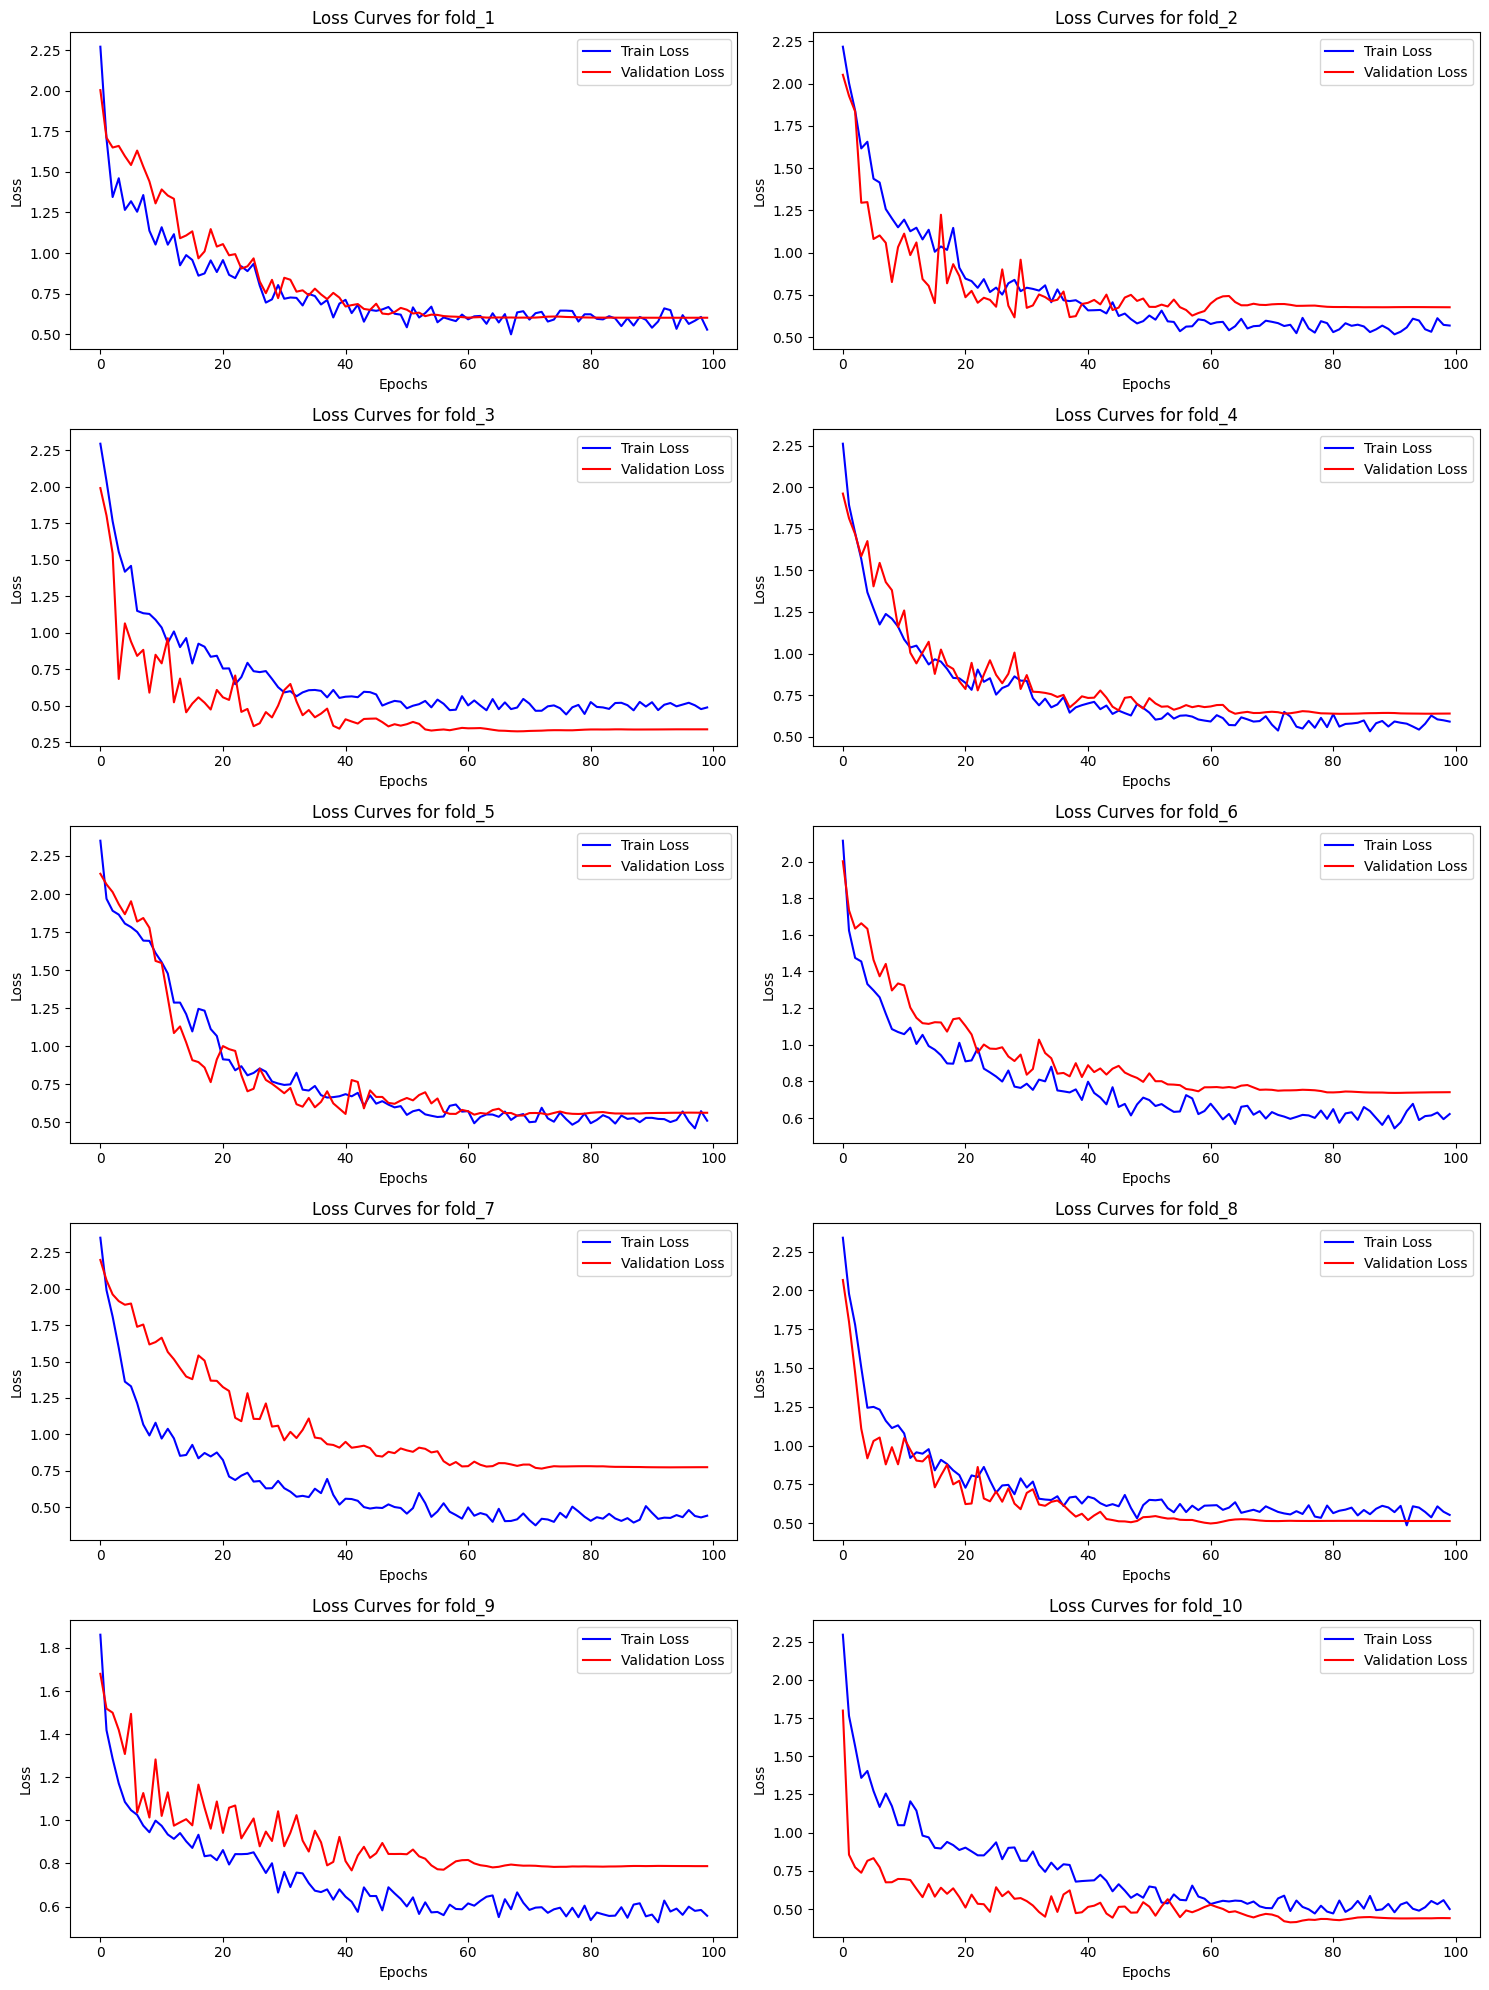

In [ ]:
# PLOTTING TRAIN & VAL LOSS CURVES FOR ALL FOLDS SEPARATELY

# plt.figure(figsize=(15, 20))
# for i, (fold, loss_data) in enumerate(fold_loss_history.items(), 1):
#     plt.subplot(5, 2, i)
#     plt.plot(loss_data["train"], label="Train Loss", color="blue")
#     plt.plot(loss_data["val"], label="Validation Loss", color="red")
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.title(f"Loss Curves for {fold}")
#     plt.legend()

# plt.tight_layout()
# plt.show()

# SEEING SO MUCH UNEVEN DIFFERENCES IN TRAIN/VAL SCORES IN THE FOLDS, INDICATES
# IRREGULAR K-FOLD SPLITS PROBABLY DUE TO SMALL DATASETS WITH SOME TYPE 
# OF DISKS OVERPOWERING OTHER LESSER IN NUMBER DISKS TYPES

# USING ENSEMBLING WILL DECREASE CHANCES OF OVERFITTING TO ANY SPECFIC VARIETY OF DISK

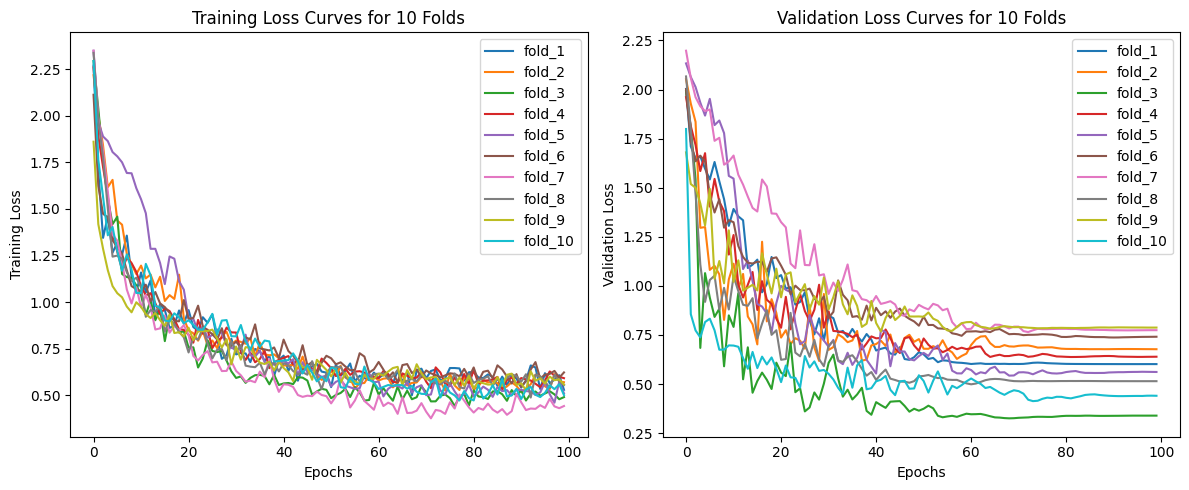

In [ ]:
# PLOTTING TRAIN LOSSES FOR ALL FOLDS & VAL LOSSES FOR ALL FOLDS

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# for fold, loss_data in fold_loss_history.items():
#     plt.plot(loss_data["train"], label=fold)
# plt.xlabel("Epochs")
# plt.ylabel("Training Loss")
# plt.title("Training Loss Curves for 10 Folds")
# plt.legend()

# plt.subplot(1, 2, 2)
# for fold, loss_data in fold_loss_history.items():
#     plt.plot(loss_data["val"], label=fold)
# plt.xlabel("Epochs")
# plt.ylabel("Validation Loss")
# plt.title("Validation Loss Curves for 10 Folds")
# plt.legend()

# plt.tight_layout()
# plt.show()

# Loading Model(s)

In [ ]:
# Single Model (Not Preferred - train split was not diverse covering all variety of disks)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_no = 1
models = []
eae = EquivariantAE()
checkpoint = torch.load(base_path+f"/EXXA-models&data/eae_fold_{fold_no}.pth")
eae.load_state_dict(checkpoint['model_state_dict'])
eae = eae.to(device)
models.append(eae)

for fold, (train_idx, test_idx) in enumerate(kf.split(paths)):
  if fold == fold_no:
    break

train_paths = [paths[i] for i in train_idx]
train_dataset = MeraDataset(train_paths, transform=test_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_paths = [paths[i] for i in test_idx]
test_dataset = MeraDataset(test_paths, transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [27]:
# All Kfold trained models (Preferred - covers all given data buit less chance of overfitting due to average voting)

models = []
for fold in range(1, 11):
    model = EquivariantAE()
    model.load_state_dict(torch.load(base_path+f"/EXXA-models&data/eae_fold_{fold}.pth")['model_state_dict'])
    model = model.to(device)
    models.append(model)

full_test_dataset = MeraDataset(paths, transform=test_transforms)
full_test_dataloader = DataLoader(full_test_dataset, batch_size=16, shuffle=False)
train_dataloader = full_test_dataloader
test_dataloader = full_test_dataloader

<ipython-input-27-c1590c4918a1>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(base_path+f"/eae_fold_{fold}.pth")['model_state_dict'])


In [28]:
def ensemble_forward(x,models=models):
    recons = []
    latents = []
    
    for model in models :
        with torch.no_grad():
            x_recon, z1 = model(x)
            recons.append(x_recon)
            latents.append(z1)
    
    mean_recon = torch.mean(torch.stack(recons), dim=0)
    mean_latent = torch.mean(torch.stack(latents), dim=0)
    return mean_recon, mean_latent


# Clustering

In [58]:
# HELPER FUNCTION FOR CLUSTERING

def plot_clustered_images(clustered_images, num_samples=20):
    for cluster, imgs in clustered_images.items():
        print(f"Cluster {cluster} contains {len(imgs)} images")
        plt.figure(figsize=(25, 20))
        
        for i, img in enumerate(imgs[:num_samples]):
            plt.subplot(6, num_samples // 6, i + 1)
            plt.imshow(img.squeeze(), cmap='magma')
            plt.axis('off')

        save_path = f"output_cluster_{cluster}.png"
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.close()

In [59]:
# GETTING LATENT VECTORS FOR ALL IMAGES FOR CLUSTERING

all_latents = []
images = []

with torch.no_grad():
    for x in train_dataloader:
        x = x.to(device)
        images.append(x.cpu().numpy())

        latents = []
        _,ensemble_latent = ensemble_forward(x)
        all_latents.append(ensemble_latent.cpu().numpy())
       
latent_vectors = np.concatenate(all_latents, axis=0)
images  = np.concatenate(images, axis=0)

Cluster 0 contains 77 images


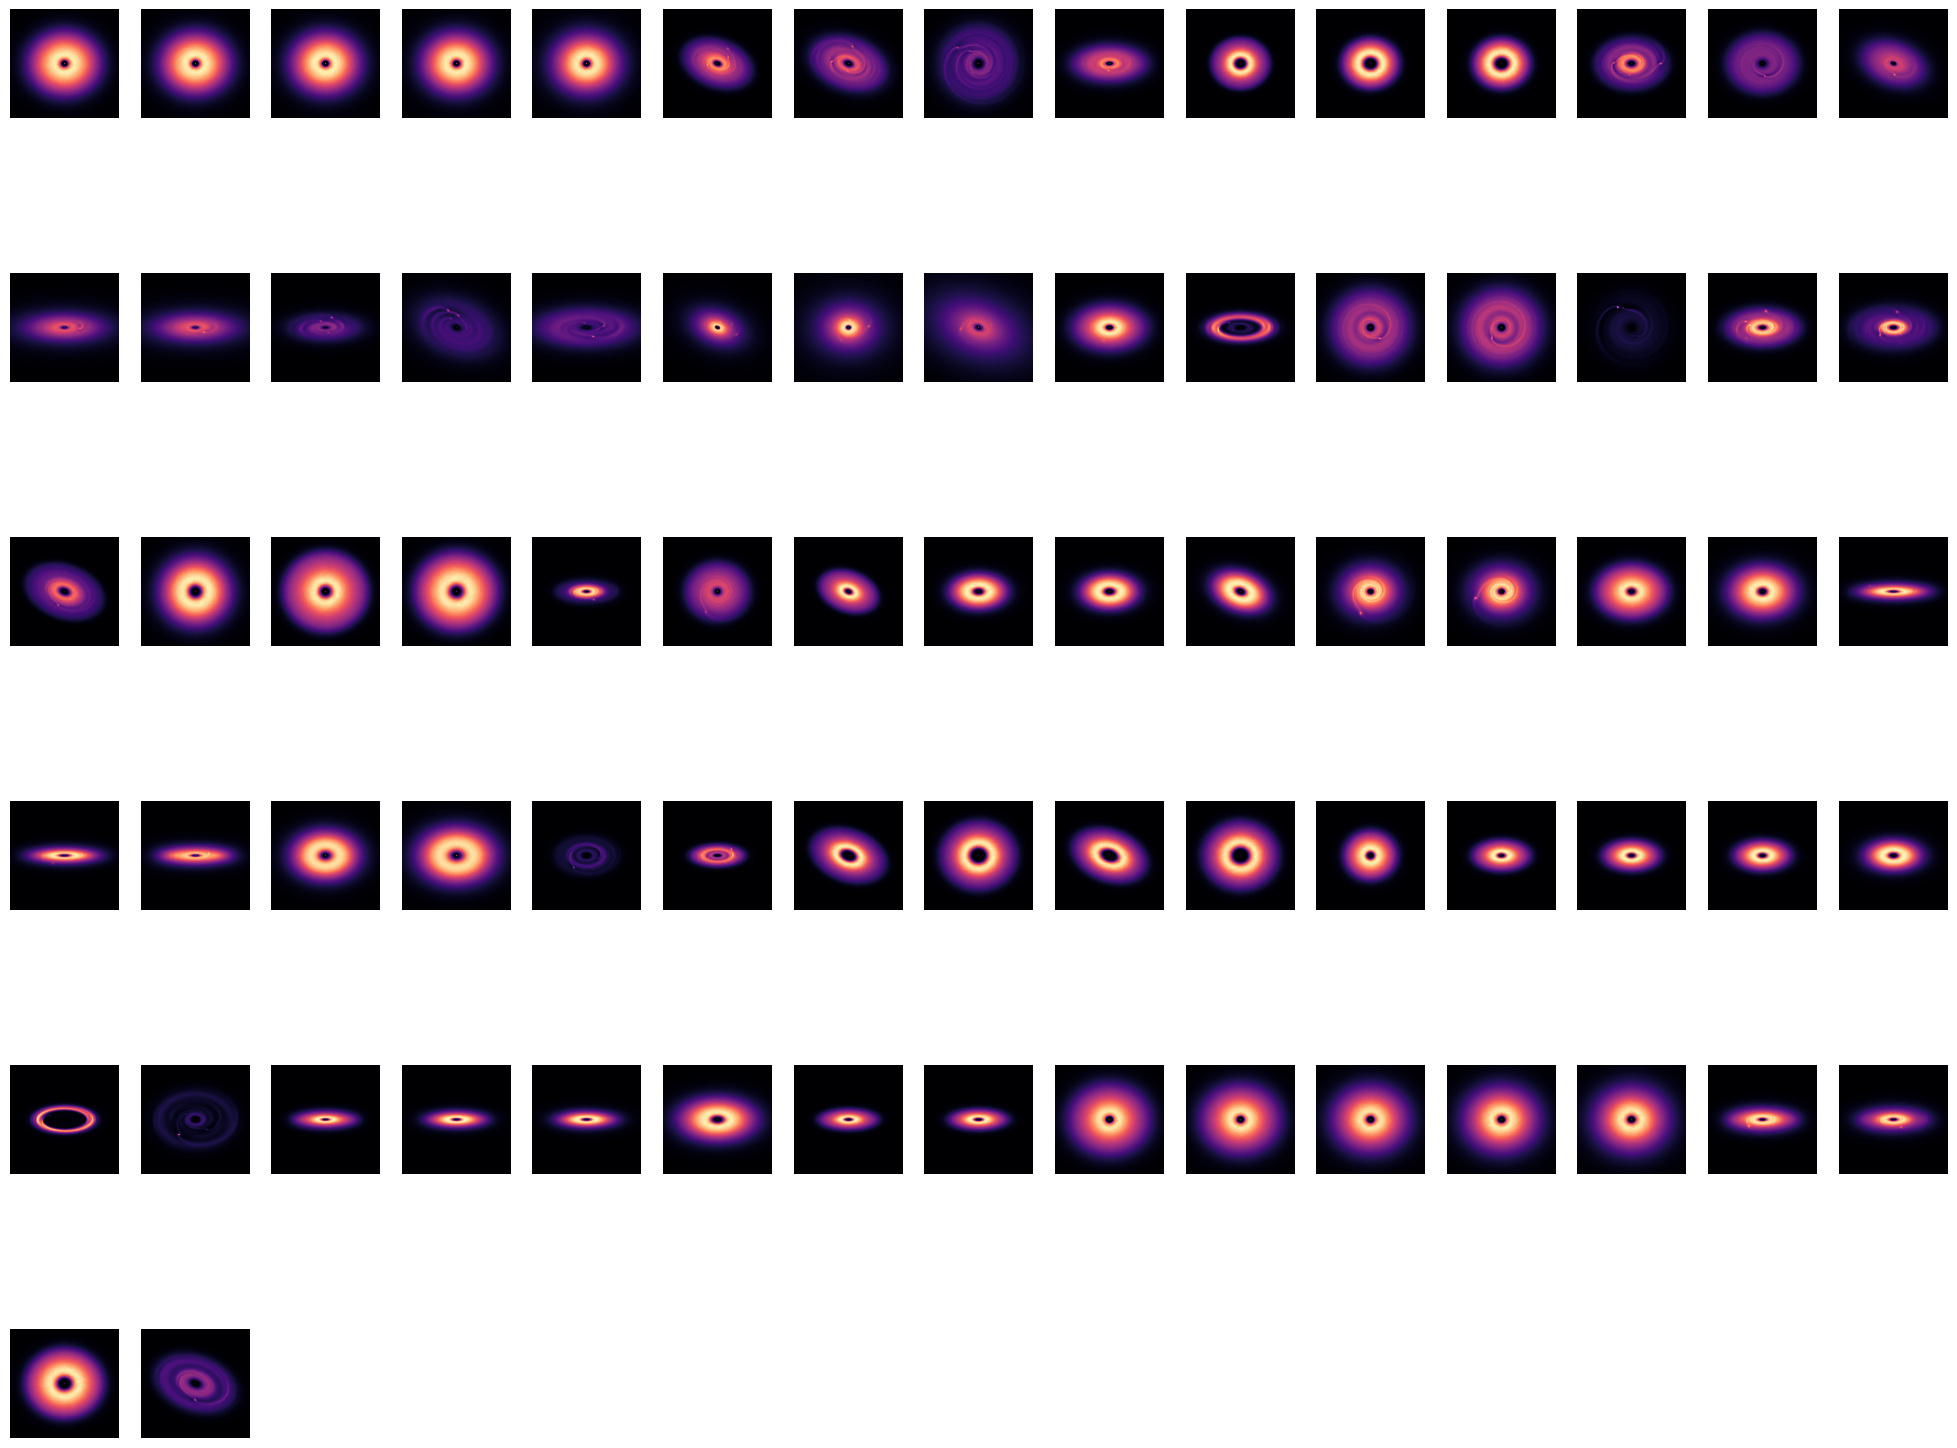

Cluster 1 contains 73 images


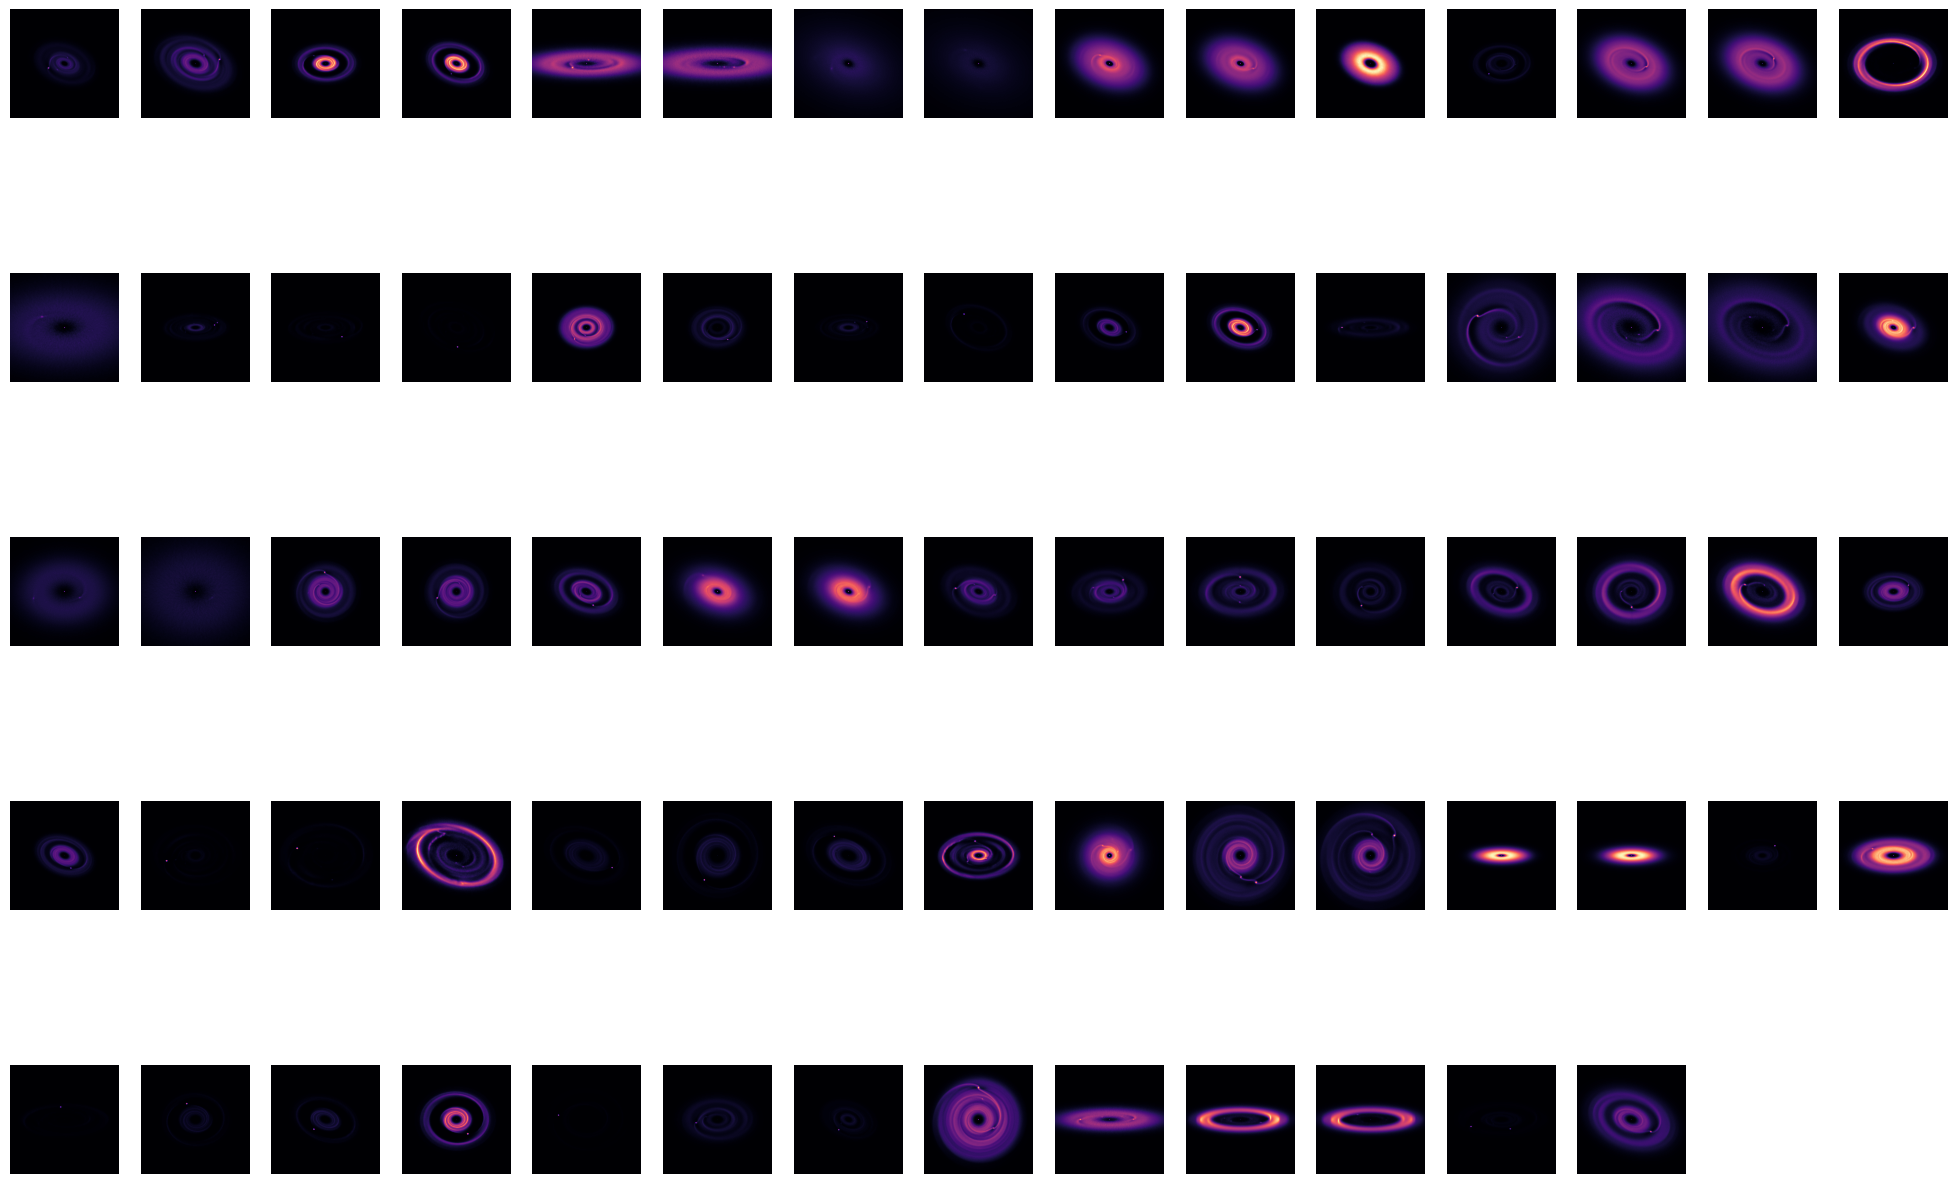

In [60]:
# CLUSTERING USING SpectralClustering, PERFROMED BETTER THAN KMEANS , GMMs

num_clusters=2
metric = 'laplacian'
clustering = SpectralClustering(n_clusters=num_clusters, affinity=metric, random_state=42)
labels = clustering.fit_predict(latent_vectors)

clustered_images = {i: [] for i in range(num_clusters)}

for img, label in zip(images, labels):
    clustered_images[label].append(img)

centroids = {}
for cluster_id in range(num_clusters):
    cluster_vectors = latent_vectors[labels == cluster_id]
    centroids[cluster_id] = np.mean(cluster_vectors, axis=0)

centroids = np.array([centroids[i] for i in range(num_clusters)])

plot_clustered_images(clustered_images, num_samples = 90)

In [61]:
# HELPER FUNCTION TO OBTAIN CENTROID GIVEN LATENT VECTOR

def assign_to_nearest_centroid(vector , centroids=centroids):
    centroids = np.array(centroids)
    distances = np.linalg.norm(centroids - vector, axis=1)
    return np.argmin(distances)

# Skip if used ensemble model

In [32]:
# images = []
# all_latents = []
# with torch.no_grad():
#     for x in test_dataloader:
#         x = x.to(device)
#         images.append(x.cpu().numpy())

#         latents = []
#         for model in models:
#             _, latent = model(x)
#             latent = latent.view(latent.shape[0], -1)
#             latents.append(latent.cpu().numpy())

#         ensemble_latent = np.mean(np.stack(latents), axis=0)
#         all_latents.append(ensemble_latent)

# latent_vectors = np.concatenate(all_latents, axis=0)
# images  = np.concatenate(images, axis=0)

# clustered_images = {i: [] for i in range(num_clusters)}

# for img, vector in zip(images, latent_vectors):
#     clustered_images[assign_to_nearest_centroid(vector)].append(img)

# plot_clustered_images(clustered_images, num_samples = 90)

In [33]:
#Checking invaraint nature of the architecture wrt below transformations

e2trans_shear = transforms.Compose([
    transforms.Pad(padding=414, padding_mode="edge"),
    transforms.RandomChoice([
        transforms.RandomAffine(degrees=180,scale=(0.2,1),shear=(20, 50)),
        transforms.RandomAffine(degrees=180,scale=(0.2,1),shear=(-50, -20))]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.CenterCrop((256, 256)),
])

index = 1

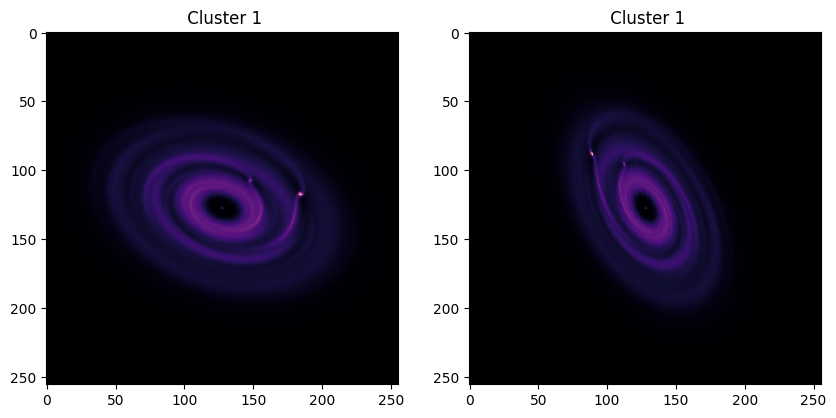

In [38]:
img = torch.tensor(images[index])
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title(f" Cluster {assign_to_nearest_centroid(latent_vectors[index])}")
plt.imshow(img[0],cmap='magma')


transformed = e2trans_shear(img)
plt.subplot(1,2,2)
with torch.no_grad():
    _,transformed_latent_vector = ensemble_forward(transformed.to(device).unsqueeze(0))
plt.title(f" Cluster {assign_to_nearest_centroid(transformed_latent_vector.cpu().numpy())}")
plt.imshow(transformed[0],cmap='magma')


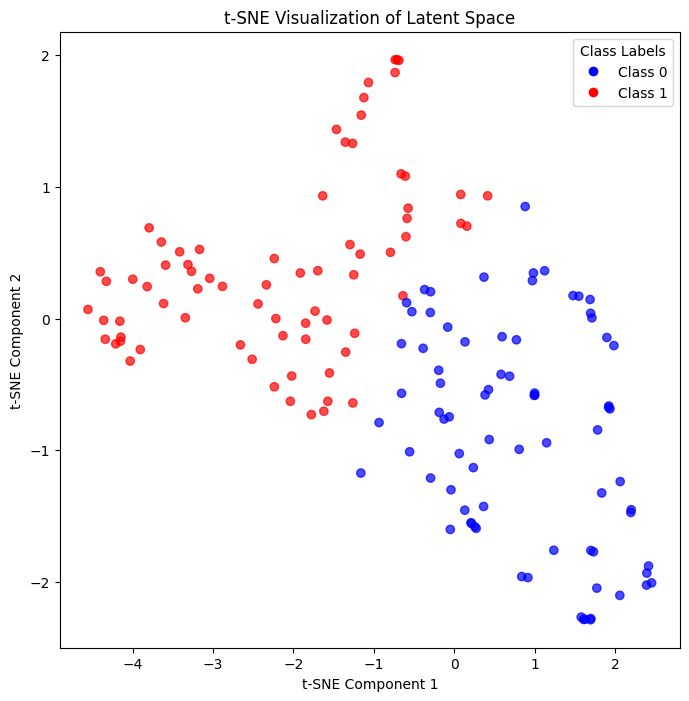

In [44]:
# t-SNE plot visualisation for observing clarity of separated clusters 

def plot_tsne(latent_vectors, labels=None):
    tsne = TSNE(n_components=2, perplexity=85, random_state=52)
    reduced = tsne.fit_transform(latent_vectors)

    plt.figure(figsize=(8, 8))

    if labels is not None:
        # Map labels to colors (assuming binary classes: 0 → blue, 1 → red)
        colors = np.array(['blue', 'red'])
        scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=colors[labels], alpha=0.7)
    else:
        scatter = plt.scatter(reduced[:, 0], reduced[:, 1], color='gray', alpha=0.7)

    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("t-SNE Visualization of Latent Space")

    # Create a custom legend
    if labels is not None:
        plt.legend(handles=[
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label="Class 0"),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label="Class 1")
        ], title="Class Labels")

    plt.show()

plot_tsne(latent_vectors, labels=labels)


# Testing

In [51]:
path_to_your_image = "/kaggle/working/continuum_data_subset/planet0_00226_1250.fits"


with fits.open(path_to_your_image) as hdul:
    image = hdul[0].data[0][0][0]
    image = normalise(image)

x = test_transforms(image)
_,ensemble_latent = ensemble_forward(x.unsqueeze(0).to(device))

print(assign_to_nearest_centroid(ensemble_latent.cpu().numpy()))

# SEE ABOVE IMAGES TO LOOK FOR CLUSTER 1/0

1
